In [1]:
import os

import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, Subset, ConcatDataset
import numpy as np

from tqdm import tqdm
import random

In [2]:
import model
import dataset
import augmentation as aug

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

In [4]:
def train_epoch(model, optimizer, dataloader, device):


    model.train()

    total_loss = 0
    
    dice_total = 0
    kl_total = 0
    dl_total = 0
    bce_total = 0
    
    dice_loss = smp.utils.losses.DiceLoss()
#     bce_loss = torch.nn.BCELoss(reduction='none')

    for index, data in tqdm(enumerate(dataloader)):

        optimizer.zero_grad()

        img, msk, _ = data

        img = img.to(device)
        msk = msk.to(device, dtype=torch.float)

        pr, kl_loss, dl_loss = model(img)

        ### Predicted mask loss
        pr = pr.squeeze(1)


        dice = dice_loss(pr, msk)
        
        ### bce loss
#         bce = bce_loss(pr, msk)
#         weight = msk.clone().detach()
#         weight = torch.where(weight == 1, 100, 1)
#         bce = bce * weight # weighted foreground/background
#         bce = torch.mean(bce)
        
        kl = torch.mean(kl_loss)
        dl = torch.mean(dl_loss)

        loss = dice
#         loss = dice + kl + dl
#         loss = bce + kl + dl
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        dice_total += dice.item()
#         bce_total += bce.item()
        kl_total += kl.item()
        dl_total += dl.item()

    total_loss = total_loss/(index+1)
    dice_total = dice_total/(index+1)
#     bce_total = bce_total/(index+1)
#     kl_total = kl_total/(index+1)
#     dl_total = dl_total/(index+1)

    return total_loss, dice_total
#     return total_loss, dice_total, kl_total, dl_total

In [5]:
@torch.no_grad()
def eval_epoch(model, dataloader, device):

    import math
    from torch.utils.data import DataLoader

    model.eval()

    iou_score = []
    
    metric_iou = smp.utils.metrics.IoU()

    for index, data in tqdm(enumerate(dataloader)):

        img, msk, _ = data

        img = img.to(device)
        msk = msk.to(device)

        pr, _, _ = model(img)
        iou = metric_iou(pr, msk)

        iou_score.append(iou.item())

    return sum(iou_score)/len(iou_score)

In [24]:
@torch.no_grad()
def test_epoch(model, dataset, device):

    import math
    from torch.utils.data import DataLoader

    model.eval()

    metric_iou = smp.utils.metrics.IoU()
    
    imgs = []
    predict = []
    msks = []
    iou_score = []

    dataloader = DataLoader(dataset, batch_size=1,
                            shuffle=False, num_workers=2)

    for index, data in tqdm(enumerate(dataloader)):

        img, msk, cpy = data

        img = img.to(device)
        msk = msk.to(device)

        pr, _, _ = model(img)

        iou = metric_iou(pr, msk)

        pr = torch.squeeze(pr, dim=0).detach().cpu().numpy()
        msk = torch.squeeze(msk, dim=0).detach().cpu().numpy()
        cpy = torch.squeeze(cpy, dim=0).detach().cpu().numpy()

        predict.append(pr.transpose(1, 2, 0))
        imgs.append(cpy)
        msks.append(msk)
        iou_score.append(iou.item())


    return imgs, predict, msks, iou_score

In [7]:
batch = 4
n_channels = 3
n_classes = 1
epochs = 1000

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [8]:
ENCODER = 'densenet161'
ENCODER_WEIGHTS = 'imagenet'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [9]:
unet = smp.Unet(encoder_name=ENCODER, 
                 encoder_weights=ENCODER_WEIGHTS,
                decoder_attention_type=None,
                 in_channels=3, classes=1, activation="sigmoid", aux_params=None)

In [10]:
encoder = unet.encoder

In [11]:
decoder = model.SCGDecoder(None, None, torch.nn.Sigmoid())

In [12]:
scg_net = model.SCGNet(encoder=encoder, 
               decoder=decoder,).to(device)

optimizer = torch.optim.SGD(scg_net.parameters(), lr=1e-4, momentum=0.9)

In [13]:
trainset = dataset.JSRTset(root=os.path.join(os.getcwd(), "data", "trainset"),
                          augmentation=aug.get_training_augmentation(), 
                           preprocessing=aug.get_preprocessing(preprocessing_fn),)
valset = dataset.JSRTset(root=os.path.join(os.getcwd(), "data", "valset"),
                          augmentation=aug.get_validation_augmentation(), 
                           preprocessing=aug.get_preprocessing(preprocessing_fn),)
testset = dataset.JSRTset(root=os.path.join(os.getcwd(), "data", "testset"),
                          augmentation=aug.get_validation_augmentation(), 
                           preprocessing=aug.get_preprocessing(preprocessing_fn),)

In [14]:
trainloader = DataLoader(trainset, batch_size=batch, shuffle=True, num_workers=2)
validloader = DataLoader(valset, batch_size=batch, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch, shuffle=False, num_workers=2)

In [15]:
epoch_logs = {
    "diceloss": [],
#     "bce loss":[],
#     "kl divergence": [],
#     "diagonal loss": [],
    "iou-train": [],
    "iou-valid": []
}

In [16]:
iou_valid = 0.0

for epoch in range(epochs):
    
    loss = train_epoch(scg_net, optimizer, trainloader, device)
    eval_train = eval_epoch(scg_net, trainloader, device)
    eval_valid = eval_epoch(scg_net, validloader, device)
    
#     print("Epoch: {}, total loss={:.5f}, dice loss={:.5f}, kl loss={:.5f}, dl loss={:.5f}".format(epoch, 
#                                                                                                   loss[0],
#                                                                                                  loss[1],
#                                                                                                  loss[2],
#                                                                                                  loss[3]))
    print("Epoch: {}, total loss={:.5f}, dice loss={:.5f}".format(epoch, 
                                                                  loss[0],
                                                                 loss[1],))
    print("Valid-IoU: {:.5f}, Train-IoU: {:.5f}".format(eval_valid, eval_train))
    
    epoch_logs['diceloss'].append(loss[1])
#     epoch_logs["bce loss"].append(loss[1])
#     epoch_logs['kl divergence'].append(loss[2])
#     epoch_logs['diagonal loss'].append(loss[3])
    epoch_logs['iou-train'].append(eval_train)
    epoch_logs['iou-valid'].append(eval_valid)
   
    if epoch == int(epochs*0.5):
        optimizer.param_groups[0]['lr'] = 5e-5
        print('Decrease learning rate to 1e-4!')
    elif epoch == int(epochs*0.75):
        optimizer.param_groups[0]['lr'] = 1e-6
        print('Decrease learning rate to 1e-5!')
        
    if eval_valid > iou_valid:
        iou_valid = eval_valid
        checkpoint = {
            'model_stat': unet.state_dict(),
            'optimizer_stat': optimizer.state_dict(),
        }
        torch.save(checkpoint, os.path.join(os.getcwd(), "{:04d}_{:04d}_{:04d}.pth".format(int(eval_valid*1000),
                                                                                   int(eval_train*1000),
                                                                                   int(loss[0]*1000))))
        print("Model Saved")
    

41it [00:09,  4.33it/s]
41it [00:07,  5.76it/s]
8it [00:01,  5.24it/s]


Epoch: 0, total loss=2.17849, dice loss=0.99744, kl loss=1.17931, dl loss=0.00175
Valid-IoU: 0.00235, Train-IoU: 0.00397
Model Saved


41it [00:09,  4.43it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.19it/s]


Epoch: 1, total loss=1.39545, dice loss=0.99743, kl loss=0.39628, dl loss=0.00175
Valid-IoU: 0.00348, Train-IoU: 0.00530
Model Saved


41it [00:09,  4.44it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.22it/s]

Epoch: 2, total loss=1.25504, dice loss=0.99744, kl loss=0.25585, dl loss=0.00176
Valid-IoU: 0.00276, Train-IoU: 0.00504



41it [00:09,  4.41it/s]
41it [00:07,  5.60it/s]
8it [00:01,  5.15it/s]

Epoch: 3, total loss=1.19339, dice loss=0.99744, kl loss=0.19420, dl loss=0.00175
Valid-IoU: 0.00283, Train-IoU: 0.00475



41it [00:09,  4.44it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.20it/s]

Epoch: 4, total loss=1.15199, dice loss=0.99744, kl loss=0.15280, dl loss=0.00175
Valid-IoU: 0.00315, Train-IoU: 0.00494



41it [00:09,  4.44it/s]
41it [00:07,  5.78it/s]
8it [00:01,  5.16it/s]

Epoch: 5, total loss=1.12558, dice loss=0.99742, kl loss=0.12640, dl loss=0.00175
Valid-IoU: 0.00284, Train-IoU: 0.00567



41it [00:09,  4.42it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.19it/s]

Epoch: 6, total loss=1.10311, dice loss=0.99743, kl loss=0.10393, dl loss=0.00175
Valid-IoU: 0.00337, Train-IoU: 0.00560



41it [00:09,  4.43it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.28it/s]

Epoch: 7, total loss=1.08906, dice loss=0.99741, kl loss=0.08989, dl loss=0.00176
Valid-IoU: 0.00328, Train-IoU: 0.00596



41it [00:09,  4.42it/s]
41it [00:07,  5.60it/s]
8it [00:01,  5.16it/s]

Epoch: 8, total loss=1.07806, dice loss=0.99744, kl loss=0.07888, dl loss=0.00174
Valid-IoU: 0.00313, Train-IoU: 0.00605



41it [00:09,  4.43it/s]
41it [00:07,  5.60it/s]
8it [00:01,  5.18it/s]

Epoch: 9, total loss=1.07138, dice loss=0.99743, kl loss=0.07221, dl loss=0.00174
Valid-IoU: 0.00280, Train-IoU: 0.00511



41it [00:09,  4.45it/s]
41it [00:07,  5.73it/s]
8it [00:01,  5.11it/s]

Epoch: 10, total loss=1.06227, dice loss=0.99746, kl loss=0.06306, dl loss=0.00176
Valid-IoU: 0.00334, Train-IoU: 0.00524



41it [00:09,  4.43it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.15it/s]

Epoch: 11, total loss=1.05660, dice loss=0.99744, kl loss=0.05740, dl loss=0.00176
Valid-IoU: 0.00312, Train-IoU: 0.00523



41it [00:09,  4.40it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.15it/s]

Epoch: 12, total loss=1.05152, dice loss=0.99744, kl loss=0.05233, dl loss=0.00175
Valid-IoU: 0.00311, Train-IoU: 0.00445



41it [00:09,  4.41it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.19it/s]

Epoch: 13, total loss=1.04566, dice loss=0.99745, kl loss=0.04645, dl loss=0.00177
Valid-IoU: 0.00317, Train-IoU: 0.00440



41it [00:09,  4.44it/s]
41it [00:07,  5.49it/s]
8it [00:01,  5.15it/s]

Epoch: 14, total loss=1.04217, dice loss=0.99741, kl loss=0.04302, dl loss=0.00173
Valid-IoU: 0.00331, Train-IoU: 0.00494



41it [00:09,  4.42it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.22it/s]

Epoch: 15, total loss=1.03861, dice loss=0.99740, kl loss=0.03947, dl loss=0.00175
Valid-IoU: 0.00342, Train-IoU: 0.00557



41it [00:09,  4.43it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.13it/s]


Epoch: 16, total loss=1.03546, dice loss=0.99743, kl loss=0.03627, dl loss=0.00176
Valid-IoU: 0.00351, Train-IoU: 0.00507
Model Saved


41it [00:09,  4.44it/s]
41it [00:07,  5.54it/s]
8it [00:01,  5.15it/s]

Epoch: 17, total loss=1.03332, dice loss=0.99745, kl loss=0.03411, dl loss=0.00176
Valid-IoU: 0.00332, Train-IoU: 0.00554



41it [00:09,  4.41it/s]
41it [00:07,  5.76it/s]
8it [00:01,  5.18it/s]

Epoch: 18, total loss=1.03055, dice loss=0.99742, kl loss=0.03137, dl loss=0.00175
Valid-IoU: 0.00336, Train-IoU: 0.00487



41it [00:09,  4.39it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.12it/s]


Epoch: 19, total loss=1.02822, dice loss=0.99744, kl loss=0.02903, dl loss=0.00175
Valid-IoU: 0.00362, Train-IoU: 0.00509
Model Saved


41it [00:09,  4.43it/s]
41it [00:07,  5.75it/s]
8it [00:01,  5.26it/s]

Epoch: 20, total loss=1.02672, dice loss=0.99740, kl loss=0.02756, dl loss=0.00176
Valid-IoU: 0.00361, Train-IoU: 0.00573



41it [00:09,  4.40it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.09it/s]

Epoch: 21, total loss=1.02505, dice loss=0.99745, kl loss=0.02583, dl loss=0.00177
Valid-IoU: 0.00339, Train-IoU: 0.00535



41it [00:09,  4.41it/s]
41it [00:07,  5.77it/s]
8it [00:01,  5.30it/s]


Epoch: 22, total loss=1.02378, dice loss=0.99744, kl loss=0.02459, dl loss=0.00175
Valid-IoU: 0.00412, Train-IoU: 0.00612
Model Saved


41it [00:09,  4.46it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.26it/s]

Epoch: 23, total loss=1.02261, dice loss=0.99741, kl loss=0.02345, dl loss=0.00174
Valid-IoU: 0.00364, Train-IoU: 0.00543



41it [00:09,  4.41it/s]
41it [00:07,  5.60it/s]
8it [00:01,  5.06it/s]

Epoch: 24, total loss=1.02130, dice loss=0.99740, kl loss=0.02214, dl loss=0.00176
Valid-IoU: 0.00339, Train-IoU: 0.00435



41it [00:09,  4.45it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.20it/s]

Epoch: 25, total loss=1.01976, dice loss=0.99742, kl loss=0.02060, dl loss=0.00174
Valid-IoU: 0.00335, Train-IoU: 0.00558



41it [00:09,  4.44it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.18it/s]

Epoch: 26, total loss=1.01889, dice loss=0.99742, kl loss=0.01974, dl loss=0.00174
Valid-IoU: 0.00323, Train-IoU: 0.00499



41it [00:09,  4.43it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.11it/s]

Epoch: 27, total loss=1.01794, dice loss=0.99743, kl loss=0.01876, dl loss=0.00175
Valid-IoU: 0.00357, Train-IoU: 0.00450



41it [00:09,  4.43it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.24it/s]

Epoch: 28, total loss=1.01715, dice loss=0.99744, kl loss=0.01795, dl loss=0.00176
Valid-IoU: 0.00374, Train-IoU: 0.00603



41it [00:09,  4.40it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.22it/s]

Epoch: 29, total loss=1.01659, dice loss=0.99746, kl loss=0.01737, dl loss=0.00176
Valid-IoU: 0.00380, Train-IoU: 0.00571



41it [00:09,  4.42it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.10it/s]

Epoch: 30, total loss=1.01591, dice loss=0.99742, kl loss=0.01674, dl loss=0.00175
Valid-IoU: 0.00360, Train-IoU: 0.00550



41it [00:09,  4.41it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.29it/s]

Epoch: 31, total loss=1.01470, dice loss=0.99743, kl loss=0.01552, dl loss=0.00176
Valid-IoU: 0.00346, Train-IoU: 0.00479



41it [00:09,  4.44it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.15it/s]

Epoch: 32, total loss=1.01413, dice loss=0.99742, kl loss=0.01494, dl loss=0.00177
Valid-IoU: 0.00405, Train-IoU: 0.00521



41it [00:09,  4.45it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.19it/s]

Epoch: 33, total loss=1.01412, dice loss=0.99739, kl loss=0.01499, dl loss=0.00174
Valid-IoU: 0.00376, Train-IoU: 0.00406



41it [00:09,  4.42it/s]
41it [00:07,  5.59it/s]
8it [00:01,  5.11it/s]


Epoch: 34, total loss=1.01330, dice loss=0.99744, kl loss=0.01411, dl loss=0.00176
Valid-IoU: 0.00427, Train-IoU: 0.00514
Model Saved


41it [00:09,  4.40it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.10it/s]

Epoch: 35, total loss=1.01251, dice loss=0.99743, kl loss=0.01334, dl loss=0.00175
Valid-IoU: 0.00392, Train-IoU: 0.00495



41it [00:09,  4.44it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.14it/s]

Epoch: 36, total loss=1.01216, dice loss=0.99741, kl loss=0.01298, dl loss=0.00177
Valid-IoU: 0.00397, Train-IoU: 0.00512



41it [00:09,  4.45it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.23it/s]

Epoch: 37, total loss=1.01164, dice loss=0.99744, kl loss=0.01245, dl loss=0.00175
Valid-IoU: 0.00420, Train-IoU: 0.00566



41it [00:09,  4.45it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.22it/s]

Epoch: 38, total loss=1.01090, dice loss=0.99741, kl loss=0.01175, dl loss=0.00174
Valid-IoU: 0.00424, Train-IoU: 0.00559



41it [00:09,  4.46it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.23it/s]

Epoch: 39, total loss=1.01089, dice loss=0.99742, kl loss=0.01171, dl loss=0.00176
Valid-IoU: 0.00383, Train-IoU: 0.00461



41it [00:09,  4.42it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.26it/s]

Epoch: 40, total loss=1.01037, dice loss=0.99740, kl loss=0.01122, dl loss=0.00175
Valid-IoU: 0.00423, Train-IoU: 0.00589



41it [00:09,  4.43it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.29it/s]

Epoch: 41, total loss=1.01024, dice loss=0.99746, kl loss=0.01103, dl loss=0.00176
Valid-IoU: 0.00403, Train-IoU: 0.00433



41it [00:09,  4.44it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.19it/s]

Epoch: 42, total loss=1.00980, dice loss=0.99740, kl loss=0.01064, dl loss=0.00176
Valid-IoU: 0.00414, Train-IoU: 0.00495



41it [00:09,  4.44it/s]
41it [00:07,  5.75it/s]
8it [00:01,  5.18it/s]

Epoch: 43, total loss=1.01005, dice loss=0.99745, kl loss=0.01084, dl loss=0.00176
Valid-IoU: 0.00363, Train-IoU: 0.00444



41it [00:09,  4.43it/s]
41it [00:07,  5.76it/s]
8it [00:01,  5.17it/s]

Epoch: 44, total loss=1.00864, dice loss=0.99740, kl loss=0.00948, dl loss=0.00176
Valid-IoU: 0.00400, Train-IoU: 0.00452



41it [00:09,  4.45it/s]
41it [00:07,  5.79it/s]
8it [00:01,  5.23it/s]

Epoch: 45, total loss=1.00840, dice loss=0.99742, kl loss=0.00921, dl loss=0.00177
Valid-IoU: 0.00423, Train-IoU: 0.00506



41it [00:09,  4.40it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.19it/s]

Epoch: 46, total loss=1.00820, dice loss=0.99740, kl loss=0.00905, dl loss=0.00175
Valid-IoU: 0.00388, Train-IoU: 0.00449



41it [00:09,  4.44it/s]
41it [00:07,  5.60it/s]
8it [00:01,  5.21it/s]

Epoch: 47, total loss=1.00763, dice loss=0.99741, kl loss=0.00845, dl loss=0.00177
Valid-IoU: 0.00416, Train-IoU: 0.00515



41it [00:09,  4.44it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.21it/s]

Epoch: 48, total loss=1.00768, dice loss=0.99741, kl loss=0.00850, dl loss=0.00177
Valid-IoU: 0.00360, Train-IoU: 0.00422



41it [00:09,  4.44it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.26it/s]

Epoch: 49, total loss=1.00740, dice loss=0.99747, kl loss=0.00816, dl loss=0.00177
Valid-IoU: 0.00421, Train-IoU: 0.00526



41it [00:09,  4.46it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.18it/s]

Epoch: 50, total loss=1.00718, dice loss=0.99742, kl loss=0.00800, dl loss=0.00176
Valid-IoU: 0.00407, Train-IoU: 0.00507



41it [00:09,  4.45it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.19it/s]

Epoch: 51, total loss=1.00695, dice loss=0.99742, kl loss=0.00779, dl loss=0.00174
Valid-IoU: 0.00393, Train-IoU: 0.00437



41it [00:09,  4.41it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.23it/s]

Epoch: 52, total loss=1.00673, dice loss=0.99742, kl loss=0.00757, dl loss=0.00174
Valid-IoU: 0.00402, Train-IoU: 0.00474



41it [00:09,  4.43it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.21it/s]


Epoch: 53, total loss=1.00654, dice loss=0.99745, kl loss=0.00733, dl loss=0.00177
Valid-IoU: 0.00439, Train-IoU: 0.00535
Model Saved


41it [00:09,  4.45it/s]
41it [00:07,  5.80it/s]
8it [00:01,  5.14it/s]

Epoch: 54, total loss=1.00640, dice loss=0.99739, kl loss=0.00725, dl loss=0.00175
Valid-IoU: 0.00432, Train-IoU: 0.00520



41it [00:09,  4.41it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.20it/s]

Epoch: 55, total loss=1.00630, dice loss=0.99745, kl loss=0.00707, dl loss=0.00177
Valid-IoU: 0.00392, Train-IoU: 0.00618



41it [00:09,  4.45it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.20it/s]

Epoch: 56, total loss=1.00615, dice loss=0.99743, kl loss=0.00697, dl loss=0.00175
Valid-IoU: 0.00418, Train-IoU: 0.00478



41it [00:09,  4.42it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.15it/s]

Epoch: 57, total loss=1.00598, dice loss=0.99745, kl loss=0.00676, dl loss=0.00177
Valid-IoU: 0.00422, Train-IoU: 0.00511



41it [00:09,  4.45it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.19it/s]

Epoch: 58, total loss=1.00610, dice loss=0.99745, kl loss=0.00690, dl loss=0.00175
Valid-IoU: 0.00437, Train-IoU: 0.00571



41it [00:09,  4.44it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.18it/s]


Epoch: 59, total loss=1.00559, dice loss=0.99743, kl loss=0.00639, dl loss=0.00176
Valid-IoU: 0.00450, Train-IoU: 0.00537
Model Saved


41it [00:09,  4.44it/s]
41it [00:07,  5.55it/s]
8it [00:01,  5.17it/s]

Epoch: 60, total loss=1.00525, dice loss=0.99741, kl loss=0.00608, dl loss=0.00176
Valid-IoU: 0.00419, Train-IoU: 0.00594



41it [00:09,  4.45it/s]
41it [00:07,  5.57it/s]
8it [00:01,  5.19it/s]

Epoch: 61, total loss=1.00545, dice loss=0.99745, kl loss=0.00625, dl loss=0.00175
Valid-IoU: 0.00418, Train-IoU: 0.00473



41it [00:09,  4.42it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.16it/s]

Epoch: 62, total loss=1.00510, dice loss=0.99740, kl loss=0.00594, dl loss=0.00175
Valid-IoU: 0.00422, Train-IoU: 0.00525



41it [00:09,  4.45it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.22it/s]

Epoch: 63, total loss=1.00493, dice loss=0.99741, kl loss=0.00576, dl loss=0.00177
Valid-IoU: 0.00424, Train-IoU: 0.00536



41it [00:09,  4.42it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.33it/s]

Epoch: 64, total loss=1.00471, dice loss=0.99740, kl loss=0.00556, dl loss=0.00175
Valid-IoU: 0.00419, Train-IoU: 0.00479



41it [00:09,  4.43it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.15it/s]

Epoch: 65, total loss=1.00462, dice loss=0.99739, kl loss=0.00549, dl loss=0.00174
Valid-IoU: 0.00407, Train-IoU: 0.00435



41it [00:09,  4.44it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.20it/s]

Epoch: 66, total loss=1.00445, dice loss=0.99740, kl loss=0.00530, dl loss=0.00175
Valid-IoU: 0.00443, Train-IoU: 0.00497



41it [00:09,  4.43it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.05it/s]

Epoch: 67, total loss=1.00433, dice loss=0.99743, kl loss=0.00516, dl loss=0.00175
Valid-IoU: 0.00410, Train-IoU: 0.00482



41it [00:09,  4.44it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.22it/s]

Epoch: 68, total loss=1.00430, dice loss=0.99745, kl loss=0.00511, dl loss=0.00174
Valid-IoU: 0.00423, Train-IoU: 0.00502



41it [00:09,  4.44it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.20it/s]

Epoch: 69, total loss=1.00418, dice loss=0.99747, kl loss=0.00496, dl loss=0.00175
Valid-IoU: 0.00414, Train-IoU: 0.00566



41it [00:09,  4.47it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.18it/s]

Epoch: 70, total loss=1.00396, dice loss=0.99740, kl loss=0.00482, dl loss=0.00174
Valid-IoU: 0.00406, Train-IoU: 0.00502



41it [00:09,  4.44it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.17it/s]

Epoch: 71, total loss=1.00398, dice loss=0.99739, kl loss=0.00485, dl loss=0.00174
Valid-IoU: 0.00403, Train-IoU: 0.00473



41it [00:09,  4.43it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.18it/s]

Epoch: 72, total loss=1.00388, dice loss=0.99740, kl loss=0.00475, dl loss=0.00174
Valid-IoU: 0.00421, Train-IoU: 0.00528



41it [00:09,  4.46it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.14it/s]

Epoch: 73, total loss=1.00389, dice loss=0.99741, kl loss=0.00474, dl loss=0.00175
Valid-IoU: 0.00380, Train-IoU: 0.00465



41it [00:09,  4.45it/s]
41it [00:07,  5.76it/s]
8it [00:01,  5.28it/s]

Epoch: 74, total loss=1.00365, dice loss=0.99740, kl loss=0.00451, dl loss=0.00174
Valid-IoU: 0.00450, Train-IoU: 0.00554



41it [00:09,  4.45it/s]
41it [00:07,  5.58it/s]
8it [00:01,  5.19it/s]

Epoch: 75, total loss=1.00354, dice loss=0.99743, kl loss=0.00436, dl loss=0.00176
Valid-IoU: 0.00433, Train-IoU: 0.00548



41it [00:09,  4.46it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.20it/s]

Epoch: 76, total loss=1.00355, dice loss=0.99746, kl loss=0.00434, dl loss=0.00175
Valid-IoU: 0.00441, Train-IoU: 0.00446



41it [00:09,  4.43it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.18it/s]

Epoch: 77, total loss=1.00342, dice loss=0.99742, kl loss=0.00424, dl loss=0.00176
Valid-IoU: 0.00439, Train-IoU: 0.00578



41it [00:09,  4.44it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.21it/s]

Epoch: 78, total loss=1.00334, dice loss=0.99744, kl loss=0.00415, dl loss=0.00175
Valid-IoU: 0.00435, Train-IoU: 0.00581



41it [00:09,  4.45it/s]
41it [00:07,  5.59it/s]
8it [00:01,  5.23it/s]

Epoch: 79, total loss=1.00338, dice loss=0.99743, kl loss=0.00420, dl loss=0.00176
Valid-IoU: 0.00427, Train-IoU: 0.00499



41it [00:09,  4.42it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.24it/s]

Epoch: 80, total loss=1.00317, dice loss=0.99744, kl loss=0.00398, dl loss=0.00175
Valid-IoU: 0.00412, Train-IoU: 0.00419



41it [00:09,  4.43it/s]
41it [00:07,  5.76it/s]
8it [00:01,  5.23it/s]

Epoch: 81, total loss=1.00312, dice loss=0.99740, kl loss=0.00396, dl loss=0.00176
Valid-IoU: 0.00425, Train-IoU: 0.00544



41it [00:09,  4.44it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.22it/s]

Epoch: 82, total loss=1.00310, dice loss=0.99739, kl loss=0.00396, dl loss=0.00175
Valid-IoU: 0.00408, Train-IoU: 0.00469



41it [00:09,  4.43it/s]
41it [00:07,  5.73it/s]
8it [00:01,  5.16it/s]

Epoch: 83, total loss=1.00311, dice loss=0.99744, kl loss=0.00391, dl loss=0.00176
Valid-IoU: 0.00436, Train-IoU: 0.00444



41it [00:09,  4.46it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.16it/s]

Epoch: 84, total loss=1.00297, dice loss=0.99742, kl loss=0.00379, dl loss=0.00175
Valid-IoU: 0.00444, Train-IoU: 0.00537



41it [00:09,  4.44it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.12it/s]

Epoch: 85, total loss=1.00288, dice loss=0.99739, kl loss=0.00373, dl loss=0.00176
Valid-IoU: 0.00385, Train-IoU: 0.00532



41it [00:09,  4.43it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.17it/s]

Epoch: 86, total loss=1.00291, dice loss=0.99741, kl loss=0.00375, dl loss=0.00175
Valid-IoU: 0.00438, Train-IoU: 0.00431



41it [00:09,  4.44it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.19it/s]

Epoch: 87, total loss=1.00282, dice loss=0.99749, kl loss=0.00357, dl loss=0.00177
Valid-IoU: 0.00403, Train-IoU: 0.00453



41it [00:09,  4.44it/s]
41it [00:07,  5.60it/s]
8it [00:01,  5.18it/s]

Epoch: 88, total loss=1.00268, dice loss=0.99743, kl loss=0.00349, dl loss=0.00176
Valid-IoU: 0.00410, Train-IoU: 0.00508



41it [00:09,  4.44it/s]
41it [00:07,  5.74it/s]
8it [00:01,  5.16it/s]


Epoch: 89, total loss=1.00258, dice loss=0.99742, kl loss=0.00339, dl loss=0.00177
Valid-IoU: 0.00460, Train-IoU: 0.00501
Model Saved


41it [00:09,  4.44it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.23it/s]

Epoch: 90, total loss=1.00267, dice loss=0.99744, kl loss=0.00348, dl loss=0.00175
Valid-IoU: 0.00450, Train-IoU: 0.00543



41it [00:09,  4.41it/s]
41it [00:07,  5.78it/s]
8it [00:01,  5.17it/s]

Epoch: 91, total loss=1.00258, dice loss=0.99743, kl loss=0.00340, dl loss=0.00174
Valid-IoU: 0.00434, Train-IoU: 0.00490



41it [00:09,  4.45it/s]
41it [00:07,  5.84it/s]
8it [00:01,  5.18it/s]


Epoch: 92, total loss=1.00247, dice loss=0.99743, kl loss=0.00329, dl loss=0.00175
Valid-IoU: 0.00470, Train-IoU: 0.00407
Model Saved


41it [00:09,  4.44it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.05it/s]

Epoch: 93, total loss=1.00261, dice loss=0.99743, kl loss=0.00344, dl loss=0.00174
Valid-IoU: 0.00424, Train-IoU: 0.00538



41it [00:09,  4.42it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.18it/s]

Epoch: 94, total loss=1.00235, dice loss=0.99744, kl loss=0.00317, dl loss=0.00174
Valid-IoU: 0.00433, Train-IoU: 0.00546



41it [00:09,  4.44it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.21it/s]

Epoch: 95, total loss=1.00224, dice loss=0.99741, kl loss=0.00309, dl loss=0.00174
Valid-IoU: 0.00459, Train-IoU: 0.00456



41it [00:09,  4.43it/s]
41it [00:07,  5.57it/s]
8it [00:01,  5.09it/s]

Epoch: 96, total loss=1.00231, dice loss=0.99742, kl loss=0.00313, dl loss=0.00176
Valid-IoU: 0.00397, Train-IoU: 0.00437



41it [00:09,  4.42it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.12it/s]

Epoch: 97, total loss=1.00222, dice loss=0.99740, kl loss=0.00306, dl loss=0.00175
Valid-IoU: 0.00430, Train-IoU: 0.00548



41it [00:09,  4.45it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.14it/s]

Epoch: 98, total loss=1.00218, dice loss=0.99743, kl loss=0.00301, dl loss=0.00174
Valid-IoU: 0.00418, Train-IoU: 0.00415



41it [00:09,  4.44it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.25it/s]

Epoch: 99, total loss=1.00218, dice loss=0.99739, kl loss=0.00304, dl loss=0.00175
Valid-IoU: 0.00438, Train-IoU: 0.00542



41it [00:09,  4.44it/s]
41it [00:07,  5.79it/s]
8it [00:01,  5.15it/s]

Epoch: 100, total loss=1.00214, dice loss=0.99744, kl loss=0.00294, dl loss=0.00176
Valid-IoU: 0.00418, Train-IoU: 0.00422



41it [00:09,  4.39it/s]
41it [00:07,  5.74it/s]
8it [00:01,  5.12it/s]

Epoch: 101, total loss=1.00214, dice loss=0.99740, kl loss=0.00298, dl loss=0.00176
Valid-IoU: 0.00407, Train-IoU: 0.00553



41it [00:09,  4.42it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.21it/s]

Epoch: 102, total loss=1.00206, dice loss=0.99743, kl loss=0.00289, dl loss=0.00175
Valid-IoU: 0.00425, Train-IoU: 0.00582



41it [00:09,  4.40it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.09it/s]

Epoch: 103, total loss=1.00195, dice loss=0.99741, kl loss=0.00278, dl loss=0.00176
Valid-IoU: 0.00452, Train-IoU: 0.00627



41it [00:09,  4.42it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.18it/s]


Epoch: 104, total loss=1.00206, dice loss=0.99741, kl loss=0.00289, dl loss=0.00175
Valid-IoU: 0.00470, Train-IoU: 0.00537
Model Saved


41it [00:09,  4.44it/s]
41it [00:07,  5.76it/s]
8it [00:01,  5.19it/s]

Epoch: 105, total loss=1.00197, dice loss=0.99747, kl loss=0.00274, dl loss=0.00175
Valid-IoU: 0.00412, Train-IoU: 0.00490



41it [00:09,  4.45it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.20it/s]

Epoch: 106, total loss=1.00186, dice loss=0.99740, kl loss=0.00271, dl loss=0.00175
Valid-IoU: 0.00408, Train-IoU: 0.00478



41it [00:09,  4.45it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.22it/s]

Epoch: 107, total loss=1.00173, dice loss=0.99737, kl loss=0.00261, dl loss=0.00175
Valid-IoU: 0.00438, Train-IoU: 0.00513



41it [00:09,  4.42it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.19it/s]

Epoch: 108, total loss=1.00174, dice loss=0.99740, kl loss=0.00257, dl loss=0.00176
Valid-IoU: 0.00433, Train-IoU: 0.00529



41it [00:09,  4.43it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.17it/s]

Epoch: 109, total loss=1.00180, dice loss=0.99746, kl loss=0.00258, dl loss=0.00175
Valid-IoU: 0.00444, Train-IoU: 0.00573



41it [00:09,  4.45it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.25it/s]

Epoch: 110, total loss=1.00164, dice loss=0.99738, kl loss=0.00252, dl loss=0.00175
Valid-IoU: 0.00433, Train-IoU: 0.00459



41it [00:09,  4.44it/s]
41it [00:07,  5.46it/s]
8it [00:01,  5.20it/s]

Epoch: 111, total loss=1.00169, dice loss=0.99741, kl loss=0.00252, dl loss=0.00176
Valid-IoU: 0.00416, Train-IoU: 0.00623



41it [00:09,  4.44it/s]
41it [00:07,  5.81it/s]
8it [00:01,  5.15it/s]

Epoch: 112, total loss=1.00170, dice loss=0.99744, kl loss=0.00251, dl loss=0.00175
Valid-IoU: 0.00436, Train-IoU: 0.00490



41it [00:09,  4.37it/s]
41it [00:07,  5.75it/s]
8it [00:01,  5.05it/s]

Epoch: 113, total loss=1.00164, dice loss=0.99744, kl loss=0.00244, dl loss=0.00176
Valid-IoU: 0.00416, Train-IoU: 0.00598



41it [00:09,  4.42it/s]
41it [00:07,  5.74it/s]
8it [00:01,  5.20it/s]

Epoch: 114, total loss=1.00158, dice loss=0.99739, kl loss=0.00242, dl loss=0.00177
Valid-IoU: 0.00424, Train-IoU: 0.00492



41it [00:09,  4.39it/s]
41it [00:07,  5.73it/s]
8it [00:01,  5.16it/s]

Epoch: 115, total loss=1.00171, dice loss=0.99742, kl loss=0.00253, dl loss=0.00176
Valid-IoU: 0.00413, Train-IoU: 0.00469



41it [00:09,  4.44it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.19it/s]

Epoch: 116, total loss=1.00164, dice loss=0.99743, kl loss=0.00245, dl loss=0.00176
Valid-IoU: 0.00422, Train-IoU: 0.00548



41it [00:09,  4.44it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.21it/s]

Epoch: 117, total loss=1.00140, dice loss=0.99742, kl loss=0.00223, dl loss=0.00174
Valid-IoU: 0.00417, Train-IoU: 0.00491



41it [00:09,  4.45it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.24it/s]

Epoch: 118, total loss=1.00142, dice loss=0.99742, kl loss=0.00224, dl loss=0.00176
Valid-IoU: 0.00451, Train-IoU: 0.00471



41it [00:09,  4.45it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.16it/s]

Epoch: 119, total loss=1.00134, dice loss=0.99738, kl loss=0.00221, dl loss=0.00175
Valid-IoU: 0.00404, Train-IoU: 0.00492



41it [00:09,  4.42it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.13it/s]

Epoch: 120, total loss=1.00137, dice loss=0.99743, kl loss=0.00219, dl loss=0.00175
Valid-IoU: 0.00432, Train-IoU: 0.00575



41it [00:09,  4.43it/s]
41it [00:07,  5.81it/s]
8it [00:01,  5.14it/s]

Epoch: 121, total loss=1.00138, dice loss=0.99744, kl loss=0.00219, dl loss=0.00176
Valid-IoU: 0.00393, Train-IoU: 0.00477



41it [00:09,  4.41it/s]
41it [00:07,  5.56it/s]
8it [00:01,  5.14it/s]

Epoch: 122, total loss=1.00143, dice loss=0.99745, kl loss=0.00223, dl loss=0.00175
Valid-IoU: 0.00396, Train-IoU: 0.00514



41it [00:09,  4.41it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.20it/s]

Epoch: 123, total loss=1.00134, dice loss=0.99743, kl loss=0.00215, dl loss=0.00176
Valid-IoU: 0.00441, Train-IoU: 0.00513



41it [00:09,  4.45it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.14it/s]

Epoch: 124, total loss=1.00129, dice loss=0.99740, kl loss=0.00213, dl loss=0.00175
Valid-IoU: 0.00419, Train-IoU: 0.00457



41it [00:09,  4.41it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.18it/s]

Epoch: 125, total loss=1.00143, dice loss=0.99742, kl loss=0.00226, dl loss=0.00175
Valid-IoU: 0.00440, Train-IoU: 0.00463



41it [00:09,  4.44it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.20it/s]

Epoch: 126, total loss=1.00128, dice loss=0.99741, kl loss=0.00212, dl loss=0.00174
Valid-IoU: 0.00422, Train-IoU: 0.00359



41it [00:09,  4.41it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.31it/s]

Epoch: 127, total loss=1.00120, dice loss=0.99738, kl loss=0.00205, dl loss=0.00176
Valid-IoU: 0.00430, Train-IoU: 0.00531



41it [00:09,  4.41it/s]
41it [00:07,  5.59it/s]
8it [00:01,  5.24it/s]

Epoch: 128, total loss=1.00115, dice loss=0.99739, kl loss=0.00199, dl loss=0.00177
Valid-IoU: 0.00399, Train-IoU: 0.00380



41it [00:09,  4.40it/s]
41it [00:07,  5.74it/s]
8it [00:01,  5.16it/s]

Epoch: 129, total loss=1.00116, dice loss=0.99742, kl loss=0.00199, dl loss=0.00175
Valid-IoU: 0.00400, Train-IoU: 0.00503



41it [00:09,  4.41it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.18it/s]

Epoch: 130, total loss=1.00111, dice loss=0.99742, kl loss=0.00194, dl loss=0.00176
Valid-IoU: 0.00406, Train-IoU: 0.00498



41it [00:09,  4.42it/s]
41it [00:07,  5.76it/s]
8it [00:01,  5.19it/s]

Epoch: 131, total loss=1.00113, dice loss=0.99742, kl loss=0.00194, dl loss=0.00176
Valid-IoU: 0.00425, Train-IoU: 0.00545



41it [00:09,  4.42it/s]
41it [00:07,  5.75it/s]
8it [00:01,  5.20it/s]

Epoch: 132, total loss=1.00109, dice loss=0.99739, kl loss=0.00193, dl loss=0.00176
Valid-IoU: 0.00406, Train-IoU: 0.00527



41it [00:09,  4.42it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.13it/s]

Epoch: 133, total loss=1.00103, dice loss=0.99739, kl loss=0.00187, dl loss=0.00177
Valid-IoU: 0.00383, Train-IoU: 0.00511



41it [00:09,  4.42it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.12it/s]

Epoch: 134, total loss=1.00101, dice loss=0.99743, kl loss=0.00184, dl loss=0.00174
Valid-IoU: 0.00400, Train-IoU: 0.00461



41it [00:09,  4.44it/s]
41it [00:07,  5.74it/s]
8it [00:01,  5.14it/s]

Epoch: 135, total loss=1.00105, dice loss=0.99746, kl loss=0.00185, dl loss=0.00175
Valid-IoU: 0.00430, Train-IoU: 0.00492



41it [00:09,  4.43it/s]
41it [00:07,  5.59it/s]
8it [00:01,  5.23it/s]

Epoch: 136, total loss=1.00109, dice loss=0.99742, kl loss=0.00192, dl loss=0.00175
Valid-IoU: 0.00412, Train-IoU: 0.00482



41it [00:09,  4.44it/s]
41it [00:07,  5.76it/s]
8it [00:01,  5.25it/s]

Epoch: 137, total loss=1.00098, dice loss=0.99744, kl loss=0.00178, dl loss=0.00176
Valid-IoU: 0.00377, Train-IoU: 0.00441



41it [00:09,  4.40it/s]
41it [00:07,  5.78it/s]
8it [00:01,  5.17it/s]

Epoch: 138, total loss=1.00111, dice loss=0.99747, kl loss=0.00189, dl loss=0.00175
Valid-IoU: 0.00396, Train-IoU: 0.00459



41it [00:09,  4.44it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.26it/s]

Epoch: 139, total loss=1.00103, dice loss=0.99741, kl loss=0.00186, dl loss=0.00175
Valid-IoU: 0.00427, Train-IoU: 0.00517



41it [00:09,  4.44it/s]
41it [00:07,  5.58it/s]
8it [00:01,  5.23it/s]

Epoch: 140, total loss=1.00090, dice loss=0.99740, kl loss=0.00176, dl loss=0.00174
Valid-IoU: 0.00397, Train-IoU: 0.00502



41it [00:09,  4.43it/s]
41it [00:07,  5.78it/s]
8it [00:01,  5.07it/s]

Epoch: 141, total loss=1.00089, dice loss=0.99742, kl loss=0.00172, dl loss=0.00175
Valid-IoU: 0.00418, Train-IoU: 0.00485



41it [00:09,  4.43it/s]
41it [00:07,  5.75it/s]
8it [00:01,  5.11it/s]

Epoch: 142, total loss=1.00091, dice loss=0.99745, kl loss=0.00171, dl loss=0.00176
Valid-IoU: 0.00425, Train-IoU: 0.00498



41it [00:09,  4.41it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.18it/s]

Epoch: 143, total loss=1.00091, dice loss=0.99738, kl loss=0.00177, dl loss=0.00175
Valid-IoU: 0.00398, Train-IoU: 0.00447



41it [00:09,  4.44it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.11it/s]

Epoch: 144, total loss=1.00087, dice loss=0.99743, kl loss=0.00168, dl loss=0.00175
Valid-IoU: 0.00418, Train-IoU: 0.00545



41it [00:09,  4.44it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.16it/s]

Epoch: 145, total loss=1.00083, dice loss=0.99739, kl loss=0.00168, dl loss=0.00176
Valid-IoU: 0.00405, Train-IoU: 0.00506



41it [00:09,  4.43it/s]
41it [00:07,  5.79it/s]
8it [00:01,  5.17it/s]

Epoch: 146, total loss=1.00085, dice loss=0.99743, kl loss=0.00168, dl loss=0.00174
Valid-IoU: 0.00439, Train-IoU: 0.00509



41it [00:09,  4.44it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.15it/s]

Epoch: 147, total loss=1.00089, dice loss=0.99746, kl loss=0.00169, dl loss=0.00174
Valid-IoU: 0.00356, Train-IoU: 0.00422



41it [00:09,  4.42it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.06it/s]

Epoch: 148, total loss=1.00089, dice loss=0.99744, kl loss=0.00169, dl loss=0.00176
Valid-IoU: 0.00430, Train-IoU: 0.00530



41it [00:09,  4.43it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.19it/s]

Epoch: 149, total loss=1.00070, dice loss=0.99738, kl loss=0.00157, dl loss=0.00175
Valid-IoU: 0.00394, Train-IoU: 0.00511



41it [00:09,  4.45it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.20it/s]

Epoch: 150, total loss=1.00075, dice loss=0.99743, kl loss=0.00155, dl loss=0.00177
Valid-IoU: 0.00412, Train-IoU: 0.00479



41it [00:09,  4.43it/s]
41it [00:07,  5.50it/s]
8it [00:01,  5.21it/s]

Epoch: 151, total loss=1.00073, dice loss=0.99743, kl loss=0.00156, dl loss=0.00174
Valid-IoU: 0.00422, Train-IoU: 0.00441



41it [00:09,  4.43it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.22it/s]

Epoch: 152, total loss=1.00068, dice loss=0.99743, kl loss=0.00148, dl loss=0.00176
Valid-IoU: 0.00423, Train-IoU: 0.00529



41it [00:09,  4.45it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.12it/s]

Epoch: 153, total loss=1.00066, dice loss=0.99738, kl loss=0.00152, dl loss=0.00175
Valid-IoU: 0.00425, Train-IoU: 0.00561



41it [00:09,  4.44it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.18it/s]

Epoch: 154, total loss=1.00075, dice loss=0.99741, kl loss=0.00158, dl loss=0.00176
Valid-IoU: 0.00419, Train-IoU: 0.00431



41it [00:09,  4.43it/s]
41it [00:07,  5.60it/s]
8it [00:01,  5.19it/s]

Epoch: 155, total loss=1.00071, dice loss=0.99744, kl loss=0.00152, dl loss=0.00175
Valid-IoU: 0.00402, Train-IoU: 0.00474



41it [00:09,  4.41it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.03it/s]

Epoch: 156, total loss=1.00060, dice loss=0.99743, kl loss=0.00142, dl loss=0.00175
Valid-IoU: 0.00408, Train-IoU: 0.00496



41it [00:09,  4.45it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.15it/s]

Epoch: 157, total loss=1.00060, dice loss=0.99741, kl loss=0.00145, dl loss=0.00174
Valid-IoU: 0.00438, Train-IoU: 0.00516



41it [00:09,  4.45it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.17it/s]

Epoch: 158, total loss=1.00056, dice loss=0.99738, kl loss=0.00142, dl loss=0.00176
Valid-IoU: 0.00435, Train-IoU: 0.00490



41it [00:09,  4.44it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.15it/s]

Epoch: 159, total loss=1.00063, dice loss=0.99740, kl loss=0.00148, dl loss=0.00175
Valid-IoU: 0.00428, Train-IoU: 0.00490



41it [00:09,  4.41it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.20it/s]

Epoch: 160, total loss=1.00059, dice loss=0.99742, kl loss=0.00140, dl loss=0.00178
Valid-IoU: 0.00438, Train-IoU: 0.00662



41it [00:09,  4.44it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.16it/s]

Epoch: 161, total loss=1.00072, dice loss=0.99743, kl loss=0.00152, dl loss=0.00176
Valid-IoU: 0.00402, Train-IoU: 0.00534



41it [00:09,  4.44it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.22it/s]

Epoch: 162, total loss=1.00060, dice loss=0.99743, kl loss=0.00142, dl loss=0.00175
Valid-IoU: 0.00391, Train-IoU: 0.00492



41it [00:09,  4.43it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.28it/s]

Epoch: 163, total loss=1.00059, dice loss=0.99742, kl loss=0.00141, dl loss=0.00176
Valid-IoU: 0.00388, Train-IoU: 0.00446



41it [00:09,  4.43it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.19it/s]

Epoch: 164, total loss=1.00062, dice loss=0.99744, kl loss=0.00145, dl loss=0.00173
Valid-IoU: 0.00359, Train-IoU: 0.00434



41it [00:09,  4.42it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.19it/s]

Epoch: 165, total loss=1.00056, dice loss=0.99740, kl loss=0.00139, dl loss=0.00177
Valid-IoU: 0.00406, Train-IoU: 0.00437



41it [00:09,  4.45it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.20it/s]

Epoch: 166, total loss=1.00049, dice loss=0.99740, kl loss=0.00135, dl loss=0.00175
Valid-IoU: 0.00404, Train-IoU: 0.00456



41it [00:09,  4.40it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.14it/s]

Epoch: 167, total loss=1.00059, dice loss=0.99742, kl loss=0.00140, dl loss=0.00176
Valid-IoU: 0.00377, Train-IoU: 0.00553



41it [00:09,  4.45it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.19it/s]

Epoch: 168, total loss=1.00050, dice loss=0.99739, kl loss=0.00136, dl loss=0.00176
Valid-IoU: 0.00400, Train-IoU: 0.00528



41it [00:09,  4.41it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.17it/s]

Epoch: 169, total loss=1.00051, dice loss=0.99740, kl loss=0.00135, dl loss=0.00176
Valid-IoU: 0.00411, Train-IoU: 0.00520



41it [00:09,  4.43it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.28it/s]

Epoch: 170, total loss=1.00047, dice loss=0.99742, kl loss=0.00131, dl loss=0.00175
Valid-IoU: 0.00420, Train-IoU: 0.00580



41it [00:09,  4.45it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.16it/s]

Epoch: 171, total loss=1.00059, dice loss=0.99745, kl loss=0.00139, dl loss=0.00174
Valid-IoU: 0.00414, Train-IoU: 0.00589



41it [00:09,  4.45it/s]
41it [00:07,  5.76it/s]
8it [00:01,  5.26it/s]

Epoch: 172, total loss=1.00045, dice loss=0.99742, kl loss=0.00128, dl loss=0.00175
Valid-IoU: 0.00413, Train-IoU: 0.00545



41it [00:09,  4.41it/s]
41it [00:07,  5.75it/s]
8it [00:01,  5.22it/s]

Epoch: 173, total loss=1.00046, dice loss=0.99744, kl loss=0.00125, dl loss=0.00176
Valid-IoU: 0.00409, Train-IoU: 0.00497



41it [00:09,  4.44it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.19it/s]

Epoch: 174, total loss=1.00037, dice loss=0.99736, kl loss=0.00127, dl loss=0.00175
Valid-IoU: 0.00400, Train-IoU: 0.00547



41it [00:09,  4.44it/s]
41it [00:07,  5.82it/s]
8it [00:01,  5.17it/s]

Epoch: 175, total loss=1.00048, dice loss=0.99739, kl loss=0.00135, dl loss=0.00174
Valid-IoU: 0.00391, Train-IoU: 0.00532



41it [00:09,  4.44it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.16it/s]

Epoch: 176, total loss=1.00046, dice loss=0.99742, kl loss=0.00128, dl loss=0.00176
Valid-IoU: 0.00398, Train-IoU: 0.00491



41it [00:09,  4.39it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.18it/s]

Epoch: 177, total loss=1.00047, dice loss=0.99741, kl loss=0.00131, dl loss=0.00175
Valid-IoU: 0.00412, Train-IoU: 0.00547



41it [00:09,  4.41it/s]
41it [00:07,  5.78it/s]
8it [00:01,  5.13it/s]

Epoch: 178, total loss=1.00032, dice loss=0.99737, kl loss=0.00121, dl loss=0.00174
Valid-IoU: 0.00404, Train-IoU: 0.00495



41it [00:09,  4.42it/s]
41it [00:07,  5.81it/s]
8it [00:01,  5.22it/s]

Epoch: 179, total loss=1.00043, dice loss=0.99746, kl loss=0.00122, dl loss=0.00175
Valid-IoU: 0.00413, Train-IoU: 0.00525



41it [00:09,  4.45it/s]
41it [00:07,  5.60it/s]
8it [00:01,  5.20it/s]

Epoch: 180, total loss=1.00036, dice loss=0.99741, kl loss=0.00121, dl loss=0.00175
Valid-IoU: 0.00402, Train-IoU: 0.00498



41it [00:09,  4.45it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.19it/s]

Epoch: 181, total loss=1.00040, dice loss=0.99741, kl loss=0.00125, dl loss=0.00174
Valid-IoU: 0.00408, Train-IoU: 0.00562



41it [00:09,  4.41it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.15it/s]

Epoch: 182, total loss=1.00040, dice loss=0.99744, kl loss=0.00121, dl loss=0.00175
Valid-IoU: 0.00380, Train-IoU: 0.00466



41it [00:09,  4.42it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.08it/s]

Epoch: 183, total loss=1.00031, dice loss=0.99740, kl loss=0.00116, dl loss=0.00176
Valid-IoU: 0.00405, Train-IoU: 0.00557



41it [00:09,  4.43it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.24it/s]

Epoch: 184, total loss=1.00035, dice loss=0.99739, kl loss=0.00119, dl loss=0.00176
Valid-IoU: 0.00400, Train-IoU: 0.00527



41it [00:09,  4.42it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.05it/s]

Epoch: 185, total loss=1.00032, dice loss=0.99740, kl loss=0.00116, dl loss=0.00176
Valid-IoU: 0.00405, Train-IoU: 0.00524



41it [00:09,  4.42it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.16it/s]

Epoch: 186, total loss=1.00039, dice loss=0.99743, kl loss=0.00120, dl loss=0.00175
Valid-IoU: 0.00387, Train-IoU: 0.00504



41it [00:09,  4.41it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.19it/s]

Epoch: 187, total loss=1.00026, dice loss=0.99738, kl loss=0.00114, dl loss=0.00174
Valid-IoU: 0.00408, Train-IoU: 0.00427



41it [00:09,  4.44it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.25it/s]

Epoch: 188, total loss=1.00029, dice loss=0.99742, kl loss=0.00112, dl loss=0.00176
Valid-IoU: 0.00407, Train-IoU: 0.00457



41it [00:09,  4.43it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.25it/s]

Epoch: 189, total loss=1.00023, dice loss=0.99741, kl loss=0.00108, dl loss=0.00174
Valid-IoU: 0.00405, Train-IoU: 0.00503



41it [00:09,  4.43it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.13it/s]

Epoch: 190, total loss=1.00028, dice loss=0.99740, kl loss=0.00111, dl loss=0.00177
Valid-IoU: 0.00404, Train-IoU: 0.00523



41it [00:09,  4.43it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.28it/s]

Epoch: 191, total loss=1.00024, dice loss=0.99740, kl loss=0.00108, dl loss=0.00176
Valid-IoU: 0.00420, Train-IoU: 0.00506



41it [00:09,  4.43it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.15it/s]

Epoch: 192, total loss=1.00028, dice loss=0.99737, kl loss=0.00115, dl loss=0.00176
Valid-IoU: 0.00384, Train-IoU: 0.00518



41it [00:09,  4.44it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.18it/s]

Epoch: 193, total loss=1.00022, dice loss=0.99741, kl loss=0.00106, dl loss=0.00174
Valid-IoU: 0.00413, Train-IoU: 0.00551



41it [00:09,  4.43it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.32it/s]

Epoch: 194, total loss=1.00033, dice loss=0.99739, kl loss=0.00119, dl loss=0.00175
Valid-IoU: 0.00418, Train-IoU: 0.00492



41it [00:09,  4.44it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.27it/s]

Epoch: 195, total loss=1.00025, dice loss=0.99740, kl loss=0.00109, dl loss=0.00177
Valid-IoU: 0.00443, Train-IoU: 0.00467



41it [00:09,  4.43it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.26it/s]

Epoch: 196, total loss=1.00030, dice loss=0.99743, kl loss=0.00112, dl loss=0.00175
Valid-IoU: 0.00457, Train-IoU: 0.00561



41it [00:09,  4.45it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.05it/s]

Epoch: 197, total loss=1.00023, dice loss=0.99737, kl loss=0.00109, dl loss=0.00177
Valid-IoU: 0.00372, Train-IoU: 0.00350



41it [00:09,  4.45it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.16it/s]

Epoch: 198, total loss=1.00022, dice loss=0.99744, kl loss=0.00103, dl loss=0.00174
Valid-IoU: 0.00432, Train-IoU: 0.00515



41it [00:09,  4.43it/s]
41it [00:07,  5.73it/s]
8it [00:01,  5.20it/s]

Epoch: 199, total loss=1.00013, dice loss=0.99737, kl loss=0.00100, dl loss=0.00176
Valid-IoU: 0.00418, Train-IoU: 0.00573



41it [00:09,  4.39it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.18it/s]

Epoch: 200, total loss=1.00022, dice loss=0.99740, kl loss=0.00107, dl loss=0.00176
Valid-IoU: 0.00396, Train-IoU: 0.00565



41it [00:09,  4.43it/s]
41it [00:07,  5.54it/s]
8it [00:01,  5.29it/s]

Epoch: 201, total loss=1.00021, dice loss=0.99739, kl loss=0.00107, dl loss=0.00174
Valid-IoU: 0.00392, Train-IoU: 0.00436



41it [00:09,  4.42it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.21it/s]

Epoch: 202, total loss=1.00018, dice loss=0.99738, kl loss=0.00105, dl loss=0.00175
Valid-IoU: 0.00425, Train-IoU: 0.00575



41it [00:09,  4.41it/s]
41it [00:07,  5.65it/s]
8it [00:01,  4.96it/s]

Epoch: 203, total loss=1.00013, dice loss=0.99738, kl loss=0.00100, dl loss=0.00175
Valid-IoU: 0.00407, Train-IoU: 0.00516



41it [00:09,  4.42it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.15it/s]

Epoch: 204, total loss=1.00016, dice loss=0.99741, kl loss=0.00100, dl loss=0.00175
Valid-IoU: 0.00408, Train-IoU: 0.00441



41it [00:09,  4.38it/s]
41it [00:07,  5.59it/s]
8it [00:01,  5.16it/s]

Epoch: 205, total loss=1.00018, dice loss=0.99740, kl loss=0.00102, dl loss=0.00175
Valid-IoU: 0.00374, Train-IoU: 0.00481



41it [00:09,  4.43it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.16it/s]

Epoch: 206, total loss=1.00011, dice loss=0.99739, kl loss=0.00097, dl loss=0.00176
Valid-IoU: 0.00404, Train-IoU: 0.00565



41it [00:09,  4.41it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.19it/s]

Epoch: 207, total loss=1.00019, dice loss=0.99744, kl loss=0.00100, dl loss=0.00175
Valid-IoU: 0.00415, Train-IoU: 0.00470



41it [00:09,  4.43it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.15it/s]

Epoch: 208, total loss=1.00007, dice loss=0.99739, kl loss=0.00092, dl loss=0.00176
Valid-IoU: 0.00446, Train-IoU: 0.00528



41it [00:09,  4.42it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.19it/s]

Epoch: 209, total loss=1.00006, dice loss=0.99740, kl loss=0.00092, dl loss=0.00175
Valid-IoU: 0.00434, Train-IoU: 0.00551



41it [00:09,  4.39it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.09it/s]

Epoch: 210, total loss=1.00013, dice loss=0.99741, kl loss=0.00095, dl loss=0.00176
Valid-IoU: 0.00406, Train-IoU: 0.00466



41it [00:09,  4.41it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.13it/s]

Epoch: 211, total loss=1.00010, dice loss=0.99740, kl loss=0.00093, dl loss=0.00177
Valid-IoU: 0.00403, Train-IoU: 0.00431



41it [00:09,  4.43it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.18it/s]

Epoch: 212, total loss=1.00014, dice loss=0.99745, kl loss=0.00093, dl loss=0.00177
Valid-IoU: 0.00390, Train-IoU: 0.00401



41it [00:09,  4.41it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.14it/s]

Epoch: 213, total loss=1.00010, dice loss=0.99744, kl loss=0.00090, dl loss=0.00176
Valid-IoU: 0.00370, Train-IoU: 0.00403



41it [00:09,  4.41it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.09it/s]

Epoch: 214, total loss=1.00010, dice loss=0.99741, kl loss=0.00092, dl loss=0.00177
Valid-IoU: 0.00407, Train-IoU: 0.00516



41it [00:09,  4.45it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.22it/s]

Epoch: 215, total loss=1.00008, dice loss=0.99740, kl loss=0.00091, dl loss=0.00176
Valid-IoU: 0.00436, Train-IoU: 0.00517



41it [00:09,  4.45it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.24it/s]

Epoch: 216, total loss=1.00004, dice loss=0.99739, kl loss=0.00089, dl loss=0.00176
Valid-IoU: 0.00419, Train-IoU: 0.00489



41it [00:09,  4.37it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.22it/s]

Epoch: 217, total loss=1.00004, dice loss=0.99740, kl loss=0.00089, dl loss=0.00175
Valid-IoU: 0.00414, Train-IoU: 0.00415



41it [00:09,  4.43it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.13it/s]

Epoch: 218, total loss=1.00003, dice loss=0.99741, kl loss=0.00086, dl loss=0.00176
Valid-IoU: 0.00434, Train-IoU: 0.00568



41it [00:09,  4.40it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.04it/s]

Epoch: 219, total loss=1.00005, dice loss=0.99742, kl loss=0.00087, dl loss=0.00176
Valid-IoU: 0.00420, Train-IoU: 0.00505



41it [00:09,  4.42it/s]
41it [00:07,  5.76it/s]
8it [00:01,  5.22it/s]

Epoch: 220, total loss=0.99999, dice loss=0.99737, kl loss=0.00089, dl loss=0.00173
Valid-IoU: 0.00398, Train-IoU: 0.00432



41it [00:09,  4.42it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.18it/s]

Epoch: 221, total loss=0.99997, dice loss=0.99734, kl loss=0.00087, dl loss=0.00176
Valid-IoU: 0.00431, Train-IoU: 0.00445



41it [00:09,  4.43it/s]
41it [00:07,  5.78it/s]
8it [00:01,  5.18it/s]

Epoch: 222, total loss=1.00007, dice loss=0.99744, kl loss=0.00089, dl loss=0.00174
Valid-IoU: 0.00407, Train-IoU: 0.00537



41it [00:09,  4.42it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.10it/s]

Epoch: 223, total loss=1.00003, dice loss=0.99742, kl loss=0.00087, dl loss=0.00175
Valid-IoU: 0.00391, Train-IoU: 0.00447



41it [00:09,  4.42it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.20it/s]

Epoch: 224, total loss=1.00005, dice loss=0.99743, kl loss=0.00087, dl loss=0.00175
Valid-IoU: 0.00395, Train-IoU: 0.00513



41it [00:09,  4.43it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.24it/s]

Epoch: 225, total loss=1.00002, dice loss=0.99742, kl loss=0.00084, dl loss=0.00175
Valid-IoU: 0.00438, Train-IoU: 0.00516



41it [00:09,  4.41it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.20it/s]

Epoch: 226, total loss=0.99996, dice loss=0.99739, kl loss=0.00083, dl loss=0.00175
Valid-IoU: 0.00436, Train-IoU: 0.00426



41it [00:09,  4.43it/s]
41it [00:07,  5.63it/s]
8it [00:01,  4.99it/s]

Epoch: 227, total loss=1.00004, dice loss=0.99743, kl loss=0.00085, dl loss=0.00176
Valid-IoU: 0.00395, Train-IoU: 0.00500



41it [00:09,  4.45it/s]
41it [00:07,  5.73it/s]
8it [00:01,  5.18it/s]

Epoch: 228, total loss=0.99993, dice loss=0.99737, kl loss=0.00081, dl loss=0.00175
Valid-IoU: 0.00408, Train-IoU: 0.00461



41it [00:09,  4.41it/s]
41it [00:07,  5.59it/s]
8it [00:01,  5.14it/s]

Epoch: 229, total loss=0.99995, dice loss=0.99740, kl loss=0.00081, dl loss=0.00175
Valid-IoU: 0.00414, Train-IoU: 0.00475



41it [00:09,  4.41it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.20it/s]

Epoch: 230, total loss=0.99999, dice loss=0.99737, kl loss=0.00087, dl loss=0.00176
Valid-IoU: 0.00423, Train-IoU: 0.00554



41it [00:09,  4.44it/s]
41it [00:07,  5.80it/s]
8it [00:01,  5.18it/s]

Epoch: 231, total loss=0.99998, dice loss=0.99739, kl loss=0.00083, dl loss=0.00176
Valid-IoU: 0.00343, Train-IoU: 0.00458



41it [00:09,  4.40it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.03it/s]

Epoch: 232, total loss=0.99998, dice loss=0.99741, kl loss=0.00083, dl loss=0.00174
Valid-IoU: 0.00408, Train-IoU: 0.00551



41it [00:09,  4.42it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.16it/s]

Epoch: 233, total loss=0.99996, dice loss=0.99741, kl loss=0.00080, dl loss=0.00176
Valid-IoU: 0.00410, Train-IoU: 0.00533



41it [00:09,  4.40it/s]
41it [00:07,  5.77it/s]
8it [00:01,  5.25it/s]

Epoch: 234, total loss=0.99998, dice loss=0.99743, kl loss=0.00080, dl loss=0.00175
Valid-IoU: 0.00441, Train-IoU: 0.00514



41it [00:09,  4.43it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.18it/s]

Epoch: 235, total loss=0.99995, dice loss=0.99739, kl loss=0.00080, dl loss=0.00176
Valid-IoU: 0.00382, Train-IoU: 0.00467



41it [00:09,  4.44it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.15it/s]

Epoch: 236, total loss=0.99998, dice loss=0.99743, kl loss=0.00080, dl loss=0.00175
Valid-IoU: 0.00443, Train-IoU: 0.00538



41it [00:09,  4.43it/s]
41it [00:07,  5.62it/s]
8it [00:01,  4.96it/s]

Epoch: 237, total loss=0.99995, dice loss=0.99738, kl loss=0.00079, dl loss=0.00178
Valid-IoU: 0.00421, Train-IoU: 0.00470



41it [00:09,  4.42it/s]
41it [00:07,  5.80it/s]
8it [00:01,  5.09it/s]

Epoch: 238, total loss=0.99992, dice loss=0.99740, kl loss=0.00077, dl loss=0.00176
Valid-IoU: 0.00421, Train-IoU: 0.00607



41it [00:09,  4.42it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.14it/s]

Epoch: 239, total loss=0.99991, dice loss=0.99741, kl loss=0.00074, dl loss=0.00176
Valid-IoU: 0.00385, Train-IoU: 0.00541



41it [00:09,  4.41it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.18it/s]

Epoch: 240, total loss=0.99995, dice loss=0.99740, kl loss=0.00078, dl loss=0.00177
Valid-IoU: 0.00427, Train-IoU: 0.00440



41it [00:09,  4.44it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.24it/s]

Epoch: 241, total loss=0.99990, dice loss=0.99738, kl loss=0.00076, dl loss=0.00176
Valid-IoU: 0.00438, Train-IoU: 0.00470



41it [00:09,  4.41it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.18it/s]

Epoch: 242, total loss=0.99990, dice loss=0.99738, kl loss=0.00077, dl loss=0.00175
Valid-IoU: 0.00387, Train-IoU: 0.00493



41it [00:09,  4.45it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.16it/s]

Epoch: 243, total loss=0.99990, dice loss=0.99737, kl loss=0.00077, dl loss=0.00176
Valid-IoU: 0.00412, Train-IoU: 0.00480



41it [00:09,  4.43it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.11it/s]

Epoch: 244, total loss=0.99991, dice loss=0.99744, kl loss=0.00072, dl loss=0.00176
Valid-IoU: 0.00392, Train-IoU: 0.00499



41it [00:09,  4.42it/s]
41it [00:07,  5.57it/s]
8it [00:01,  5.13it/s]

Epoch: 245, total loss=0.99988, dice loss=0.99739, kl loss=0.00075, dl loss=0.00174
Valid-IoU: 0.00394, Train-IoU: 0.00443



41it [00:09,  4.44it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.21it/s]

Epoch: 246, total loss=0.99989, dice loss=0.99739, kl loss=0.00075, dl loss=0.00175
Valid-IoU: 0.00382, Train-IoU: 0.00455



41it [00:09,  4.43it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.22it/s]

Epoch: 247, total loss=0.99984, dice loss=0.99735, kl loss=0.00072, dl loss=0.00176
Valid-IoU: 0.00412, Train-IoU: 0.00545



41it [00:09,  4.42it/s]
41it [00:07,  5.57it/s]
8it [00:01,  5.19it/s]

Epoch: 248, total loss=0.99990, dice loss=0.99737, kl loss=0.00077, dl loss=0.00176
Valid-IoU: 0.00410, Train-IoU: 0.00515



41it [00:09,  4.41it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.16it/s]

Epoch: 249, total loss=0.99984, dice loss=0.99741, kl loss=0.00069, dl loss=0.00175
Valid-IoU: 0.00427, Train-IoU: 0.00444



41it [00:09,  4.43it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.15it/s]

Epoch: 250, total loss=0.99988, dice loss=0.99741, kl loss=0.00072, dl loss=0.00175
Valid-IoU: 0.00389, Train-IoU: 0.00502



41it [00:09,  4.41it/s]
41it [00:07,  5.74it/s]
8it [00:01,  5.14it/s]

Epoch: 251, total loss=0.99991, dice loss=0.99742, kl loss=0.00073, dl loss=0.00176
Valid-IoU: 0.00401, Train-IoU: 0.00512



41it [00:09,  4.42it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.24it/s]

Epoch: 252, total loss=0.99997, dice loss=0.99744, kl loss=0.00077, dl loss=0.00176
Valid-IoU: 0.00431, Train-IoU: 0.00482



41it [00:09,  4.43it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.23it/s]

Epoch: 253, total loss=0.99984, dice loss=0.99738, kl loss=0.00070, dl loss=0.00175
Valid-IoU: 0.00348, Train-IoU: 0.00467



41it [00:09,  4.39it/s]
41it [00:07,  5.56it/s]
8it [00:01,  5.21it/s]

Epoch: 254, total loss=0.99982, dice loss=0.99737, kl loss=0.00070, dl loss=0.00175
Valid-IoU: 0.00439, Train-IoU: 0.00543



41it [00:09,  4.43it/s]
41it [00:07,  5.75it/s]
8it [00:01,  5.17it/s]

Epoch: 255, total loss=0.99994, dice loss=0.99743, kl loss=0.00075, dl loss=0.00176
Valid-IoU: 0.00412, Train-IoU: 0.00452



41it [00:09,  4.39it/s]
41it [00:08,  4.60it/s]
8it [00:01,  5.17it/s]

Epoch: 256, total loss=0.99986, dice loss=0.99740, kl loss=0.00071, dl loss=0.00176
Valid-IoU: 0.00414, Train-IoU: 0.00615



41it [00:09,  4.44it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.23it/s]

Epoch: 257, total loss=0.99982, dice loss=0.99738, kl loss=0.00069, dl loss=0.00175
Valid-IoU: 0.00418, Train-IoU: 0.00602



41it [00:09,  4.40it/s]
41it [00:07,  5.80it/s]
8it [00:01,  5.28it/s]

Epoch: 258, total loss=0.99979, dice loss=0.99737, kl loss=0.00068, dl loss=0.00174
Valid-IoU: 0.00415, Train-IoU: 0.00475



41it [00:09,  4.44it/s]
41it [00:07,  5.76it/s]
8it [00:01,  5.14it/s]

Epoch: 259, total loss=0.99994, dice loss=0.99744, kl loss=0.00074, dl loss=0.00176
Valid-IoU: 0.00414, Train-IoU: 0.00492



41it [00:09,  4.39it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.21it/s]

Epoch: 260, total loss=0.99980, dice loss=0.99738, kl loss=0.00067, dl loss=0.00175
Valid-IoU: 0.00399, Train-IoU: 0.00453



41it [00:09,  4.41it/s]
41it [00:07,  5.63it/s]
8it [00:01,  4.68it/s]

Epoch: 261, total loss=0.99983, dice loss=0.99743, kl loss=0.00066, dl loss=0.00174
Valid-IoU: 0.00391, Train-IoU: 0.00526



41it [00:09,  4.15it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.13it/s]

Epoch: 262, total loss=0.99978, dice loss=0.99737, kl loss=0.00066, dl loss=0.00175
Valid-IoU: 0.00362, Train-IoU: 0.00387



41it [00:09,  4.24it/s]
41it [00:07,  5.48it/s]
8it [00:01,  5.26it/s]

Epoch: 263, total loss=0.99975, dice loss=0.99735, kl loss=0.00066, dl loss=0.00174
Valid-IoU: 0.00393, Train-IoU: 0.00440



41it [00:09,  4.41it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.07it/s]

Epoch: 264, total loss=0.99983, dice loss=0.99743, kl loss=0.00065, dl loss=0.00176
Valid-IoU: 0.00379, Train-IoU: 0.00441



41it [00:09,  4.43it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.18it/s]

Epoch: 265, total loss=0.99984, dice loss=0.99742, kl loss=0.00066, dl loss=0.00176
Valid-IoU: 0.00389, Train-IoU: 0.00518



41it [00:09,  4.43it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.19it/s]

Epoch: 266, total loss=0.99978, dice loss=0.99739, kl loss=0.00064, dl loss=0.00175
Valid-IoU: 0.00387, Train-IoU: 0.00507



41it [00:09,  4.44it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.18it/s]

Epoch: 267, total loss=0.99981, dice loss=0.99743, kl loss=0.00064, dl loss=0.00175
Valid-IoU: 0.00376, Train-IoU: 0.00497



41it [00:09,  4.42it/s]
41it [00:07,  5.73it/s]
8it [00:01,  5.05it/s]

Epoch: 268, total loss=0.99975, dice loss=0.99736, kl loss=0.00064, dl loss=0.00175
Valid-IoU: 0.00418, Train-IoU: 0.00493



41it [00:09,  4.43it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.17it/s]

Epoch: 269, total loss=0.99978, dice loss=0.99741, kl loss=0.00062, dl loss=0.00175
Valid-IoU: 0.00415, Train-IoU: 0.00498



41it [00:09,  4.40it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.07it/s]

Epoch: 270, total loss=0.99981, dice loss=0.99740, kl loss=0.00065, dl loss=0.00176
Valid-IoU: 0.00403, Train-IoU: 0.00478



41it [00:09,  4.45it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.13it/s]

Epoch: 271, total loss=0.99973, dice loss=0.99736, kl loss=0.00061, dl loss=0.00176
Valid-IoU: 0.00385, Train-IoU: 0.00482



41it [00:09,  4.43it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.12it/s]

Epoch: 272, total loss=0.99979, dice loss=0.99742, kl loss=0.00062, dl loss=0.00176
Valid-IoU: 0.00441, Train-IoU: 0.00548



41it [00:09,  4.43it/s]
41it [00:07,  5.77it/s]
8it [00:01,  5.24it/s]

Epoch: 273, total loss=0.99978, dice loss=0.99739, kl loss=0.00064, dl loss=0.00175
Valid-IoU: 0.00401, Train-IoU: 0.00485



41it [00:09,  4.39it/s]
41it [00:07,  5.77it/s]
8it [00:01,  5.19it/s]

Epoch: 274, total loss=0.99978, dice loss=0.99739, kl loss=0.00065, dl loss=0.00174
Valid-IoU: 0.00399, Train-IoU: 0.00569



41it [00:09,  4.40it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.20it/s]

Epoch: 275, total loss=0.99972, dice loss=0.99737, kl loss=0.00061, dl loss=0.00174
Valid-IoU: 0.00392, Train-IoU: 0.00550



41it [00:09,  4.40it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.19it/s]

Epoch: 276, total loss=0.99975, dice loss=0.99739, kl loss=0.00062, dl loss=0.00174
Valid-IoU: 0.00410, Train-IoU: 0.00440



41it [00:09,  4.40it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.14it/s]

Epoch: 277, total loss=0.99969, dice loss=0.99734, kl loss=0.00060, dl loss=0.00175
Valid-IoU: 0.00393, Train-IoU: 0.00457



41it [00:09,  4.42it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.17it/s]

Epoch: 278, total loss=0.99975, dice loss=0.99739, kl loss=0.00060, dl loss=0.00176
Valid-IoU: 0.00383, Train-IoU: 0.00541



41it [00:09,  4.44it/s]
41it [00:07,  5.80it/s]
8it [00:01,  5.13it/s]

Epoch: 279, total loss=0.99978, dice loss=0.99741, kl loss=0.00062, dl loss=0.00175
Valid-IoU: 0.00407, Train-IoU: 0.00447



41it [00:09,  4.41it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.00it/s]

Epoch: 280, total loss=0.99973, dice loss=0.99736, kl loss=0.00060, dl loss=0.00177
Valid-IoU: 0.00398, Train-IoU: 0.00503



41it [00:09,  4.40it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.11it/s]

Epoch: 281, total loss=0.99973, dice loss=0.99737, kl loss=0.00060, dl loss=0.00176
Valid-IoU: 0.00410, Train-IoU: 0.00466



41it [00:09,  4.39it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.19it/s]

Epoch: 282, total loss=0.99967, dice loss=0.99735, kl loss=0.00056, dl loss=0.00176
Valid-IoU: 0.00413, Train-IoU: 0.00493



41it [00:09,  4.41it/s]
41it [00:07,  5.51it/s]
8it [00:01,  5.22it/s]

Epoch: 283, total loss=0.99971, dice loss=0.99737, kl loss=0.00058, dl loss=0.00175
Valid-IoU: 0.00455, Train-IoU: 0.00540



41it [00:09,  4.41it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.21it/s]

Epoch: 284, total loss=0.99973, dice loss=0.99741, kl loss=0.00057, dl loss=0.00175
Valid-IoU: 0.00417, Train-IoU: 0.00473



41it [00:09,  4.42it/s]
41it [00:07,  5.51it/s]
8it [00:01,  5.29it/s]

Epoch: 285, total loss=0.99973, dice loss=0.99741, kl loss=0.00056, dl loss=0.00176
Valid-IoU: 0.00415, Train-IoU: 0.00523



41it [00:09,  4.41it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.08it/s]

Epoch: 286, total loss=0.99972, dice loss=0.99739, kl loss=0.00057, dl loss=0.00176
Valid-IoU: 0.00386, Train-IoU: 0.00452



41it [00:09,  4.42it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.27it/s]

Epoch: 287, total loss=0.99978, dice loss=0.99741, kl loss=0.00063, dl loss=0.00174
Valid-IoU: 0.00391, Train-IoU: 0.00382



41it [00:09,  4.44it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.17it/s]

Epoch: 288, total loss=0.99971, dice loss=0.99736, kl loss=0.00057, dl loss=0.00177
Valid-IoU: 0.00423, Train-IoU: 0.00443



41it [00:09,  4.41it/s]
41it [00:07,  5.52it/s]
8it [00:01,  5.17it/s]


Epoch: 289, total loss=0.99966, dice loss=0.99734, kl loss=0.00056, dl loss=0.00175
Valid-IoU: 0.00491, Train-IoU: 0.00632
Model Saved


41it [00:09,  4.43it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.13it/s]

Epoch: 290, total loss=0.99976, dice loss=0.99739, kl loss=0.00062, dl loss=0.00175
Valid-IoU: 0.00415, Train-IoU: 0.00500



41it [00:09,  4.38it/s]
41it [00:07,  5.67it/s]
8it [00:01,  4.97it/s]

Epoch: 291, total loss=0.99972, dice loss=0.99740, kl loss=0.00057, dl loss=0.00175
Valid-IoU: 0.00398, Train-IoU: 0.00531



41it [00:09,  4.42it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.17it/s]

Epoch: 292, total loss=0.99968, dice loss=0.99738, kl loss=0.00056, dl loss=0.00174
Valid-IoU: 0.00412, Train-IoU: 0.00523



41it [00:09,  4.42it/s]
41it [00:07,  5.59it/s]
8it [00:01,  5.15it/s]

Epoch: 293, total loss=0.99971, dice loss=0.99738, kl loss=0.00056, dl loss=0.00177
Valid-IoU: 0.00387, Train-IoU: 0.00523



41it [00:09,  4.35it/s]
41it [00:08,  4.90it/s]
8it [00:01,  4.58it/s]

Epoch: 294, total loss=0.99975, dice loss=0.99742, kl loss=0.00057, dl loss=0.00176
Valid-IoU: 0.00394, Train-IoU: 0.00480



41it [00:09,  4.27it/s]
41it [00:08,  4.87it/s]
8it [00:01,  4.56it/s]

Epoch: 295, total loss=0.99970, dice loss=0.99740, kl loss=0.00054, dl loss=0.00175
Valid-IoU: 0.00436, Train-IoU: 0.00460



41it [00:09,  4.30it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.63it/s]

Epoch: 296, total loss=0.99971, dice loss=0.99739, kl loss=0.00057, dl loss=0.00175
Valid-IoU: 0.00413, Train-IoU: 0.00508



41it [00:09,  4.30it/s]
41it [00:08,  4.87it/s]
8it [00:01,  4.68it/s]

Epoch: 297, total loss=0.99966, dice loss=0.99736, kl loss=0.00055, dl loss=0.00175
Valid-IoU: 0.00391, Train-IoU: 0.00441



41it [00:09,  4.29it/s]
41it [00:08,  5.00it/s]
8it [00:01,  4.78it/s]

Epoch: 298, total loss=0.99966, dice loss=0.99734, kl loss=0.00057, dl loss=0.00175
Valid-IoU: 0.00378, Train-IoU: 0.00465



41it [00:09,  4.27it/s]
41it [00:08,  4.91it/s]
8it [00:01,  4.61it/s]

Epoch: 299, total loss=0.99972, dice loss=0.99741, kl loss=0.00056, dl loss=0.00175
Valid-IoU: 0.00343, Train-IoU: 0.00432



41it [00:09,  4.27it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.67it/s]

Epoch: 300, total loss=0.99966, dice loss=0.99738, kl loss=0.00053, dl loss=0.00175
Valid-IoU: 0.00378, Train-IoU: 0.00393



41it [00:09,  4.28it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.38it/s]

Epoch: 301, total loss=0.99965, dice loss=0.99737, kl loss=0.00053, dl loss=0.00176
Valid-IoU: 0.00400, Train-IoU: 0.00491



41it [00:09,  4.24it/s]
41it [00:08,  4.89it/s]
8it [00:01,  4.57it/s]

Epoch: 302, total loss=0.99969, dice loss=0.99741, kl loss=0.00053, dl loss=0.00175
Valid-IoU: 0.00399, Train-IoU: 0.00412



41it [00:09,  4.28it/s]
41it [00:09,  4.38it/s]
8it [00:01,  4.18it/s]

Epoch: 303, total loss=0.99969, dice loss=0.99739, kl loss=0.00054, dl loss=0.00176
Valid-IoU: 0.00385, Train-IoU: 0.00537



41it [00:09,  4.17it/s]
41it [00:09,  4.31it/s]
8it [00:01,  4.06it/s]

Epoch: 304, total loss=0.99965, dice loss=0.99737, kl loss=0.00053, dl loss=0.00175
Valid-IoU: 0.00401, Train-IoU: 0.00566



41it [00:09,  4.19it/s]
41it [00:09,  4.37it/s]
8it [00:01,  4.13it/s]

Epoch: 305, total loss=0.99972, dice loss=0.99742, kl loss=0.00054, dl loss=0.00175
Valid-IoU: 0.00400, Train-IoU: 0.00480



41it [00:09,  4.19it/s]
41it [00:09,  4.39it/s]
8it [00:01,  4.17it/s]

Epoch: 306, total loss=0.99966, dice loss=0.99740, kl loss=0.00052, dl loss=0.00174
Valid-IoU: 0.00392, Train-IoU: 0.00480



41it [00:09,  4.19it/s]
41it [00:09,  4.37it/s]
8it [00:01,  4.11it/s]

Epoch: 307, total loss=0.99964, dice loss=0.99737, kl loss=0.00052, dl loss=0.00175
Valid-IoU: 0.00375, Train-IoU: 0.00443



41it [00:09,  4.17it/s]
41it [00:09,  4.36it/s]
8it [00:01,  4.16it/s]

Epoch: 308, total loss=0.99970, dice loss=0.99743, kl loss=0.00053, dl loss=0.00174
Valid-IoU: 0.00410, Train-IoU: 0.00485



41it [00:09,  4.19it/s]
41it [00:09,  4.40it/s]
8it [00:01,  4.09it/s]

Epoch: 309, total loss=0.99968, dice loss=0.99742, kl loss=0.00052, dl loss=0.00174
Valid-IoU: 0.00368, Train-IoU: 0.00457



41it [00:09,  4.22it/s]
41it [00:09,  4.43it/s]
8it [00:01,  4.12it/s]

Epoch: 310, total loss=0.99962, dice loss=0.99736, kl loss=0.00051, dl loss=0.00175
Valid-IoU: 0.00438, Train-IoU: 0.00441



41it [00:09,  4.19it/s]
41it [00:09,  4.38it/s]
8it [00:01,  4.12it/s]

Epoch: 311, total loss=0.99962, dice loss=0.99736, kl loss=0.00051, dl loss=0.00175
Valid-IoU: 0.00367, Train-IoU: 0.00534



41it [00:09,  4.18it/s]
41it [00:09,  4.35it/s]
8it [00:01,  4.14it/s]

Epoch: 312, total loss=0.99968, dice loss=0.99741, kl loss=0.00053, dl loss=0.00174
Valid-IoU: 0.00371, Train-IoU: 0.00509



41it [00:09,  4.18it/s]
41it [00:09,  4.38it/s]
8it [00:01,  4.16it/s]

Epoch: 313, total loss=0.99964, dice loss=0.99738, kl loss=0.00050, dl loss=0.00176
Valid-IoU: 0.00420, Train-IoU: 0.00471



41it [00:09,  4.22it/s]
41it [00:09,  4.34it/s]
8it [00:01,  4.12it/s]

Epoch: 314, total loss=0.99955, dice loss=0.99731, kl loss=0.00048, dl loss=0.00175
Valid-IoU: 0.00436, Train-IoU: 0.00512



41it [00:09,  4.19it/s]
41it [00:09,  4.39it/s]
8it [00:01,  4.15it/s]

Epoch: 315, total loss=0.99966, dice loss=0.99739, kl loss=0.00052, dl loss=0.00175
Valid-IoU: 0.00411, Train-IoU: 0.00525



41it [00:09,  4.21it/s]
41it [00:09,  4.37it/s]
8it [00:01,  4.20it/s]

Epoch: 316, total loss=0.99967, dice loss=0.99743, kl loss=0.00049, dl loss=0.00174
Valid-IoU: 0.00381, Train-IoU: 0.00460



41it [00:09,  4.17it/s]
41it [00:09,  4.37it/s]
8it [00:01,  4.13it/s]

Epoch: 317, total loss=0.99964, dice loss=0.99741, kl loss=0.00048, dl loss=0.00174
Valid-IoU: 0.00364, Train-IoU: 0.00415



41it [00:09,  4.17it/s]
41it [00:09,  4.33it/s]
8it [00:01,  4.12it/s]

Epoch: 318, total loss=0.99976, dice loss=0.99741, kl loss=0.00060, dl loss=0.00175
Valid-IoU: 0.00423, Train-IoU: 0.00542



41it [00:09,  4.19it/s]
41it [00:09,  4.32it/s]
8it [00:01,  4.16it/s]

Epoch: 319, total loss=0.99968, dice loss=0.99741, kl loss=0.00051, dl loss=0.00176
Valid-IoU: 0.00442, Train-IoU: 0.00477



41it [00:09,  4.19it/s]
41it [00:09,  4.36it/s]
8it [00:01,  4.13it/s]

Epoch: 320, total loss=0.99966, dice loss=0.99740, kl loss=0.00049, dl loss=0.00176
Valid-IoU: 0.00412, Train-IoU: 0.00489



41it [00:09,  4.18it/s]
41it [00:09,  4.38it/s]
8it [00:01,  4.14it/s]

Epoch: 321, total loss=0.99968, dice loss=0.99741, kl loss=0.00050, dl loss=0.00177
Valid-IoU: 0.00407, Train-IoU: 0.00476



41it [00:09,  4.16it/s]
41it [00:09,  4.36it/s]
8it [00:01,  4.17it/s]

Epoch: 322, total loss=0.99963, dice loss=0.99741, kl loss=0.00047, dl loss=0.00175
Valid-IoU: 0.00366, Train-IoU: 0.00408



41it [00:09,  4.18it/s]
41it [00:09,  4.39it/s]
8it [00:01,  4.17it/s]

Epoch: 323, total loss=0.99966, dice loss=0.99740, kl loss=0.00051, dl loss=0.00175
Valid-IoU: 0.00408, Train-IoU: 0.00534



41it [00:09,  4.17it/s]
41it [00:09,  4.36it/s]
8it [00:01,  4.11it/s]

Epoch: 324, total loss=0.99968, dice loss=0.99742, kl loss=0.00051, dl loss=0.00175
Valid-IoU: 0.00359, Train-IoU: 0.00426



41it [00:09,  4.18it/s]
41it [00:09,  4.37it/s]
8it [00:01,  4.12it/s]

Epoch: 325, total loss=0.99964, dice loss=0.99739, kl loss=0.00048, dl loss=0.00176
Valid-IoU: 0.00352, Train-IoU: 0.00468



41it [00:09,  4.17it/s]
41it [00:09,  4.36it/s]
8it [00:01,  4.15it/s]

Epoch: 326, total loss=0.99959, dice loss=0.99734, kl loss=0.00049, dl loss=0.00176
Valid-IoU: 0.00414, Train-IoU: 0.00473



41it [00:09,  4.17it/s]
41it [00:09,  4.36it/s]
8it [00:01,  4.19it/s]

Epoch: 327, total loss=0.99957, dice loss=0.99737, kl loss=0.00045, dl loss=0.00174
Valid-IoU: 0.00406, Train-IoU: 0.00381



41it [00:09,  4.18it/s]
41it [00:09,  4.38it/s]
8it [00:01,  4.00it/s]

Epoch: 328, total loss=0.99959, dice loss=0.99738, kl loss=0.00047, dl loss=0.00174
Valid-IoU: 0.00382, Train-IoU: 0.00491



41it [00:09,  4.19it/s]
41it [00:09,  4.37it/s]
8it [00:01,  4.19it/s]

Epoch: 329, total loss=0.99961, dice loss=0.99740, kl loss=0.00046, dl loss=0.00176
Valid-IoU: 0.00412, Train-IoU: 0.00443



41it [00:09,  4.20it/s]
41it [00:09,  4.36it/s]
8it [00:01,  4.13it/s]

Epoch: 330, total loss=0.99960, dice loss=0.99739, kl loss=0.00045, dl loss=0.00176
Valid-IoU: 0.00406, Train-IoU: 0.00513



41it [00:09,  4.17it/s]
41it [00:09,  4.38it/s]
8it [00:01,  4.08it/s]

Epoch: 331, total loss=0.99955, dice loss=0.99733, kl loss=0.00045, dl loss=0.00177
Valid-IoU: 0.00428, Train-IoU: 0.00491



41it [00:09,  4.14it/s]
41it [00:09,  4.34it/s]
8it [00:01,  4.12it/s]

Epoch: 332, total loss=0.99962, dice loss=0.99740, kl loss=0.00046, dl loss=0.00176
Valid-IoU: 0.00441, Train-IoU: 0.00487



41it [00:09,  4.19it/s]
41it [00:09,  4.39it/s]
8it [00:01,  4.12it/s]

Epoch: 333, total loss=0.99967, dice loss=0.99738, kl loss=0.00054, dl loss=0.00175
Valid-IoU: 0.00355, Train-IoU: 0.00425



41it [00:09,  4.20it/s]
41it [00:09,  4.41it/s]
8it [00:01,  4.14it/s]

Epoch: 334, total loss=0.99963, dice loss=0.99740, kl loss=0.00047, dl loss=0.00175
Valid-IoU: 0.00389, Train-IoU: 0.00472



41it [00:09,  4.20it/s]
41it [00:09,  4.37it/s]
8it [00:01,  4.18it/s]

Epoch: 335, total loss=0.99962, dice loss=0.99741, kl loss=0.00046, dl loss=0.00176
Valid-IoU: 0.00388, Train-IoU: 0.00478



41it [00:09,  4.20it/s]
41it [00:09,  4.39it/s]
8it [00:01,  4.12it/s]

Epoch: 336, total loss=0.99964, dice loss=0.99742, kl loss=0.00045, dl loss=0.00176
Valid-IoU: 0.00388, Train-IoU: 0.00460



41it [00:09,  4.19it/s]
41it [00:09,  4.37it/s]
8it [00:01,  4.16it/s]

Epoch: 337, total loss=0.99957, dice loss=0.99737, kl loss=0.00046, dl loss=0.00175
Valid-IoU: 0.00408, Train-IoU: 0.00469



41it [00:09,  4.20it/s]
41it [00:09,  4.34it/s]
8it [00:01,  4.16it/s]

Epoch: 338, total loss=0.99961, dice loss=0.99741, kl loss=0.00046, dl loss=0.00174
Valid-IoU: 0.00386, Train-IoU: 0.00463



41it [00:09,  4.20it/s]
41it [00:09,  4.34it/s]
8it [00:01,  4.15it/s]

Epoch: 339, total loss=0.99959, dice loss=0.99739, kl loss=0.00044, dl loss=0.00176
Valid-IoU: 0.00410, Train-IoU: 0.00497



41it [00:09,  4.16it/s]
41it [00:09,  4.37it/s]
8it [00:01,  4.10it/s]

Epoch: 340, total loss=0.99962, dice loss=0.99742, kl loss=0.00046, dl loss=0.00174
Valid-IoU: 0.00451, Train-IoU: 0.00502



41it [00:09,  4.16it/s]
41it [00:09,  4.35it/s]
8it [00:01,  4.60it/s]

Epoch: 341, total loss=0.99962, dice loss=0.99741, kl loss=0.00045, dl loss=0.00176
Valid-IoU: 0.00366, Train-IoU: 0.00435



41it [00:09,  4.37it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.19it/s]

Epoch: 342, total loss=0.99963, dice loss=0.99741, kl loss=0.00048, dl loss=0.00174
Valid-IoU: 0.00440, Train-IoU: 0.00495



41it [00:09,  4.35it/s]
41it [00:07,  5.73it/s]
8it [00:01,  5.14it/s]

Epoch: 343, total loss=0.99955, dice loss=0.99736, kl loss=0.00043, dl loss=0.00175
Valid-IoU: 0.00402, Train-IoU: 0.00460



41it [00:09,  4.41it/s]
41it [00:07,  5.73it/s]
8it [00:01,  5.16it/s]

Epoch: 344, total loss=0.99959, dice loss=0.99738, kl loss=0.00043, dl loss=0.00177
Valid-IoU: 0.00407, Train-IoU: 0.00475



41it [00:09,  4.35it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.02it/s]

Epoch: 345, total loss=0.99960, dice loss=0.99741, kl loss=0.00043, dl loss=0.00176
Valid-IoU: 0.00411, Train-IoU: 0.00491



41it [00:09,  4.29it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.68it/s]

Epoch: 346, total loss=0.99960, dice loss=0.99736, kl loss=0.00048, dl loss=0.00175
Valid-IoU: 0.00407, Train-IoU: 0.00548



41it [00:09,  4.32it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.67it/s]

Epoch: 347, total loss=0.99965, dice loss=0.99743, kl loss=0.00046, dl loss=0.00176
Valid-IoU: 0.00430, Train-IoU: 0.00426



41it [00:09,  4.26it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.52it/s]

Epoch: 348, total loss=0.99962, dice loss=0.99743, kl loss=0.00042, dl loss=0.00177
Valid-IoU: 0.00380, Train-IoU: 0.00319



41it [00:09,  4.25it/s]
41it [00:08,  5.05it/s]
8it [00:01,  4.69it/s]

Epoch: 349, total loss=0.99958, dice loss=0.99739, kl loss=0.00044, dl loss=0.00175
Valid-IoU: 0.00438, Train-IoU: 0.00524



41it [00:09,  4.24it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.68it/s]

Epoch: 350, total loss=0.99963, dice loss=0.99739, kl loss=0.00047, dl loss=0.00177
Valid-IoU: 0.00401, Train-IoU: 0.00454



41it [00:09,  4.28it/s]
41it [00:08,  5.01it/s]
8it [00:01,  4.63it/s]

Epoch: 351, total loss=0.99963, dice loss=0.99739, kl loss=0.00049, dl loss=0.00175
Valid-IoU: 0.00401, Train-IoU: 0.00478



41it [00:09,  4.25it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.66it/s]

Epoch: 352, total loss=0.99953, dice loss=0.99736, kl loss=0.00043, dl loss=0.00174
Valid-IoU: 0.00387, Train-IoU: 0.00427



41it [00:09,  4.26it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.65it/s]

Epoch: 353, total loss=0.99956, dice loss=0.99738, kl loss=0.00043, dl loss=0.00175
Valid-IoU: 0.00415, Train-IoU: 0.00498



41it [00:09,  4.26it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.57it/s]

Epoch: 354, total loss=0.99954, dice loss=0.99740, kl loss=0.00039, dl loss=0.00175
Valid-IoU: 0.00352, Train-IoU: 0.00488



41it [00:09,  4.22it/s]
41it [00:08,  5.01it/s]
8it [00:01,  4.71it/s]

Epoch: 355, total loss=0.99952, dice loss=0.99738, kl loss=0.00040, dl loss=0.00175
Valid-IoU: 0.00427, Train-IoU: 0.00515



41it [00:09,  4.30it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.62it/s]

Epoch: 356, total loss=0.99954, dice loss=0.99737, kl loss=0.00040, dl loss=0.00176
Valid-IoU: 0.00361, Train-IoU: 0.00395



41it [00:09,  4.27it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.56it/s]

Epoch: 357, total loss=0.99956, dice loss=0.99738, kl loss=0.00043, dl loss=0.00176
Valid-IoU: 0.00315, Train-IoU: 0.00406



41it [00:09,  4.28it/s]
41it [00:08,  4.98it/s]
8it [00:01,  4.56it/s]

Epoch: 358, total loss=0.99954, dice loss=0.99736, kl loss=0.00042, dl loss=0.00176
Valid-IoU: 0.00374, Train-IoU: 0.00554



41it [00:09,  4.25it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.66it/s]

Epoch: 359, total loss=0.99956, dice loss=0.99740, kl loss=0.00040, dl loss=0.00176
Valid-IoU: 0.00370, Train-IoU: 0.00418



41it [00:09,  4.28it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.66it/s]

Epoch: 360, total loss=0.99955, dice loss=0.99737, kl loss=0.00042, dl loss=0.00176
Valid-IoU: 0.00415, Train-IoU: 0.00453



41it [00:09,  4.23it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.60it/s]

Epoch: 361, total loss=0.99948, dice loss=0.99734, kl loss=0.00039, dl loss=0.00175
Valid-IoU: 0.00403, Train-IoU: 0.00412



41it [00:09,  4.27it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.68it/s]

Epoch: 362, total loss=0.99956, dice loss=0.99738, kl loss=0.00041, dl loss=0.00178
Valid-IoU: 0.00347, Train-IoU: 0.00425



41it [00:09,  4.26it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.59it/s]

Epoch: 363, total loss=0.99957, dice loss=0.99736, kl loss=0.00045, dl loss=0.00175
Valid-IoU: 0.00408, Train-IoU: 0.00456



41it [00:09,  4.23it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.60it/s]

Epoch: 364, total loss=0.99954, dice loss=0.99739, kl loss=0.00040, dl loss=0.00175
Valid-IoU: 0.00401, Train-IoU: 0.00508



41it [00:09,  4.26it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.68it/s]

Epoch: 365, total loss=0.99955, dice loss=0.99742, kl loss=0.00039, dl loss=0.00174
Valid-IoU: 0.00364, Train-IoU: 0.00514



41it [00:09,  4.27it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.72it/s]

Epoch: 366, total loss=0.99951, dice loss=0.99737, kl loss=0.00039, dl loss=0.00175
Valid-IoU: 0.00387, Train-IoU: 0.00471



41it [00:09,  4.33it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.74it/s]

Epoch: 367, total loss=0.99956, dice loss=0.99742, kl loss=0.00038, dl loss=0.00176
Valid-IoU: 0.00383, Train-IoU: 0.00444



41it [00:09,  4.29it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.63it/s]

Epoch: 368, total loss=0.99946, dice loss=0.99732, kl loss=0.00038, dl loss=0.00175
Valid-IoU: 0.00423, Train-IoU: 0.00552



41it [00:09,  4.29it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.58it/s]

Epoch: 369, total loss=0.99948, dice loss=0.99734, kl loss=0.00039, dl loss=0.00175
Valid-IoU: 0.00381, Train-IoU: 0.00436



41it [00:09,  4.23it/s]
41it [00:08,  4.89it/s]
8it [00:01,  4.56it/s]

Epoch: 370, total loss=0.99948, dice loss=0.99734, kl loss=0.00038, dl loss=0.00176
Valid-IoU: 0.00377, Train-IoU: 0.00375



41it [00:09,  4.23it/s]
41it [00:08,  5.00it/s]
8it [00:01,  4.67it/s]

Epoch: 371, total loss=0.99950, dice loss=0.99737, kl loss=0.00037, dl loss=0.00175
Valid-IoU: 0.00401, Train-IoU: 0.00455



41it [00:09,  4.28it/s]
41it [00:08,  5.00it/s]
8it [00:01,  4.47it/s]

Epoch: 372, total loss=0.99947, dice loss=0.99736, kl loss=0.00037, dl loss=0.00175
Valid-IoU: 0.00374, Train-IoU: 0.00483



41it [00:09,  4.24it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.64it/s]

Epoch: 373, total loss=0.99953, dice loss=0.99738, kl loss=0.00040, dl loss=0.00175
Valid-IoU: 0.00392, Train-IoU: 0.00490



41it [00:09,  4.26it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.62it/s]

Epoch: 374, total loss=0.99953, dice loss=0.99742, kl loss=0.00038, dl loss=0.00173
Valid-IoU: 0.00382, Train-IoU: 0.00422



41it [00:09,  4.25it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.58it/s]

Epoch: 375, total loss=0.99953, dice loss=0.99740, kl loss=0.00037, dl loss=0.00176
Valid-IoU: 0.00381, Train-IoU: 0.00463



41it [00:09,  4.30it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.56it/s]

Epoch: 376, total loss=0.99947, dice loss=0.99736, kl loss=0.00036, dl loss=0.00175
Valid-IoU: 0.00393, Train-IoU: 0.00478



41it [00:09,  4.23it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.63it/s]

Epoch: 377, total loss=0.99951, dice loss=0.99737, kl loss=0.00039, dl loss=0.00175
Valid-IoU: 0.00333, Train-IoU: 0.00396



41it [00:09,  4.20it/s]
41it [00:08,  5.00it/s]
8it [00:01,  4.69it/s]

Epoch: 378, total loss=0.99958, dice loss=0.99745, kl loss=0.00038, dl loss=0.00175
Valid-IoU: 0.00378, Train-IoU: 0.00470



41it [00:09,  4.26it/s]
41it [00:08,  4.90it/s]
8it [00:01,  4.49it/s]

Epoch: 379, total loss=0.99952, dice loss=0.99739, kl loss=0.00038, dl loss=0.00175
Valid-IoU: 0.00428, Train-IoU: 0.00497



41it [00:09,  4.22it/s]
41it [00:08,  5.03it/s]
8it [00:01,  4.60it/s]

Epoch: 380, total loss=0.99953, dice loss=0.99739, kl loss=0.00039, dl loss=0.00175
Valid-IoU: 0.00417, Train-IoU: 0.00451



41it [00:09,  4.25it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.65it/s]

Epoch: 381, total loss=0.99943, dice loss=0.99732, kl loss=0.00037, dl loss=0.00175
Valid-IoU: 0.00401, Train-IoU: 0.00580



41it [00:09,  4.24it/s]
41it [00:08,  5.03it/s]
8it [00:01,  4.65it/s]

Epoch: 382, total loss=0.99951, dice loss=0.99740, kl loss=0.00036, dl loss=0.00175
Valid-IoU: 0.00403, Train-IoU: 0.00465



41it [00:09,  4.27it/s]
41it [00:08,  5.02it/s]
8it [00:01,  4.76it/s]

Epoch: 383, total loss=0.99954, dice loss=0.99740, kl loss=0.00038, dl loss=0.00175
Valid-IoU: 0.00359, Train-IoU: 0.00391



41it [00:09,  4.28it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.59it/s]

Epoch: 384, total loss=0.99952, dice loss=0.99740, kl loss=0.00036, dl loss=0.00176
Valid-IoU: 0.00403, Train-IoU: 0.00417



41it [00:09,  4.24it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.67it/s]

Epoch: 385, total loss=0.99952, dice loss=0.99740, kl loss=0.00037, dl loss=0.00175
Valid-IoU: 0.00398, Train-IoU: 0.00515



41it [00:09,  4.26it/s]
41it [00:08,  4.91it/s]
8it [00:01,  4.66it/s]

Epoch: 386, total loss=0.99948, dice loss=0.99735, kl loss=0.00037, dl loss=0.00175
Valid-IoU: 0.00375, Train-IoU: 0.00496



41it [00:09,  4.26it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.67it/s]

Epoch: 387, total loss=0.99947, dice loss=0.99737, kl loss=0.00035, dl loss=0.00175
Valid-IoU: 0.00358, Train-IoU: 0.00443



41it [00:09,  4.23it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.49it/s]

Epoch: 388, total loss=0.99948, dice loss=0.99734, kl loss=0.00037, dl loss=0.00176
Valid-IoU: 0.00376, Train-IoU: 0.00395



41it [00:09,  4.23it/s]
41it [00:08,  5.01it/s]
8it [00:01,  4.73it/s]

Epoch: 389, total loss=0.99951, dice loss=0.99737, kl loss=0.00038, dl loss=0.00175
Valid-IoU: 0.00323, Train-IoU: 0.00407



41it [00:09,  4.28it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.68it/s]

Epoch: 390, total loss=0.99947, dice loss=0.99737, kl loss=0.00035, dl loss=0.00176
Valid-IoU: 0.00344, Train-IoU: 0.00412



41it [00:09,  4.27it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.60it/s]

Epoch: 391, total loss=0.99948, dice loss=0.99738, kl loss=0.00035, dl loss=0.00176
Valid-IoU: 0.00428, Train-IoU: 0.00535



41it [00:09,  4.29it/s]
41it [00:08,  5.02it/s]
8it [00:01,  4.78it/s]

Epoch: 392, total loss=0.99947, dice loss=0.99736, kl loss=0.00035, dl loss=0.00176
Valid-IoU: 0.00358, Train-IoU: 0.00491



41it [00:09,  4.30it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.58it/s]

Epoch: 393, total loss=0.99948, dice loss=0.99738, kl loss=0.00036, dl loss=0.00174
Valid-IoU: 0.00400, Train-IoU: 0.00422



41it [00:09,  4.29it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.52it/s]

Epoch: 394, total loss=0.99947, dice loss=0.99737, kl loss=0.00034, dl loss=0.00176
Valid-IoU: 0.00406, Train-IoU: 0.00468



41it [00:09,  4.24it/s]
41it [00:08,  4.98it/s]
8it [00:01,  4.64it/s]

Epoch: 395, total loss=0.99947, dice loss=0.99739, kl loss=0.00033, dl loss=0.00175
Valid-IoU: 0.00399, Train-IoU: 0.00455



41it [00:09,  4.28it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.65it/s]

Epoch: 396, total loss=0.99948, dice loss=0.99737, kl loss=0.00035, dl loss=0.00176
Valid-IoU: 0.00307, Train-IoU: 0.00434



41it [00:09,  4.25it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.70it/s]

Epoch: 397, total loss=0.99946, dice loss=0.99736, kl loss=0.00034, dl loss=0.00175
Valid-IoU: 0.00409, Train-IoU: 0.00543



41it [00:09,  4.30it/s]
41it [00:08,  5.01it/s]
8it [00:01,  4.66it/s]

Epoch: 398, total loss=0.99953, dice loss=0.99742, kl loss=0.00036, dl loss=0.00175
Valid-IoU: 0.00365, Train-IoU: 0.00465



41it [00:09,  4.26it/s]
41it [00:08,  4.91it/s]
8it [00:01,  4.43it/s]

Epoch: 399, total loss=0.99946, dice loss=0.99737, kl loss=0.00034, dl loss=0.00175
Valid-IoU: 0.00410, Train-IoU: 0.00511



41it [00:09,  4.25it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.57it/s]

Epoch: 400, total loss=0.99950, dice loss=0.99740, kl loss=0.00033, dl loss=0.00177
Valid-IoU: 0.00368, Train-IoU: 0.00428



41it [00:09,  4.24it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.66it/s]

Epoch: 401, total loss=0.99945, dice loss=0.99736, kl loss=0.00034, dl loss=0.00175
Valid-IoU: 0.00399, Train-IoU: 0.00535



41it [00:09,  4.27it/s]
41it [00:08,  5.00it/s]
8it [00:01,  4.57it/s]

Epoch: 402, total loss=0.99948, dice loss=0.99739, kl loss=0.00034, dl loss=0.00175
Valid-IoU: 0.00374, Train-IoU: 0.00459



41it [00:09,  4.28it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.53it/s]

Epoch: 403, total loss=0.99949, dice loss=0.99739, kl loss=0.00035, dl loss=0.00175
Valid-IoU: 0.00368, Train-IoU: 0.00429



41it [00:09,  4.28it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.65it/s]

Epoch: 404, total loss=0.99950, dice loss=0.99741, kl loss=0.00034, dl loss=0.00175
Valid-IoU: 0.00379, Train-IoU: 0.00489



41it [00:09,  4.27it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.67it/s]

Epoch: 405, total loss=0.99948, dice loss=0.99737, kl loss=0.00036, dl loss=0.00175
Valid-IoU: 0.00418, Train-IoU: 0.00464



41it [00:09,  4.26it/s]
41it [00:08,  4.89it/s]
8it [00:01,  4.56it/s]

Epoch: 406, total loss=0.99945, dice loss=0.99736, kl loss=0.00035, dl loss=0.00175
Valid-IoU: 0.00379, Train-IoU: 0.00475



41it [00:09,  4.23it/s]
41it [00:08,  5.03it/s]
8it [00:01,  4.58it/s]

Epoch: 407, total loss=0.99946, dice loss=0.99736, kl loss=0.00033, dl loss=0.00177
Valid-IoU: 0.00337, Train-IoU: 0.00443



41it [00:09,  4.27it/s]
41it [00:08,  5.02it/s]
8it [00:01,  4.58it/s]

Epoch: 408, total loss=0.99947, dice loss=0.99740, kl loss=0.00032, dl loss=0.00175
Valid-IoU: 0.00383, Train-IoU: 0.00448



41it [00:09,  4.22it/s]
41it [00:08,  4.98it/s]
8it [00:01,  4.64it/s]

Epoch: 409, total loss=0.99946, dice loss=0.99736, kl loss=0.00034, dl loss=0.00176
Valid-IoU: 0.00405, Train-IoU: 0.00478



41it [00:09,  4.28it/s]
41it [00:08,  4.91it/s]
8it [00:01,  4.65it/s]

Epoch: 410, total loss=0.99946, dice loss=0.99737, kl loss=0.00033, dl loss=0.00177
Valid-IoU: 0.00391, Train-IoU: 0.00515



41it [00:09,  4.26it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.48it/s]

Epoch: 411, total loss=0.99942, dice loss=0.99736, kl loss=0.00031, dl loss=0.00175
Valid-IoU: 0.00367, Train-IoU: 0.00473



41it [00:09,  4.30it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.73it/s]

Epoch: 412, total loss=0.99953, dice loss=0.99744, kl loss=0.00033, dl loss=0.00176
Valid-IoU: 0.00382, Train-IoU: 0.00496



41it [00:09,  4.27it/s]
41it [00:08,  4.91it/s]
8it [00:01,  4.61it/s]

Epoch: 413, total loss=0.99942, dice loss=0.99734, kl loss=0.00032, dl loss=0.00176
Valid-IoU: 0.00350, Train-IoU: 0.00524



41it [00:09,  4.22it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.68it/s]

Epoch: 414, total loss=0.99946, dice loss=0.99740, kl loss=0.00032, dl loss=0.00175
Valid-IoU: 0.00381, Train-IoU: 0.00427



41it [00:09,  4.30it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.69it/s]

Epoch: 415, total loss=0.99945, dice loss=0.99737, kl loss=0.00031, dl loss=0.00176
Valid-IoU: 0.00385, Train-IoU: 0.00495



41it [00:09,  4.25it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.71it/s]

Epoch: 416, total loss=0.99944, dice loss=0.99736, kl loss=0.00032, dl loss=0.00176
Valid-IoU: 0.00406, Train-IoU: 0.00596



41it [00:09,  4.27it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.75it/s]

Epoch: 417, total loss=0.99948, dice loss=0.99740, kl loss=0.00033, dl loss=0.00175
Valid-IoU: 0.00412, Train-IoU: 0.00490



41it [00:09,  4.31it/s]
41it [00:08,  5.04it/s]
8it [00:01,  4.65it/s]

Epoch: 418, total loss=0.99948, dice loss=0.99740, kl loss=0.00032, dl loss=0.00175
Valid-IoU: 0.00391, Train-IoU: 0.00495



41it [00:09,  4.22it/s]
41it [00:08,  5.02it/s]
8it [00:01,  4.56it/s]

Epoch: 419, total loss=0.99946, dice loss=0.99741, kl loss=0.00032, dl loss=0.00174
Valid-IoU: 0.00418, Train-IoU: 0.00601



41it [00:09,  4.25it/s]
41it [00:08,  4.98it/s]
8it [00:01,  4.57it/s]

Epoch: 420, total loss=0.99943, dice loss=0.99737, kl loss=0.00031, dl loss=0.00175
Valid-IoU: 0.00364, Train-IoU: 0.00449



41it [00:09,  4.29it/s]
41it [00:08,  4.98it/s]
8it [00:01,  4.68it/s]

Epoch: 421, total loss=0.99950, dice loss=0.99740, kl loss=0.00033, dl loss=0.00176
Valid-IoU: 0.00374, Train-IoU: 0.00428



41it [00:09,  4.27it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.74it/s]

Epoch: 422, total loss=0.99945, dice loss=0.99738, kl loss=0.00033, dl loss=0.00174
Valid-IoU: 0.00357, Train-IoU: 0.00434



41it [00:09,  4.28it/s]
41it [00:08,  4.90it/s]
8it [00:01,  4.59it/s]

Epoch: 423, total loss=0.99948, dice loss=0.99741, kl loss=0.00033, dl loss=0.00174
Valid-IoU: 0.00364, Train-IoU: 0.00457



41it [00:09,  4.28it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.63it/s]

Epoch: 424, total loss=0.99948, dice loss=0.99740, kl loss=0.00032, dl loss=0.00176
Valid-IoU: 0.00363, Train-IoU: 0.00478



41it [00:09,  4.27it/s]
41it [00:08,  4.89it/s]
8it [00:01,  4.62it/s]

Epoch: 425, total loss=0.99942, dice loss=0.99734, kl loss=0.00032, dl loss=0.00175
Valid-IoU: 0.00360, Train-IoU: 0.00414



41it [00:09,  4.25it/s]
41it [00:08,  4.87it/s]
8it [00:01,  4.54it/s]

Epoch: 426, total loss=0.99947, dice loss=0.99740, kl loss=0.00031, dl loss=0.00175
Valid-IoU: 0.00353, Train-IoU: 0.00420



41it [00:09,  4.22it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.57it/s]

Epoch: 427, total loss=0.99940, dice loss=0.99733, kl loss=0.00031, dl loss=0.00175
Valid-IoU: 0.00367, Train-IoU: 0.00511



41it [00:09,  4.22it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.56it/s]

Epoch: 428, total loss=0.99948, dice loss=0.99740, kl loss=0.00032, dl loss=0.00176
Valid-IoU: 0.00428, Train-IoU: 0.00545



41it [00:09,  4.25it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.63it/s]

Epoch: 429, total loss=0.99944, dice loss=0.99738, kl loss=0.00031, dl loss=0.00175
Valid-IoU: 0.00401, Train-IoU: 0.00546



41it [00:09,  4.25it/s]
41it [00:08,  4.86it/s]
8it [00:01,  4.51it/s]

Epoch: 430, total loss=0.99946, dice loss=0.99739, kl loss=0.00032, dl loss=0.00175
Valid-IoU: 0.00367, Train-IoU: 0.00488



41it [00:09,  4.21it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.49it/s]

Epoch: 431, total loss=0.99944, dice loss=0.99738, kl loss=0.00031, dl loss=0.00175
Valid-IoU: 0.00374, Train-IoU: 0.00455



41it [00:09,  4.26it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.62it/s]

Epoch: 432, total loss=0.99941, dice loss=0.99735, kl loss=0.00032, dl loss=0.00175
Valid-IoU: 0.00417, Train-IoU: 0.00586



41it [00:09,  4.23it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.60it/s]

Epoch: 433, total loss=0.99940, dice loss=0.99735, kl loss=0.00031, dl loss=0.00174
Valid-IoU: 0.00392, Train-IoU: 0.00413



41it [00:09,  4.28it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.61it/s]

Epoch: 434, total loss=0.99945, dice loss=0.99739, kl loss=0.00031, dl loss=0.00175
Valid-IoU: 0.00411, Train-IoU: 0.00484



41it [00:09,  4.29it/s]
41it [00:08,  5.01it/s]
8it [00:01,  4.61it/s]

Epoch: 435, total loss=0.99953, dice loss=0.99744, kl loss=0.00035, dl loss=0.00175
Valid-IoU: 0.00370, Train-IoU: 0.00401



41it [00:09,  4.21it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.57it/s]

Epoch: 436, total loss=0.99941, dice loss=0.99734, kl loss=0.00032, dl loss=0.00175
Valid-IoU: 0.00404, Train-IoU: 0.00486



41it [00:09,  4.25it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.57it/s]

Epoch: 437, total loss=0.99946, dice loss=0.99741, kl loss=0.00031, dl loss=0.00175
Valid-IoU: 0.00414, Train-IoU: 0.00514



41it [00:09,  4.24it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.62it/s]

Epoch: 438, total loss=0.99938, dice loss=0.99731, kl loss=0.00031, dl loss=0.00176
Valid-IoU: 0.00289, Train-IoU: 0.00421



41it [00:09,  4.25it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.61it/s]

Epoch: 439, total loss=0.99936, dice loss=0.99731, kl loss=0.00030, dl loss=0.00175
Valid-IoU: 0.00402, Train-IoU: 0.00472



41it [00:09,  4.29it/s]
41it [00:08,  4.98it/s]
8it [00:01,  4.63it/s]

Epoch: 440, total loss=0.99946, dice loss=0.99740, kl loss=0.00031, dl loss=0.00175
Valid-IoU: 0.00402, Train-IoU: 0.00465



41it [00:09,  4.21it/s]
41it [00:08,  4.88it/s]
8it [00:01,  4.58it/s]

Epoch: 441, total loss=0.99948, dice loss=0.99741, kl loss=0.00032, dl loss=0.00175
Valid-IoU: 0.00374, Train-IoU: 0.00443



41it [00:09,  4.25it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.59it/s]

Epoch: 442, total loss=0.99941, dice loss=0.99735, kl loss=0.00030, dl loss=0.00176
Valid-IoU: 0.00366, Train-IoU: 0.00480



41it [00:09,  4.26it/s]
41it [00:08,  5.02it/s]
8it [00:01,  4.52it/s]

Epoch: 443, total loss=0.99942, dice loss=0.99738, kl loss=0.00029, dl loss=0.00175
Valid-IoU: 0.00333, Train-IoU: 0.00412



41it [00:09,  4.25it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.54it/s]

Epoch: 444, total loss=0.99950, dice loss=0.99744, kl loss=0.00030, dl loss=0.00175
Valid-IoU: 0.00390, Train-IoU: 0.00438



41it [00:09,  4.26it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.61it/s]

Epoch: 445, total loss=0.99940, dice loss=0.99737, kl loss=0.00029, dl loss=0.00174
Valid-IoU: 0.00364, Train-IoU: 0.00313



41it [00:09,  4.25it/s]
41it [00:08,  4.98it/s]
8it [00:01,  4.69it/s]

Epoch: 446, total loss=0.99938, dice loss=0.99733, kl loss=0.00029, dl loss=0.00176
Valid-IoU: 0.00403, Train-IoU: 0.00506



41it [00:09,  4.29it/s]
41it [00:08,  4.83it/s]
8it [00:01,  4.60it/s]

Epoch: 447, total loss=0.99938, dice loss=0.99736, kl loss=0.00027, dl loss=0.00174
Valid-IoU: 0.00235, Train-IoU: 0.00388



41it [00:09,  4.21it/s]
41it [00:08,  4.86it/s]
8it [00:01,  4.59it/s]

Epoch: 448, total loss=0.99940, dice loss=0.99737, kl loss=0.00029, dl loss=0.00174
Valid-IoU: 0.00381, Train-IoU: 0.00471



41it [00:09,  4.26it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.55it/s]

Epoch: 449, total loss=0.99946, dice loss=0.99740, kl loss=0.00030, dl loss=0.00175
Valid-IoU: 0.00333, Train-IoU: 0.00409



41it [00:09,  4.25it/s]
41it [00:08,  5.00it/s]
8it [00:01,  4.56it/s]

Epoch: 450, total loss=0.99942, dice loss=0.99739, kl loss=0.00028, dl loss=0.00176
Valid-IoU: 0.00326, Train-IoU: 0.00380



41it [00:09,  4.27it/s]
41it [00:08,  5.01it/s]
8it [00:01,  4.65it/s]

Epoch: 451, total loss=0.99944, dice loss=0.99742, kl loss=0.00028, dl loss=0.00175
Valid-IoU: 0.00359, Train-IoU: 0.00491



41it [00:09,  4.26it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.53it/s]

Epoch: 452, total loss=0.99944, dice loss=0.99741, kl loss=0.00028, dl loss=0.00176
Valid-IoU: 0.00410, Train-IoU: 0.00545



41it [00:09,  4.29it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.76it/s]

Epoch: 453, total loss=0.99942, dice loss=0.99737, kl loss=0.00028, dl loss=0.00177
Valid-IoU: 0.00385, Train-IoU: 0.00563



41it [00:09,  4.28it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.51it/s]

Epoch: 454, total loss=0.99943, dice loss=0.99742, kl loss=0.00027, dl loss=0.00174
Valid-IoU: 0.00349, Train-IoU: 0.00367



41it [00:09,  4.29it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.64it/s]

Epoch: 455, total loss=0.99942, dice loss=0.99739, kl loss=0.00027, dl loss=0.00176
Valid-IoU: 0.00401, Train-IoU: 0.00513



41it [00:09,  4.28it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.45it/s]

Epoch: 456, total loss=0.99940, dice loss=0.99738, kl loss=0.00027, dl loss=0.00175
Valid-IoU: 0.00404, Train-IoU: 0.00469



41it [00:09,  4.23it/s]
41it [00:08,  4.98it/s]
8it [00:01,  4.62it/s]

Epoch: 457, total loss=0.99940, dice loss=0.99736, kl loss=0.00028, dl loss=0.00176
Valid-IoU: 0.00388, Train-IoU: 0.00457



41it [00:09,  4.24it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.64it/s]

Epoch: 458, total loss=0.99937, dice loss=0.99733, kl loss=0.00027, dl loss=0.00176
Valid-IoU: 0.00375, Train-IoU: 0.00425



41it [00:09,  4.21it/s]
41it [00:08,  5.00it/s]
8it [00:01,  4.52it/s]

Epoch: 459, total loss=0.99940, dice loss=0.99737, kl loss=0.00027, dl loss=0.00177
Valid-IoU: 0.00440, Train-IoU: 0.00568



41it [00:09,  4.22it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.57it/s]

Epoch: 460, total loss=0.99940, dice loss=0.99738, kl loss=0.00027, dl loss=0.00175
Valid-IoU: 0.00384, Train-IoU: 0.00478



41it [00:09,  4.24it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.70it/s]

Epoch: 461, total loss=0.99942, dice loss=0.99740, kl loss=0.00026, dl loss=0.00176
Valid-IoU: 0.00347, Train-IoU: 0.00487



41it [00:09,  4.27it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.55it/s]

Epoch: 462, total loss=0.99937, dice loss=0.99734, kl loss=0.00028, dl loss=0.00175
Valid-IoU: 0.00392, Train-IoU: 0.00433



41it [00:09,  4.26it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.52it/s]

Epoch: 463, total loss=0.99941, dice loss=0.99739, kl loss=0.00027, dl loss=0.00175
Valid-IoU: 0.00374, Train-IoU: 0.00483



41it [00:09,  4.26it/s]
41it [00:08,  4.88it/s]
8it [00:01,  4.68it/s]

Epoch: 464, total loss=0.99942, dice loss=0.99739, kl loss=0.00028, dl loss=0.00176
Valid-IoU: 0.00375, Train-IoU: 0.00511



41it [00:09,  4.21it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.66it/s]

Epoch: 465, total loss=0.99935, dice loss=0.99734, kl loss=0.00026, dl loss=0.00176
Valid-IoU: 0.00378, Train-IoU: 0.00519



41it [00:09,  4.26it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.59it/s]

Epoch: 466, total loss=0.99945, dice loss=0.99742, kl loss=0.00027, dl loss=0.00176
Valid-IoU: 0.00371, Train-IoU: 0.00491



41it [00:09,  4.25it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.66it/s]

Epoch: 467, total loss=0.99939, dice loss=0.99735, kl loss=0.00027, dl loss=0.00177
Valid-IoU: 0.00362, Train-IoU: 0.00502



41it [00:09,  4.27it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.46it/s]

Epoch: 468, total loss=0.99938, dice loss=0.99736, kl loss=0.00026, dl loss=0.00176
Valid-IoU: 0.00378, Train-IoU: 0.00471



41it [00:09,  4.29it/s]
41it [00:08,  4.90it/s]
8it [00:01,  4.63it/s]

Epoch: 469, total loss=0.99944, dice loss=0.99742, kl loss=0.00026, dl loss=0.00176
Valid-IoU: 0.00376, Train-IoU: 0.00452



41it [00:09,  4.19it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.62it/s]

Epoch: 470, total loss=0.99944, dice loss=0.99742, kl loss=0.00026, dl loss=0.00176
Valid-IoU: 0.00389, Train-IoU: 0.00433



41it [00:09,  4.21it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.55it/s]

Epoch: 471, total loss=0.99934, dice loss=0.99733, kl loss=0.00026, dl loss=0.00175
Valid-IoU: 0.00388, Train-IoU: 0.00523



41it [00:09,  4.28it/s]
41it [00:08,  4.85it/s]
8it [00:01,  4.49it/s]

Epoch: 472, total loss=0.99938, dice loss=0.99734, kl loss=0.00027, dl loss=0.00177
Valid-IoU: 0.00387, Train-IoU: 0.00551



41it [00:09,  4.24it/s]
41it [00:08,  4.90it/s]
8it [00:01,  4.61it/s]

Epoch: 473, total loss=0.99941, dice loss=0.99740, kl loss=0.00026, dl loss=0.00174
Valid-IoU: 0.00431, Train-IoU: 0.00552



41it [00:09,  4.24it/s]
41it [00:08,  4.91it/s]
8it [00:01,  4.56it/s]

Epoch: 474, total loss=0.99937, dice loss=0.99736, kl loss=0.00025, dl loss=0.00175
Valid-IoU: 0.00364, Train-IoU: 0.00417



41it [00:09,  4.28it/s]
41it [00:08,  5.02it/s]
8it [00:01,  4.69it/s]

Epoch: 475, total loss=0.99942, dice loss=0.99740, kl loss=0.00026, dl loss=0.00176
Valid-IoU: 0.00381, Train-IoU: 0.00392



41it [00:09,  4.29it/s]
41it [00:08,  5.01it/s]
8it [00:01,  4.61it/s]

Epoch: 476, total loss=0.99934, dice loss=0.99735, kl loss=0.00025, dl loss=0.00175
Valid-IoU: 0.00485, Train-IoU: 0.00631



41it [00:09,  4.29it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.51it/s]

Epoch: 477, total loss=0.99941, dice loss=0.99739, kl loss=0.00027, dl loss=0.00175
Valid-IoU: 0.00398, Train-IoU: 0.00490



41it [00:09,  4.26it/s]
41it [00:08,  5.02it/s]
8it [00:01,  4.68it/s]

Epoch: 478, total loss=0.99936, dice loss=0.99736, kl loss=0.00024, dl loss=0.00176
Valid-IoU: 0.00392, Train-IoU: 0.00510



41it [00:09,  4.24it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.65it/s]

Epoch: 479, total loss=0.99938, dice loss=0.99736, kl loss=0.00026, dl loss=0.00176
Valid-IoU: 0.00387, Train-IoU: 0.00468



41it [00:09,  4.28it/s]
41it [00:08,  4.88it/s]
8it [00:01,  4.63it/s]

Epoch: 480, total loss=0.99941, dice loss=0.99739, kl loss=0.00025, dl loss=0.00176
Valid-IoU: 0.00380, Train-IoU: 0.00532



41it [00:09,  4.25it/s]
41it [00:08,  4.88it/s]
8it [00:01,  4.63it/s]

Epoch: 481, total loss=0.99940, dice loss=0.99739, kl loss=0.00025, dl loss=0.00176
Valid-IoU: 0.00353, Train-IoU: 0.00409



41it [00:09,  4.26it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.61it/s]

Epoch: 482, total loss=0.99937, dice loss=0.99737, kl loss=0.00025, dl loss=0.00175
Valid-IoU: 0.00372, Train-IoU: 0.00406



41it [00:09,  4.27it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.52it/s]

Epoch: 483, total loss=0.99940, dice loss=0.99741, kl loss=0.00024, dl loss=0.00175
Valid-IoU: 0.00415, Train-IoU: 0.00507



41it [00:09,  4.28it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.69it/s]

Epoch: 484, total loss=0.99939, dice loss=0.99738, kl loss=0.00026, dl loss=0.00175
Valid-IoU: 0.00384, Train-IoU: 0.00428



41it [00:09,  4.25it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.55it/s]

Epoch: 485, total loss=0.99934, dice loss=0.99734, kl loss=0.00024, dl loss=0.00176
Valid-IoU: 0.00401, Train-IoU: 0.00467



41it [00:09,  4.28it/s]
41it [00:08,  5.05it/s]
8it [00:01,  4.52it/s]

Epoch: 486, total loss=0.99934, dice loss=0.99736, kl loss=0.00024, dl loss=0.00175
Valid-IoU: 0.00384, Train-IoU: 0.00469



41it [00:09,  4.26it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.65it/s]

Epoch: 487, total loss=0.99940, dice loss=0.99738, kl loss=0.00026, dl loss=0.00177
Valid-IoU: 0.00347, Train-IoU: 0.00474



41it [00:09,  4.32it/s]
41it [00:08,  4.98it/s]
8it [00:01,  4.53it/s]

Epoch: 488, total loss=0.99935, dice loss=0.99735, kl loss=0.00024, dl loss=0.00177
Valid-IoU: 0.00353, Train-IoU: 0.00473



41it [00:09,  4.28it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.61it/s]

Epoch: 489, total loss=0.99936, dice loss=0.99737, kl loss=0.00024, dl loss=0.00175
Valid-IoU: 0.00422, Train-IoU: 0.00516



41it [00:09,  4.28it/s]
41it [00:08,  4.88it/s]
8it [00:01,  4.63it/s]

Epoch: 490, total loss=0.99937, dice loss=0.99737, kl loss=0.00025, dl loss=0.00176
Valid-IoU: 0.00416, Train-IoU: 0.00502



41it [00:09,  4.26it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.63it/s]

Epoch: 491, total loss=0.99932, dice loss=0.99732, kl loss=0.00024, dl loss=0.00176
Valid-IoU: 0.00391, Train-IoU: 0.00423



41it [00:09,  4.31it/s]
41it [00:08,  4.89it/s]
8it [00:01,  4.66it/s]

Epoch: 492, total loss=0.99939, dice loss=0.99740, kl loss=0.00024, dl loss=0.00176
Valid-IoU: 0.00355, Train-IoU: 0.00469



41it [00:09,  4.26it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.56it/s]

Epoch: 493, total loss=0.99940, dice loss=0.99741, kl loss=0.00024, dl loss=0.00175
Valid-IoU: 0.00416, Train-IoU: 0.00476



41it [00:09,  4.27it/s]
41it [00:08,  4.87it/s]
8it [00:01,  4.68it/s]

Epoch: 494, total loss=0.99938, dice loss=0.99740, kl loss=0.00023, dl loss=0.00175
Valid-IoU: 0.00379, Train-IoU: 0.00476



41it [00:09,  4.29it/s]
41it [00:08,  4.91it/s]
8it [00:01,  4.48it/s]

Epoch: 495, total loss=0.99934, dice loss=0.99735, kl loss=0.00024, dl loss=0.00175
Valid-IoU: 0.00326, Train-IoU: 0.00439



41it [00:09,  4.23it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.70it/s]

Epoch: 496, total loss=0.99937, dice loss=0.99737, kl loss=0.00024, dl loss=0.00175
Valid-IoU: 0.00381, Train-IoU: 0.00399



41it [00:09,  4.27it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.54it/s]

Epoch: 497, total loss=0.99932, dice loss=0.99734, kl loss=0.00023, dl loss=0.00175
Valid-IoU: 0.00383, Train-IoU: 0.00452



41it [00:09,  4.24it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.61it/s]

Epoch: 498, total loss=0.99938, dice loss=0.99737, kl loss=0.00025, dl loss=0.00176
Valid-IoU: 0.00351, Train-IoU: 0.00452



41it [00:09,  4.22it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.59it/s]

Epoch: 499, total loss=0.99941, dice loss=0.99741, kl loss=0.00024, dl loss=0.00176
Valid-IoU: 0.00359, Train-IoU: 0.00498



41it [00:09,  4.28it/s]
41it [00:08,  4.87it/s]
8it [00:01,  4.45it/s]

Epoch: 500, total loss=0.99939, dice loss=0.99738, kl loss=0.00025, dl loss=0.00176
Valid-IoU: 0.00449, Train-IoU: 0.00519
Decrease learning rate to 1e-4!



41it [00:09,  4.26it/s]
41it [00:08,  4.88it/s]
8it [00:01,  4.49it/s]

Epoch: 501, total loss=0.99938, dice loss=0.99741, kl loss=0.00022, dl loss=0.00175
Valid-IoU: 0.00382, Train-IoU: 0.00533



41it [00:09,  4.23it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.52it/s]

Epoch: 502, total loss=0.99932, dice loss=0.99736, kl loss=0.00022, dl loss=0.00174
Valid-IoU: 0.00377, Train-IoU: 0.00383



41it [00:09,  4.26it/s]
41it [00:08,  5.00it/s]
8it [00:01,  4.70it/s]

Epoch: 503, total loss=0.99936, dice loss=0.99739, kl loss=0.00022, dl loss=0.00175
Valid-IoU: 0.00367, Train-IoU: 0.00426



41it [00:09,  4.26it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.39it/s]

Epoch: 504, total loss=0.99928, dice loss=0.99732, kl loss=0.00022, dl loss=0.00174
Valid-IoU: 0.00355, Train-IoU: 0.00490



41it [00:09,  4.23it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.59it/s]

Epoch: 505, total loss=0.99931, dice loss=0.99735, kl loss=0.00021, dl loss=0.00175
Valid-IoU: 0.00354, Train-IoU: 0.00378



41it [00:09,  4.27it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.62it/s]

Epoch: 506, total loss=0.99931, dice loss=0.99734, kl loss=0.00022, dl loss=0.00176
Valid-IoU: 0.00399, Train-IoU: 0.00490



41it [00:09,  4.26it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.67it/s]

Epoch: 507, total loss=0.99933, dice loss=0.99736, kl loss=0.00022, dl loss=0.00175
Valid-IoU: 0.00377, Train-IoU: 0.00503



41it [00:09,  4.27it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.74it/s]

Epoch: 508, total loss=0.99937, dice loss=0.99739, kl loss=0.00022, dl loss=0.00176
Valid-IoU: 0.00378, Train-IoU: 0.00457



41it [00:09,  4.27it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.50it/s]

Epoch: 509, total loss=0.99934, dice loss=0.99738, kl loss=0.00021, dl loss=0.00175
Valid-IoU: 0.00396, Train-IoU: 0.00530



41it [00:09,  4.24it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.63it/s]

Epoch: 510, total loss=0.99933, dice loss=0.99737, kl loss=0.00021, dl loss=0.00175
Valid-IoU: 0.00391, Train-IoU: 0.00476



41it [00:09,  4.23it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.66it/s]

Epoch: 511, total loss=0.99933, dice loss=0.99735, kl loss=0.00023, dl loss=0.00175
Valid-IoU: 0.00367, Train-IoU: 0.00519



41it [00:09,  4.27it/s]
41it [00:08,  5.02it/s]
8it [00:01,  4.59it/s]

Epoch: 512, total loss=0.99937, dice loss=0.99740, kl loss=0.00022, dl loss=0.00175
Valid-IoU: 0.00367, Train-IoU: 0.00482



41it [00:09,  4.25it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.48it/s]

Epoch: 513, total loss=0.99934, dice loss=0.99735, kl loss=0.00021, dl loss=0.00177
Valid-IoU: 0.00374, Train-IoU: 0.00434



41it [00:09,  4.27it/s]
41it [00:08,  5.00it/s]
8it [00:01,  4.65it/s]

Epoch: 514, total loss=0.99931, dice loss=0.99734, kl loss=0.00021, dl loss=0.00176
Valid-IoU: 0.00394, Train-IoU: 0.00535



41it [00:09,  4.27it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.56it/s]

Epoch: 515, total loss=0.99935, dice loss=0.99738, kl loss=0.00022, dl loss=0.00176
Valid-IoU: 0.00368, Train-IoU: 0.00433



41it [00:09,  4.26it/s]
41it [00:08,  5.01it/s]
8it [00:01,  4.64it/s]

Epoch: 516, total loss=0.99940, dice loss=0.99743, kl loss=0.00022, dl loss=0.00176
Valid-IoU: 0.00356, Train-IoU: 0.00546



41it [00:09,  4.22it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.51it/s]

Epoch: 517, total loss=0.99936, dice loss=0.99740, kl loss=0.00021, dl loss=0.00175
Valid-IoU: 0.00366, Train-IoU: 0.00525



41it [00:09,  4.26it/s]
41it [00:08,  5.01it/s]
8it [00:01,  4.68it/s]

Epoch: 518, total loss=0.99931, dice loss=0.99734, kl loss=0.00021, dl loss=0.00175
Valid-IoU: 0.00375, Train-IoU: 0.00398



41it [00:09,  4.24it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.75it/s]

Epoch: 519, total loss=0.99936, dice loss=0.99740, kl loss=0.00022, dl loss=0.00175
Valid-IoU: 0.00377, Train-IoU: 0.00553



41it [00:09,  4.30it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.49it/s]

Epoch: 520, total loss=0.99937, dice loss=0.99739, kl loss=0.00022, dl loss=0.00175
Valid-IoU: 0.00377, Train-IoU: 0.00479



41it [00:09,  4.25it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.66it/s]

Epoch: 521, total loss=0.99936, dice loss=0.99740, kl loss=0.00021, dl loss=0.00175
Valid-IoU: 0.00382, Train-IoU: 0.00383



41it [00:09,  4.27it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.61it/s]

Epoch: 522, total loss=0.99938, dice loss=0.99740, kl loss=0.00022, dl loss=0.00176
Valid-IoU: 0.00387, Train-IoU: 0.00454



41it [00:09,  4.29it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.62it/s]

Epoch: 523, total loss=0.99937, dice loss=0.99741, kl loss=0.00021, dl loss=0.00175
Valid-IoU: 0.00387, Train-IoU: 0.00472



41it [00:09,  4.25it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.48it/s]

Epoch: 524, total loss=0.99938, dice loss=0.99740, kl loss=0.00022, dl loss=0.00176
Valid-IoU: 0.00369, Train-IoU: 0.00475



41it [00:09,  4.20it/s]
41it [00:08,  5.05it/s]
8it [00:01,  4.51it/s]

Epoch: 525, total loss=0.99935, dice loss=0.99738, kl loss=0.00021, dl loss=0.00176
Valid-IoU: 0.00374, Train-IoU: 0.00484



41it [00:09,  4.23it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.70it/s]

Epoch: 526, total loss=0.99935, dice loss=0.99739, kl loss=0.00021, dl loss=0.00176
Valid-IoU: 0.00356, Train-IoU: 0.00434



41it [00:09,  4.32it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.54it/s]

Epoch: 527, total loss=0.99932, dice loss=0.99736, kl loss=0.00020, dl loss=0.00175
Valid-IoU: 0.00394, Train-IoU: 0.00534



41it [00:09,  4.26it/s]
41it [00:08,  4.91it/s]
8it [00:01,  4.48it/s]

Epoch: 528, total loss=0.99934, dice loss=0.99738, kl loss=0.00020, dl loss=0.00176
Valid-IoU: 0.00367, Train-IoU: 0.00521



41it [00:09,  4.32it/s]
41it [00:08,  4.91it/s]
8it [00:01,  4.56it/s]

Epoch: 529, total loss=0.99930, dice loss=0.99735, kl loss=0.00021, dl loss=0.00174
Valid-IoU: 0.00358, Train-IoU: 0.00538



41it [00:09,  4.27it/s]
41it [00:08,  4.87it/s]
8it [00:01,  4.43it/s]

Epoch: 530, total loss=0.99929, dice loss=0.99733, kl loss=0.00021, dl loss=0.00175
Valid-IoU: 0.00398, Train-IoU: 0.00471



41it [00:09,  4.25it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.63it/s]

Epoch: 531, total loss=0.99927, dice loss=0.99731, kl loss=0.00020, dl loss=0.00175
Valid-IoU: 0.00377, Train-IoU: 0.00483



41it [00:09,  4.22it/s]
41it [00:08,  4.98it/s]
8it [00:01,  4.46it/s]

Epoch: 532, total loss=0.99934, dice loss=0.99738, kl loss=0.00021, dl loss=0.00175
Valid-IoU: 0.00412, Train-IoU: 0.00475



41it [00:09,  4.27it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.44it/s]

Epoch: 533, total loss=0.99934, dice loss=0.99738, kl loss=0.00020, dl loss=0.00176
Valid-IoU: 0.00396, Train-IoU: 0.00418



41it [00:09,  4.27it/s]
41it [00:08,  4.90it/s]
8it [00:01,  4.50it/s]

Epoch: 534, total loss=0.99926, dice loss=0.99730, kl loss=0.00021, dl loss=0.00176
Valid-IoU: 0.00388, Train-IoU: 0.00504



41it [00:09,  4.22it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.64it/s]

Epoch: 535, total loss=0.99926, dice loss=0.99731, kl loss=0.00021, dl loss=0.00174
Valid-IoU: 0.00357, Train-IoU: 0.00499



41it [00:09,  4.28it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.56it/s]

Epoch: 536, total loss=0.99932, dice loss=0.99735, kl loss=0.00020, dl loss=0.00176
Valid-IoU: 0.00380, Train-IoU: 0.00469



41it [00:09,  4.29it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.68it/s]

Epoch: 537, total loss=0.99930, dice loss=0.99735, kl loss=0.00021, dl loss=0.00175
Valid-IoU: 0.00392, Train-IoU: 0.00430



41it [00:09,  4.32it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.59it/s]

Epoch: 538, total loss=0.99933, dice loss=0.99736, kl loss=0.00020, dl loss=0.00177
Valid-IoU: 0.00392, Train-IoU: 0.00514



41it [00:09,  4.28it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.60it/s]

Epoch: 539, total loss=0.99935, dice loss=0.99739, kl loss=0.00021, dl loss=0.00175
Valid-IoU: 0.00378, Train-IoU: 0.00411



41it [00:09,  4.29it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.65it/s]

Epoch: 540, total loss=0.99934, dice loss=0.99735, kl loss=0.00022, dl loss=0.00177
Valid-IoU: 0.00363, Train-IoU: 0.00484



41it [00:09,  4.27it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.61it/s]

Epoch: 541, total loss=0.99933, dice loss=0.99737, kl loss=0.00020, dl loss=0.00175
Valid-IoU: 0.00381, Train-IoU: 0.00412



41it [00:09,  4.26it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.62it/s]

Epoch: 542, total loss=0.99930, dice loss=0.99735, kl loss=0.00020, dl loss=0.00175
Valid-IoU: 0.00380, Train-IoU: 0.00448



41it [00:09,  4.29it/s]
41it [00:08,  4.91it/s]
8it [00:01,  4.53it/s]

Epoch: 543, total loss=0.99937, dice loss=0.99741, kl loss=0.00021, dl loss=0.00175
Valid-IoU: 0.00412, Train-IoU: 0.00522



41it [00:09,  4.25it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.48it/s]

Epoch: 544, total loss=0.99935, dice loss=0.99738, kl loss=0.00021, dl loss=0.00176
Valid-IoU: 0.00394, Train-IoU: 0.00562



41it [00:09,  4.27it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.61it/s]

Epoch: 545, total loss=0.99935, dice loss=0.99739, kl loss=0.00021, dl loss=0.00175
Valid-IoU: 0.00402, Train-IoU: 0.00587



41it [00:09,  4.25it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.57it/s]

Epoch: 546, total loss=0.99935, dice loss=0.99740, kl loss=0.00020, dl loss=0.00175
Valid-IoU: 0.00365, Train-IoU: 0.00460



41it [00:09,  4.24it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.54it/s]

Epoch: 547, total loss=0.99933, dice loss=0.99737, kl loss=0.00020, dl loss=0.00176
Valid-IoU: 0.00359, Train-IoU: 0.00439



41it [00:09,  4.26it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.56it/s]

Epoch: 548, total loss=0.99933, dice loss=0.99737, kl loss=0.00022, dl loss=0.00174
Valid-IoU: 0.00357, Train-IoU: 0.00472



41it [00:09,  4.28it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.57it/s]

Epoch: 549, total loss=0.99931, dice loss=0.99736, kl loss=0.00020, dl loss=0.00175
Valid-IoU: 0.00396, Train-IoU: 0.00433



41it [00:09,  4.29it/s]
41it [00:08,  4.87it/s]
8it [00:01,  4.71it/s]

Epoch: 550, total loss=0.99932, dice loss=0.99736, kl loss=0.00020, dl loss=0.00177
Valid-IoU: 0.00367, Train-IoU: 0.00462



41it [00:09,  4.28it/s]
41it [00:08,  4.88it/s]
8it [00:01,  4.61it/s]

Epoch: 551, total loss=0.99931, dice loss=0.99736, kl loss=0.00020, dl loss=0.00175
Valid-IoU: 0.00391, Train-IoU: 0.00481



41it [00:09,  4.24it/s]
41it [00:08,  4.89it/s]
8it [00:01,  4.67it/s]

Epoch: 552, total loss=0.99928, dice loss=0.99733, kl loss=0.00020, dl loss=0.00175
Valid-IoU: 0.00341, Train-IoU: 0.00383



41it [00:09,  4.28it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.62it/s]

Epoch: 553, total loss=0.99932, dice loss=0.99737, kl loss=0.00020, dl loss=0.00175
Valid-IoU: 0.00372, Train-IoU: 0.00452



41it [00:09,  4.26it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.51it/s]

Epoch: 554, total loss=0.99932, dice loss=0.99737, kl loss=0.00020, dl loss=0.00175
Valid-IoU: 0.00383, Train-IoU: 0.00464



41it [00:09,  4.27it/s]
41it [00:08,  4.91it/s]
8it [00:01,  4.65it/s]

Epoch: 555, total loss=0.99936, dice loss=0.99740, kl loss=0.00020, dl loss=0.00175
Valid-IoU: 0.00391, Train-IoU: 0.00409



41it [00:09,  4.24it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.60it/s]

Epoch: 556, total loss=0.99934, dice loss=0.99739, kl loss=0.00020, dl loss=0.00175
Valid-IoU: 0.00362, Train-IoU: 0.00485



41it [00:09,  4.27it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.73it/s]

Epoch: 557, total loss=0.99933, dice loss=0.99738, kl loss=0.00020, dl loss=0.00176
Valid-IoU: 0.00343, Train-IoU: 0.00395



41it [00:09,  4.26it/s]
41it [00:08,  4.91it/s]
8it [00:01,  4.63it/s]

Epoch: 558, total loss=0.99935, dice loss=0.99739, kl loss=0.00020, dl loss=0.00175
Valid-IoU: 0.00381, Train-IoU: 0.00529



41it [00:09,  4.32it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.52it/s]

Epoch: 559, total loss=0.99934, dice loss=0.99738, kl loss=0.00021, dl loss=0.00175
Valid-IoU: 0.00381, Train-IoU: 0.00510



41it [00:09,  4.26it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.55it/s]

Epoch: 560, total loss=0.99933, dice loss=0.99736, kl loss=0.00022, dl loss=0.00175
Valid-IoU: 0.00354, Train-IoU: 0.00497



41it [00:09,  4.21it/s]
41it [00:08,  5.05it/s]
8it [00:01,  4.53it/s]

Epoch: 561, total loss=0.99932, dice loss=0.99735, kl loss=0.00020, dl loss=0.00177
Valid-IoU: 0.00417, Train-IoU: 0.00517



41it [00:09,  4.23it/s]
41it [00:08,  5.01it/s]
8it [00:01,  4.66it/s]

Epoch: 562, total loss=0.99933, dice loss=0.99736, kl loss=0.00020, dl loss=0.00177
Valid-IoU: 0.00404, Train-IoU: 0.00477



41it [00:09,  4.21it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.51it/s]

Epoch: 563, total loss=0.99931, dice loss=0.99736, kl loss=0.00020, dl loss=0.00174
Valid-IoU: 0.00379, Train-IoU: 0.00500



41it [00:09,  4.31it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.59it/s]

Epoch: 564, total loss=0.99930, dice loss=0.99734, kl loss=0.00020, dl loss=0.00176
Valid-IoU: 0.00376, Train-IoU: 0.00372



41it [00:09,  4.24it/s]
41it [00:08,  5.00it/s]
8it [00:01,  4.55it/s]

Epoch: 565, total loss=0.99931, dice loss=0.99735, kl loss=0.00020, dl loss=0.00176
Valid-IoU: 0.00403, Train-IoU: 0.00460



41it [00:09,  4.29it/s]
41it [00:08,  5.02it/s]
8it [00:01,  4.78it/s]

Epoch: 566, total loss=0.99933, dice loss=0.99738, kl loss=0.00019, dl loss=0.00175
Valid-IoU: 0.00375, Train-IoU: 0.00502



41it [00:09,  4.31it/s]
41it [00:08,  5.00it/s]
8it [00:01,  4.66it/s]

Epoch: 567, total loss=0.99937, dice loss=0.99742, kl loss=0.00020, dl loss=0.00175
Valid-IoU: 0.00370, Train-IoU: 0.00499



41it [00:09,  4.29it/s]
41it [00:08,  4.91it/s]
8it [00:01,  4.66it/s]

Epoch: 568, total loss=0.99928, dice loss=0.99734, kl loss=0.00020, dl loss=0.00174
Valid-IoU: 0.00364, Train-IoU: 0.00421



41it [00:09,  4.26it/s]
41it [00:08,  4.89it/s]
8it [00:01,  4.62it/s]

Epoch: 569, total loss=0.99930, dice loss=0.99733, kl loss=0.00020, dl loss=0.00177
Valid-IoU: 0.00367, Train-IoU: 0.00470



41it [00:09,  4.21it/s]
41it [00:08,  4.89it/s]
8it [00:01,  4.57it/s]

Epoch: 570, total loss=0.99930, dice loss=0.99734, kl loss=0.00020, dl loss=0.00176
Valid-IoU: 0.00372, Train-IoU: 0.00465



41it [00:09,  4.26it/s]
41it [00:08,  5.01it/s]
8it [00:01,  4.50it/s]

Epoch: 571, total loss=0.99932, dice loss=0.99737, kl loss=0.00019, dl loss=0.00176
Valid-IoU: 0.00366, Train-IoU: 0.00488



41it [00:09,  4.28it/s]
41it [00:08,  4.98it/s]
8it [00:01,  4.41it/s]

Epoch: 572, total loss=0.99930, dice loss=0.99734, kl loss=0.00020, dl loss=0.00176
Valid-IoU: 0.00376, Train-IoU: 0.00505



41it [00:09,  4.26it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.60it/s]

Epoch: 573, total loss=0.99933, dice loss=0.99738, kl loss=0.00020, dl loss=0.00175
Valid-IoU: 0.00369, Train-IoU: 0.00401



41it [00:09,  4.24it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.60it/s]

Epoch: 574, total loss=0.99931, dice loss=0.99735, kl loss=0.00019, dl loss=0.00176
Valid-IoU: 0.00361, Train-IoU: 0.00420



41it [00:09,  4.28it/s]
41it [00:08,  4.98it/s]
8it [00:01,  4.74it/s]

Epoch: 575, total loss=0.99933, dice loss=0.99739, kl loss=0.00020, dl loss=0.00175
Valid-IoU: 0.00367, Train-IoU: 0.00432



41it [00:09,  4.25it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.59it/s]

Epoch: 576, total loss=0.99932, dice loss=0.99737, kl loss=0.00020, dl loss=0.00175
Valid-IoU: 0.00379, Train-IoU: 0.00421



41it [00:09,  4.25it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.41it/s]

Epoch: 577, total loss=0.99931, dice loss=0.99736, kl loss=0.00020, dl loss=0.00175
Valid-IoU: 0.00347, Train-IoU: 0.00407



41it [00:09,  4.27it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.71it/s]

Epoch: 578, total loss=0.99929, dice loss=0.99733, kl loss=0.00020, dl loss=0.00177
Valid-IoU: 0.00370, Train-IoU: 0.00457



41it [00:09,  4.27it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.67it/s]

Epoch: 579, total loss=0.99936, dice loss=0.99741, kl loss=0.00019, dl loss=0.00176
Valid-IoU: 0.00393, Train-IoU: 0.00494



41it [00:09,  4.31it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.65it/s]

Epoch: 580, total loss=0.99935, dice loss=0.99740, kl loss=0.00019, dl loss=0.00176
Valid-IoU: 0.00391, Train-IoU: 0.00505



41it [00:09,  4.29it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.39it/s]

Epoch: 581, total loss=0.99930, dice loss=0.99736, kl loss=0.00019, dl loss=0.00176
Valid-IoU: 0.00369, Train-IoU: 0.00489



41it [00:09,  4.25it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.62it/s]

Epoch: 582, total loss=0.99923, dice loss=0.99728, kl loss=0.00019, dl loss=0.00176
Valid-IoU: 0.00380, Train-IoU: 0.00442



41it [00:09,  4.27it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.68it/s]

Epoch: 583, total loss=0.99925, dice loss=0.99729, kl loss=0.00019, dl loss=0.00176
Valid-IoU: 0.00356, Train-IoU: 0.00402



41it [00:09,  4.25it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.49it/s]

Epoch: 584, total loss=0.99934, dice loss=0.99740, kl loss=0.00019, dl loss=0.00175
Valid-IoU: 0.00371, Train-IoU: 0.00429



41it [00:09,  4.24it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.54it/s]

Epoch: 585, total loss=0.99931, dice loss=0.99736, kl loss=0.00019, dl loss=0.00175
Valid-IoU: 0.00384, Train-IoU: 0.00438



41it [00:09,  4.22it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.56it/s]

Epoch: 586, total loss=0.99935, dice loss=0.99739, kl loss=0.00020, dl loss=0.00177
Valid-IoU: 0.00398, Train-IoU: 0.00521



41it [00:09,  4.28it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.67it/s]

Epoch: 587, total loss=0.99929, dice loss=0.99735, kl loss=0.00018, dl loss=0.00175
Valid-IoU: 0.00337, Train-IoU: 0.00370



41it [00:09,  4.28it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.58it/s]

Epoch: 588, total loss=0.99930, dice loss=0.99736, kl loss=0.00019, dl loss=0.00175
Valid-IoU: 0.00367, Train-IoU: 0.00488



41it [00:09,  4.27it/s]
41it [00:08,  5.02it/s]
8it [00:01,  4.59it/s]

Epoch: 589, total loss=0.99930, dice loss=0.99737, kl loss=0.00019, dl loss=0.00174
Valid-IoU: 0.00371, Train-IoU: 0.00429



41it [00:09,  4.25it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.56it/s]

Epoch: 590, total loss=0.99937, dice loss=0.99742, kl loss=0.00020, dl loss=0.00175
Valid-IoU: 0.00364, Train-IoU: 0.00446



41it [00:09,  4.24it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.54it/s]

Epoch: 591, total loss=0.99927, dice loss=0.99732, kl loss=0.00019, dl loss=0.00176
Valid-IoU: 0.00369, Train-IoU: 0.00509



41it [00:09,  4.25it/s]
41it [00:08,  5.00it/s]
8it [00:01,  4.51it/s]

Epoch: 592, total loss=0.99926, dice loss=0.99733, kl loss=0.00019, dl loss=0.00174
Valid-IoU: 0.00374, Train-IoU: 0.00491



41it [00:09,  4.24it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.45it/s]

Epoch: 593, total loss=0.99932, dice loss=0.99740, kl loss=0.00018, dl loss=0.00174
Valid-IoU: 0.00371, Train-IoU: 0.00399



41it [00:09,  4.25it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.64it/s]

Epoch: 594, total loss=0.99923, dice loss=0.99729, kl loss=0.00019, dl loss=0.00176
Valid-IoU: 0.00396, Train-IoU: 0.00539



41it [00:09,  4.25it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.52it/s]

Epoch: 595, total loss=0.99932, dice loss=0.99737, kl loss=0.00019, dl loss=0.00177
Valid-IoU: 0.00373, Train-IoU: 0.00533



41it [00:09,  4.27it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.55it/s]

Epoch: 596, total loss=0.99931, dice loss=0.99737, kl loss=0.00018, dl loss=0.00175
Valid-IoU: 0.00370, Train-IoU: 0.00495



41it [00:09,  4.27it/s]
41it [00:08,  5.05it/s]
8it [00:01,  4.57it/s]

Epoch: 597, total loss=0.99934, dice loss=0.99739, kl loss=0.00019, dl loss=0.00176
Valid-IoU: 0.00360, Train-IoU: 0.00390



41it [00:09,  4.26it/s]
41it [00:08,  4.88it/s]
8it [00:01,  4.60it/s]

Epoch: 598, total loss=0.99931, dice loss=0.99737, kl loss=0.00019, dl loss=0.00175
Valid-IoU: 0.00380, Train-IoU: 0.00449



41it [00:09,  4.28it/s]
41it [00:08,  4.90it/s]
8it [00:01,  4.55it/s]

Epoch: 599, total loss=0.99931, dice loss=0.99736, kl loss=0.00019, dl loss=0.00176
Valid-IoU: 0.00378, Train-IoU: 0.00347



41it [00:09,  4.27it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.64it/s]

Epoch: 600, total loss=0.99929, dice loss=0.99735, kl loss=0.00019, dl loss=0.00176
Valid-IoU: 0.00428, Train-IoU: 0.00451



41it [00:09,  4.28it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.68it/s]

Epoch: 601, total loss=0.99932, dice loss=0.99738, kl loss=0.00019, dl loss=0.00176
Valid-IoU: 0.00369, Train-IoU: 0.00487



41it [00:09,  4.27it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.50it/s]

Epoch: 602, total loss=0.99931, dice loss=0.99738, kl loss=0.00019, dl loss=0.00174
Valid-IoU: 0.00397, Train-IoU: 0.00532



41it [00:09,  4.28it/s]
41it [00:08,  4.91it/s]
8it [00:01,  4.51it/s]

Epoch: 603, total loss=0.99925, dice loss=0.99731, kl loss=0.00019, dl loss=0.00175
Valid-IoU: 0.00357, Train-IoU: 0.00488



41it [00:09,  4.26it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.71it/s]

Epoch: 604, total loss=0.99932, dice loss=0.99736, kl loss=0.00019, dl loss=0.00177
Valid-IoU: 0.00371, Train-IoU: 0.00482



41it [00:09,  4.28it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.56it/s]

Epoch: 605, total loss=0.99923, dice loss=0.99730, kl loss=0.00018, dl loss=0.00175
Valid-IoU: 0.00386, Train-IoU: 0.00519



41it [00:09,  4.28it/s]
41it [00:08,  4.91it/s]
8it [00:01,  4.56it/s]

Epoch: 606, total loss=0.99930, dice loss=0.99736, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00376, Train-IoU: 0.00319



41it [00:09,  4.26it/s]
41it [00:08,  4.87it/s]
8it [00:01,  4.55it/s]

Epoch: 607, total loss=0.99930, dice loss=0.99738, kl loss=0.00018, dl loss=0.00174
Valid-IoU: 0.00374, Train-IoU: 0.00448



41it [00:09,  4.25it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.63it/s]

Epoch: 608, total loss=0.99933, dice loss=0.99739, kl loss=0.00018, dl loss=0.00175
Valid-IoU: 0.00362, Train-IoU: 0.00441



41it [00:09,  4.24it/s]
41it [00:08,  5.05it/s]
8it [00:01,  4.50it/s]

Epoch: 609, total loss=0.99931, dice loss=0.99738, kl loss=0.00018, dl loss=0.00175
Valid-IoU: 0.00374, Train-IoU: 0.00507



41it [00:09,  4.29it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.56it/s]

Epoch: 610, total loss=0.99928, dice loss=0.99735, kl loss=0.00018, dl loss=0.00175
Valid-IoU: 0.00351, Train-IoU: 0.00437



41it [00:09,  4.25it/s]
41it [00:08,  4.91it/s]
8it [00:01,  4.54it/s]

Epoch: 611, total loss=0.99936, dice loss=0.99742, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00362, Train-IoU: 0.00426



41it [00:09,  4.25it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.33it/s]

Epoch: 612, total loss=0.99932, dice loss=0.99739, kl loss=0.00018, dl loss=0.00175
Valid-IoU: 0.00340, Train-IoU: 0.00382



41it [00:09,  4.20it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.57it/s]

Epoch: 613, total loss=0.99930, dice loss=0.99735, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00355, Train-IoU: 0.00468



41it [00:09,  4.27it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.58it/s]

Epoch: 614, total loss=0.99929, dice loss=0.99734, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00379, Train-IoU: 0.00488



41it [00:09,  4.25it/s]
41it [00:08,  4.95it/s]
8it [00:01,  4.56it/s]

Epoch: 615, total loss=0.99932, dice loss=0.99738, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00358, Train-IoU: 0.00552



41it [00:09,  4.24it/s]
41it [00:08,  5.00it/s]
8it [00:01,  4.57it/s]

Epoch: 616, total loss=0.99932, dice loss=0.99739, kl loss=0.00018, dl loss=0.00175
Valid-IoU: 0.00379, Train-IoU: 0.00575



41it [00:09,  4.24it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.71it/s]

Epoch: 617, total loss=0.99930, dice loss=0.99735, kl loss=0.00019, dl loss=0.00177
Valid-IoU: 0.00360, Train-IoU: 0.00421



41it [00:09,  4.27it/s]
41it [00:08,  5.03it/s]
8it [00:01,  4.72it/s]

Epoch: 618, total loss=0.99934, dice loss=0.99740, kl loss=0.00018, dl loss=0.00175
Valid-IoU: 0.00403, Train-IoU: 0.00523



41it [00:09,  4.25it/s]
41it [00:08,  4.97it/s]
8it [00:01,  4.65it/s]

Epoch: 619, total loss=0.99928, dice loss=0.99734, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00375, Train-IoU: 0.00493



41it [00:09,  4.24it/s]
41it [00:08,  5.00it/s]
8it [00:01,  4.52it/s]

Epoch: 620, total loss=0.99931, dice loss=0.99737, kl loss=0.00019, dl loss=0.00175
Valid-IoU: 0.00363, Train-IoU: 0.00440



41it [00:09,  4.22it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.72it/s]

Epoch: 621, total loss=0.99930, dice loss=0.99737, kl loss=0.00018, dl loss=0.00175
Valid-IoU: 0.00331, Train-IoU: 0.00456



41it [00:09,  4.30it/s]
41it [00:08,  4.90it/s]
8it [00:01,  4.66it/s]

Epoch: 622, total loss=0.99925, dice loss=0.99733, kl loss=0.00017, dl loss=0.00175
Valid-IoU: 0.00360, Train-IoU: 0.00454



41it [00:09,  4.25it/s]
41it [00:08,  5.02it/s]
8it [00:01,  4.55it/s]

Epoch: 623, total loss=0.99934, dice loss=0.99740, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00376, Train-IoU: 0.00494



41it [00:09,  4.28it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.58it/s]

Epoch: 624, total loss=0.99933, dice loss=0.99739, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00391, Train-IoU: 0.00459



41it [00:09,  4.26it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.65it/s]

Epoch: 625, total loss=0.99933, dice loss=0.99739, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00371, Train-IoU: 0.00400



41it [00:09,  4.29it/s]
41it [00:08,  4.91it/s]
8it [00:01,  4.37it/s]

Epoch: 626, total loss=0.99935, dice loss=0.99741, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00378, Train-IoU: 0.00486



41it [00:09,  4.26it/s]
41it [00:08,  4.92it/s]
8it [00:01,  4.54it/s]

Epoch: 627, total loss=0.99926, dice loss=0.99735, kl loss=0.00018, dl loss=0.00173
Valid-IoU: 0.00369, Train-IoU: 0.00391



41it [00:09,  4.22it/s]
41it [00:08,  5.02it/s]
8it [00:01,  4.82it/s]

Epoch: 628, total loss=0.99927, dice loss=0.99733, kl loss=0.00019, dl loss=0.00176
Valid-IoU: 0.00316, Train-IoU: 0.00346



41it [00:09,  4.26it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.77it/s]

Epoch: 629, total loss=0.99935, dice loss=0.99741, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00376, Train-IoU: 0.00474



41it [00:09,  4.26it/s]
41it [00:08,  4.85it/s]
8it [00:01,  4.59it/s]

Epoch: 630, total loss=0.99924, dice loss=0.99731, kl loss=0.00017, dl loss=0.00175
Valid-IoU: 0.00372, Train-IoU: 0.00423



41it [00:09,  4.29it/s]
41it [00:08,  4.88it/s]
8it [00:01,  4.74it/s]

Epoch: 631, total loss=0.99933, dice loss=0.99739, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00355, Train-IoU: 0.00497



41it [00:09,  4.29it/s]
41it [00:08,  4.94it/s]
8it [00:01,  4.65it/s]

Epoch: 632, total loss=0.99932, dice loss=0.99740, kl loss=0.00018, dl loss=0.00174
Valid-IoU: 0.00393, Train-IoU: 0.00455



41it [00:09,  4.27it/s]
41it [00:08,  4.99it/s]
8it [00:01,  4.64it/s]

Epoch: 633, total loss=0.99933, dice loss=0.99739, kl loss=0.00019, dl loss=0.00175
Valid-IoU: 0.00377, Train-IoU: 0.00567



41it [00:09,  4.25it/s]
41it [00:08,  4.96it/s]
8it [00:01,  4.69it/s]

Epoch: 634, total loss=0.99932, dice loss=0.99738, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00366, Train-IoU: 0.00410



41it [00:09,  4.26it/s]
41it [00:08,  4.93it/s]
8it [00:01,  4.29it/s]

Epoch: 635, total loss=0.99930, dice loss=0.99737, kl loss=0.00018, dl loss=0.00175
Valid-IoU: 0.00374, Train-IoU: 0.00447



41it [00:09,  4.17it/s]
41it [00:09,  4.40it/s]
8it [00:01,  4.10it/s]

Epoch: 636, total loss=0.99930, dice loss=0.99737, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00373, Train-IoU: 0.00509



41it [00:09,  4.18it/s]
41it [00:09,  4.32it/s]
8it [00:01,  4.10it/s]

Epoch: 637, total loss=0.99937, dice loss=0.99744, kl loss=0.00017, dl loss=0.00176
Valid-IoU: 0.00384, Train-IoU: 0.00455



41it [00:09,  4.20it/s]
41it [00:09,  4.35it/s]
8it [00:01,  4.17it/s]

Epoch: 638, total loss=0.99931, dice loss=0.99737, kl loss=0.00018, dl loss=0.00177
Valid-IoU: 0.00390, Train-IoU: 0.00435



41it [00:09,  4.28it/s]
41it [00:07,  5.77it/s]
8it [00:01,  5.18it/s]

Epoch: 639, total loss=0.99933, dice loss=0.99738, kl loss=0.00020, dl loss=0.00176
Valid-IoU: 0.00361, Train-IoU: 0.00408



41it [00:09,  4.43it/s]
41it [00:07,  5.74it/s]
8it [00:01,  5.19it/s]

Epoch: 640, total loss=0.99934, dice loss=0.99741, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00367, Train-IoU: 0.00439



41it [00:09,  4.38it/s]
41it [00:07,  5.75it/s]
8it [00:01,  5.27it/s]

Epoch: 641, total loss=0.99929, dice loss=0.99736, kl loss=0.00017, dl loss=0.00175
Valid-IoU: 0.00373, Train-IoU: 0.00506



41it [00:09,  4.41it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.24it/s]

Epoch: 642, total loss=0.99931, dice loss=0.99737, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00349, Train-IoU: 0.00458



41it [00:09,  4.44it/s]
41it [00:07,  5.52it/s]
8it [00:01,  5.19it/s]

Epoch: 643, total loss=0.99931, dice loss=0.99737, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00359, Train-IoU: 0.00445



41it [00:09,  4.44it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.22it/s]

Epoch: 644, total loss=0.99933, dice loss=0.99738, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00341, Train-IoU: 0.00457



41it [00:09,  4.44it/s]
41it [00:07,  5.73it/s]
8it [00:01,  5.23it/s]

Epoch: 645, total loss=0.99930, dice loss=0.99736, kl loss=0.00017, dl loss=0.00177
Valid-IoU: 0.00337, Train-IoU: 0.00438



41it [00:09,  4.41it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.18it/s]

Epoch: 646, total loss=0.99929, dice loss=0.99736, kl loss=0.00017, dl loss=0.00176
Valid-IoU: 0.00337, Train-IoU: 0.00455



41it [00:09,  4.43it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.00it/s]

Epoch: 647, total loss=0.99919, dice loss=0.99726, kl loss=0.00017, dl loss=0.00175
Valid-IoU: 0.00378, Train-IoU: 0.00478



41it [00:09,  4.43it/s]
41it [00:07,  5.76it/s]
8it [00:01,  5.20it/s]

Epoch: 648, total loss=0.99929, dice loss=0.99735, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00372, Train-IoU: 0.00432



41it [00:09,  4.41it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.20it/s]

Epoch: 649, total loss=0.99930, dice loss=0.99736, kl loss=0.00017, dl loss=0.00177
Valid-IoU: 0.00360, Train-IoU: 0.00442



41it [00:09,  4.46it/s]
41it [00:07,  5.74it/s]
8it [00:01,  5.08it/s]

Epoch: 650, total loss=0.99929, dice loss=0.99735, kl loss=0.00018, dl loss=0.00177
Valid-IoU: 0.00353, Train-IoU: 0.00416



41it [00:09,  4.46it/s]
41it [00:07,  5.73it/s]
8it [00:01,  5.15it/s]

Epoch: 651, total loss=0.99934, dice loss=0.99740, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00388, Train-IoU: 0.00475



41it [00:09,  4.42it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.29it/s]

Epoch: 652, total loss=0.99924, dice loss=0.99731, kl loss=0.00017, dl loss=0.00176
Valid-IoU: 0.00367, Train-IoU: 0.00420



41it [00:09,  4.45it/s]
41it [00:07,  5.78it/s]
8it [00:01,  5.20it/s]

Epoch: 653, total loss=0.99925, dice loss=0.99732, kl loss=0.00017, dl loss=0.00175
Valid-IoU: 0.00356, Train-IoU: 0.00464



41it [00:09,  4.46it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.15it/s]

Epoch: 654, total loss=0.99930, dice loss=0.99737, kl loss=0.00017, dl loss=0.00176
Valid-IoU: 0.00393, Train-IoU: 0.00516



41it [00:09,  4.44it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.23it/s]

Epoch: 655, total loss=0.99936, dice loss=0.99742, kl loss=0.00019, dl loss=0.00175
Valid-IoU: 0.00363, Train-IoU: 0.00499



41it [00:09,  4.46it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.21it/s]

Epoch: 656, total loss=0.99927, dice loss=0.99733, kl loss=0.00018, dl loss=0.00176
Valid-IoU: 0.00328, Train-IoU: 0.00454



41it [00:09,  4.45it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.25it/s]

Epoch: 657, total loss=0.99923, dice loss=0.99731, kl loss=0.00017, dl loss=0.00176
Valid-IoU: 0.00339, Train-IoU: 0.00450



41it [00:09,  4.42it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.13it/s]

Epoch: 658, total loss=0.99928, dice loss=0.99736, kl loss=0.00017, dl loss=0.00175
Valid-IoU: 0.00392, Train-IoU: 0.00576



41it [00:09,  4.43it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.24it/s]

Epoch: 659, total loss=0.99926, dice loss=0.99733, kl loss=0.00017, dl loss=0.00176
Valid-IoU: 0.00376, Train-IoU: 0.00450



41it [00:09,  4.44it/s]
41it [00:07,  5.73it/s]
8it [00:01,  5.20it/s]

Epoch: 660, total loss=0.99923, dice loss=0.99732, kl loss=0.00017, dl loss=0.00175
Valid-IoU: 0.00376, Train-IoU: 0.00425



41it [00:09,  4.46it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.07it/s]

Epoch: 661, total loss=0.99924, dice loss=0.99732, kl loss=0.00017, dl loss=0.00174
Valid-IoU: 0.00360, Train-IoU: 0.00470



41it [00:09,  4.45it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.17it/s]

Epoch: 662, total loss=0.99927, dice loss=0.99733, kl loss=0.00017, dl loss=0.00177
Valid-IoU: 0.00393, Train-IoU: 0.00535



41it [00:09,  4.45it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.04it/s]

Epoch: 663, total loss=0.99927, dice loss=0.99735, kl loss=0.00016, dl loss=0.00175
Valid-IoU: 0.00356, Train-IoU: 0.00481



41it [00:09,  4.42it/s]
41it [00:07,  5.73it/s]
8it [00:01,  5.16it/s]

Epoch: 664, total loss=0.99928, dice loss=0.99737, kl loss=0.00017, dl loss=0.00174
Valid-IoU: 0.00349, Train-IoU: 0.00455



41it [00:09,  4.43it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.13it/s]

Epoch: 665, total loss=0.99928, dice loss=0.99734, kl loss=0.00017, dl loss=0.00177
Valid-IoU: 0.00357, Train-IoU: 0.00392



41it [00:09,  4.43it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.19it/s]

Epoch: 666, total loss=0.99933, dice loss=0.99742, kl loss=0.00017, dl loss=0.00174
Valid-IoU: 0.00380, Train-IoU: 0.00358



41it [00:09,  4.44it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.07it/s]

Epoch: 667, total loss=0.99923, dice loss=0.99731, kl loss=0.00017, dl loss=0.00175
Valid-IoU: 0.00406, Train-IoU: 0.00475



41it [00:09,  4.44it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.14it/s]

Epoch: 668, total loss=0.99928, dice loss=0.99736, kl loss=0.00018, dl loss=0.00175
Valid-IoU: 0.00366, Train-IoU: 0.00414



41it [00:09,  4.44it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.24it/s]

Epoch: 669, total loss=0.99932, dice loss=0.99739, kl loss=0.00017, dl loss=0.00176
Valid-IoU: 0.00357, Train-IoU: 0.00456



41it [00:09,  4.42it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.16it/s]

Epoch: 670, total loss=0.99929, dice loss=0.99736, kl loss=0.00017, dl loss=0.00175
Valid-IoU: 0.00390, Train-IoU: 0.00374



41it [00:09,  4.45it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.23it/s]

Epoch: 671, total loss=0.99927, dice loss=0.99734, kl loss=0.00017, dl loss=0.00176
Valid-IoU: 0.00365, Train-IoU: 0.00459



41it [00:09,  4.45it/s]
41it [00:07,  5.80it/s]
8it [00:01,  5.15it/s]

Epoch: 672, total loss=0.99935, dice loss=0.99743, kl loss=0.00017, dl loss=0.00176
Valid-IoU: 0.00399, Train-IoU: 0.00417



41it [00:09,  4.45it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.23it/s]

Epoch: 673, total loss=0.99930, dice loss=0.99738, kl loss=0.00017, dl loss=0.00175
Valid-IoU: 0.00365, Train-IoU: 0.00371



41it [00:09,  4.44it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.21it/s]

Epoch: 674, total loss=0.99931, dice loss=0.99738, kl loss=0.00017, dl loss=0.00176
Valid-IoU: 0.00337, Train-IoU: 0.00422



41it [00:09,  4.45it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.18it/s]

Epoch: 675, total loss=0.99928, dice loss=0.99733, kl loss=0.00017, dl loss=0.00177
Valid-IoU: 0.00342, Train-IoU: 0.00470



41it [00:09,  4.45it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.14it/s]

Epoch: 676, total loss=0.99928, dice loss=0.99734, kl loss=0.00017, dl loss=0.00177
Valid-IoU: 0.00360, Train-IoU: 0.00431



41it [00:09,  4.44it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.24it/s]

Epoch: 677, total loss=0.99926, dice loss=0.99734, kl loss=0.00017, dl loss=0.00176
Valid-IoU: 0.00391, Train-IoU: 0.00415



41it [00:09,  4.43it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.22it/s]

Epoch: 678, total loss=0.99930, dice loss=0.99737, kl loss=0.00019, dl loss=0.00175
Valid-IoU: 0.00368, Train-IoU: 0.00506



41it [00:09,  4.43it/s]
41it [00:07,  5.76it/s]
8it [00:01,  5.15it/s]

Epoch: 679, total loss=0.99928, dice loss=0.99735, kl loss=0.00017, dl loss=0.00176
Valid-IoU: 0.00375, Train-IoU: 0.00441



41it [00:09,  4.45it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.20it/s]

Epoch: 680, total loss=0.99928, dice loss=0.99736, kl loss=0.00017, dl loss=0.00175
Valid-IoU: 0.00358, Train-IoU: 0.00447



41it [00:09,  4.41it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.20it/s]

Epoch: 681, total loss=0.99921, dice loss=0.99728, kl loss=0.00017, dl loss=0.00177
Valid-IoU: 0.00399, Train-IoU: 0.00490



41it [00:09,  4.43it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.28it/s]

Epoch: 682, total loss=0.99929, dice loss=0.99737, kl loss=0.00016, dl loss=0.00176
Valid-IoU: 0.00327, Train-IoU: 0.00425



41it [00:09,  4.42it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.20it/s]

Epoch: 683, total loss=0.99935, dice loss=0.99744, kl loss=0.00017, dl loss=0.00175
Valid-IoU: 0.00334, Train-IoU: 0.00451



41it [00:09,  4.44it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.16it/s]

Epoch: 684, total loss=0.99933, dice loss=0.99741, kl loss=0.00017, dl loss=0.00174
Valid-IoU: 0.00346, Train-IoU: 0.00415



41it [00:09,  4.46it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.23it/s]

Epoch: 685, total loss=0.99920, dice loss=0.99729, kl loss=0.00016, dl loss=0.00175
Valid-IoU: 0.00330, Train-IoU: 0.00395



41it [00:09,  4.43it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.20it/s]

Epoch: 686, total loss=0.99924, dice loss=0.99732, kl loss=0.00017, dl loss=0.00175
Valid-IoU: 0.00358, Train-IoU: 0.00469



41it [00:09,  4.43it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.16it/s]

Epoch: 687, total loss=0.99926, dice loss=0.99736, kl loss=0.00016, dl loss=0.00174
Valid-IoU: 0.00359, Train-IoU: 0.00436



41it [00:09,  4.43it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.20it/s]

Epoch: 688, total loss=0.99928, dice loss=0.99736, kl loss=0.00017, dl loss=0.00175
Valid-IoU: 0.00349, Train-IoU: 0.00507



41it [00:09,  4.46it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.19it/s]

Epoch: 689, total loss=0.99925, dice loss=0.99733, kl loss=0.00016, dl loss=0.00176
Valid-IoU: 0.00362, Train-IoU: 0.00461



41it [00:09,  4.41it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.18it/s]

Epoch: 690, total loss=0.99929, dice loss=0.99738, kl loss=0.00017, dl loss=0.00175
Valid-IoU: 0.00339, Train-IoU: 0.00374



41it [00:09,  4.45it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.14it/s]

Epoch: 691, total loss=0.99925, dice loss=0.99732, kl loss=0.00016, dl loss=0.00177
Valid-IoU: 0.00338, Train-IoU: 0.00490



41it [00:09,  4.41it/s]
41it [00:07,  5.57it/s]
8it [00:01,  5.21it/s]

Epoch: 692, total loss=0.99930, dice loss=0.99740, kl loss=0.00016, dl loss=0.00174
Valid-IoU: 0.00353, Train-IoU: 0.00417



41it [00:09,  4.43it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.13it/s]

Epoch: 693, total loss=0.99926, dice loss=0.99732, kl loss=0.00017, dl loss=0.00176
Valid-IoU: 0.00392, Train-IoU: 0.00452



41it [00:09,  4.46it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.22it/s]

Epoch: 694, total loss=0.99924, dice loss=0.99732, kl loss=0.00016, dl loss=0.00176
Valid-IoU: 0.00344, Train-IoU: 0.00425



41it [00:09,  4.45it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.27it/s]

Epoch: 695, total loss=0.99923, dice loss=0.99731, kl loss=0.00016, dl loss=0.00176
Valid-IoU: 0.00417, Train-IoU: 0.00522



41it [00:09,  4.44it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.24it/s]

Epoch: 696, total loss=0.99934, dice loss=0.99739, kl loss=0.00017, dl loss=0.00177
Valid-IoU: 0.00393, Train-IoU: 0.00445



41it [00:09,  4.42it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.17it/s]

Epoch: 697, total loss=0.99926, dice loss=0.99734, kl loss=0.00016, dl loss=0.00176
Valid-IoU: 0.00391, Train-IoU: 0.00492



41it [00:09,  4.44it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.19it/s]

Epoch: 698, total loss=0.99927, dice loss=0.99736, kl loss=0.00016, dl loss=0.00175
Valid-IoU: 0.00353, Train-IoU: 0.00533



41it [00:09,  4.44it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.21it/s]

Epoch: 699, total loss=0.99922, dice loss=0.99732, kl loss=0.00016, dl loss=0.00174
Valid-IoU: 0.00361, Train-IoU: 0.00455



41it [00:09,  4.44it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.13it/s]

Epoch: 700, total loss=0.99927, dice loss=0.99737, kl loss=0.00016, dl loss=0.00175
Valid-IoU: 0.00400, Train-IoU: 0.00497



41it [00:09,  4.43it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.21it/s]

Epoch: 701, total loss=0.99926, dice loss=0.99736, kl loss=0.00017, dl loss=0.00174
Valid-IoU: 0.00366, Train-IoU: 0.00414



41it [00:09,  4.45it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.18it/s]

Epoch: 702, total loss=0.99926, dice loss=0.99735, kl loss=0.00016, dl loss=0.00176
Valid-IoU: 0.00347, Train-IoU: 0.00433



41it [00:09,  4.41it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.22it/s]

Epoch: 703, total loss=0.99934, dice loss=0.99743, kl loss=0.00016, dl loss=0.00175
Valid-IoU: 0.00380, Train-IoU: 0.00427



41it [00:09,  4.45it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.23it/s]

Epoch: 704, total loss=0.99931, dice loss=0.99742, kl loss=0.00016, dl loss=0.00173
Valid-IoU: 0.00416, Train-IoU: 0.00568



41it [00:09,  4.45it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.10it/s]

Epoch: 705, total loss=0.99921, dice loss=0.99730, kl loss=0.00016, dl loss=0.00175
Valid-IoU: 0.00369, Train-IoU: 0.00500



41it [00:09,  4.44it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.08it/s]

Epoch: 706, total loss=0.99927, dice loss=0.99735, kl loss=0.00016, dl loss=0.00176
Valid-IoU: 0.00357, Train-IoU: 0.00489



41it [00:09,  4.42it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.25it/s]

Epoch: 707, total loss=0.99925, dice loss=0.99734, kl loss=0.00016, dl loss=0.00175
Valid-IoU: 0.00347, Train-IoU: 0.00383



41it [00:09,  4.44it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.12it/s]

Epoch: 708, total loss=0.99930, dice loss=0.99740, kl loss=0.00016, dl loss=0.00175
Valid-IoU: 0.00360, Train-IoU: 0.00474



41it [00:09,  4.43it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.07it/s]

Epoch: 709, total loss=0.99928, dice loss=0.99736, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00370, Train-IoU: 0.00460



41it [00:09,  4.45it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.23it/s]

Epoch: 710, total loss=0.99933, dice loss=0.99741, kl loss=0.00017, dl loss=0.00176
Valid-IoU: 0.00358, Train-IoU: 0.00465



41it [00:09,  4.42it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.20it/s]

Epoch: 711, total loss=0.99925, dice loss=0.99734, kl loss=0.00016, dl loss=0.00175
Valid-IoU: 0.00397, Train-IoU: 0.00478



41it [00:09,  4.41it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.24it/s]

Epoch: 712, total loss=0.99922, dice loss=0.99731, kl loss=0.00016, dl loss=0.00175
Valid-IoU: 0.00387, Train-IoU: 0.00498



41it [00:09,  4.39it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.27it/s]

Epoch: 713, total loss=0.99924, dice loss=0.99732, kl loss=0.00016, dl loss=0.00176
Valid-IoU: 0.00346, Train-IoU: 0.00444



41it [00:09,  4.40it/s]
41it [00:07,  5.74it/s]
8it [00:01,  5.18it/s]

Epoch: 714, total loss=0.99932, dice loss=0.99740, kl loss=0.00016, dl loss=0.00176
Valid-IoU: 0.00368, Train-IoU: 0.00491



41it [00:09,  4.46it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.21it/s]

Epoch: 715, total loss=0.99934, dice loss=0.99740, kl loss=0.00016, dl loss=0.00177
Valid-IoU: 0.00343, Train-IoU: 0.00404



41it [00:09,  4.44it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.14it/s]

Epoch: 716, total loss=0.99926, dice loss=0.99735, kl loss=0.00016, dl loss=0.00175
Valid-IoU: 0.00340, Train-IoU: 0.00436



41it [00:09,  4.43it/s]
41it [00:07,  5.82it/s]
8it [00:01,  5.03it/s]

Epoch: 717, total loss=0.99924, dice loss=0.99732, kl loss=0.00016, dl loss=0.00176
Valid-IoU: 0.00385, Train-IoU: 0.00468



41it [00:09,  4.44it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.18it/s]

Epoch: 718, total loss=0.99920, dice loss=0.99730, kl loss=0.00016, dl loss=0.00174
Valid-IoU: 0.00388, Train-IoU: 0.00503



41it [00:09,  4.44it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.18it/s]

Epoch: 719, total loss=0.99928, dice loss=0.99736, kl loss=0.00016, dl loss=0.00176
Valid-IoU: 0.00353, Train-IoU: 0.00446



41it [00:09,  4.45it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.18it/s]

Epoch: 720, total loss=0.99925, dice loss=0.99733, kl loss=0.00016, dl loss=0.00176
Valid-IoU: 0.00347, Train-IoU: 0.00506



41it [00:09,  4.44it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.19it/s]

Epoch: 721, total loss=0.99929, dice loss=0.99736, kl loss=0.00016, dl loss=0.00177
Valid-IoU: 0.00382, Train-IoU: 0.00449



41it [00:09,  4.43it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.18it/s]

Epoch: 722, total loss=0.99928, dice loss=0.99735, kl loss=0.00017, dl loss=0.00176
Valid-IoU: 0.00369, Train-IoU: 0.00549



41it [00:09,  4.27it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.21it/s]

Epoch: 723, total loss=0.99924, dice loss=0.99734, kl loss=0.00015, dl loss=0.00174
Valid-IoU: 0.00351, Train-IoU: 0.00491



41it [00:09,  4.42it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.26it/s]

Epoch: 724, total loss=0.99925, dice loss=0.99734, kl loss=0.00016, dl loss=0.00175
Valid-IoU: 0.00368, Train-IoU: 0.00475



41it [00:09,  4.40it/s]
41it [00:07,  5.74it/s]
8it [00:01,  5.17it/s]

Epoch: 725, total loss=0.99926, dice loss=0.99735, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00382, Train-IoU: 0.00481



41it [00:09,  4.43it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.25it/s]

Epoch: 726, total loss=0.99927, dice loss=0.99736, kl loss=0.00016, dl loss=0.00175
Valid-IoU: 0.00365, Train-IoU: 0.00433



41it [00:09,  4.43it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.14it/s]

Epoch: 727, total loss=0.99932, dice loss=0.99740, kl loss=0.00016, dl loss=0.00177
Valid-IoU: 0.00369, Train-IoU: 0.00494



41it [00:09,  4.40it/s]
41it [00:07,  5.54it/s]
8it [00:01,  5.16it/s]

Epoch: 728, total loss=0.99928, dice loss=0.99737, kl loss=0.00016, dl loss=0.00175
Valid-IoU: 0.00371, Train-IoU: 0.00439



41it [00:09,  4.42it/s]
41it [00:07,  5.65it/s]
8it [00:01,  4.99it/s]

Epoch: 729, total loss=0.99925, dice loss=0.99733, kl loss=0.00016, dl loss=0.00176
Valid-IoU: 0.00396, Train-IoU: 0.00496



41it [00:09,  4.42it/s]
41it [00:07,  5.76it/s]
8it [00:01,  5.19it/s]

Epoch: 730, total loss=0.99929, dice loss=0.99738, kl loss=0.00016, dl loss=0.00175
Valid-IoU: 0.00340, Train-IoU: 0.00486



41it [00:09,  4.41it/s]
41it [00:07,  5.74it/s]
8it [00:01,  5.08it/s]

Epoch: 731, total loss=0.99930, dice loss=0.99738, kl loss=0.00016, dl loss=0.00176
Valid-IoU: 0.00387, Train-IoU: 0.00480



41it [00:09,  4.43it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.17it/s]

Epoch: 732, total loss=0.99933, dice loss=0.99740, kl loss=0.00018, dl loss=0.00175
Valid-IoU: 0.00373, Train-IoU: 0.00399



41it [00:09,  4.43it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.14it/s]

Epoch: 733, total loss=0.99919, dice loss=0.99729, kl loss=0.00015, dl loss=0.00175
Valid-IoU: 0.00347, Train-IoU: 0.00437



41it [00:09,  4.41it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.07it/s]

Epoch: 734, total loss=0.99927, dice loss=0.99736, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00378, Train-IoU: 0.00515



41it [00:09,  4.40it/s]
41it [00:07,  5.73it/s]
8it [00:01,  5.13it/s]

Epoch: 735, total loss=0.99930, dice loss=0.99739, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00392, Train-IoU: 0.00513



41it [00:09,  4.44it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.26it/s]

Epoch: 736, total loss=0.99925, dice loss=0.99735, kl loss=0.00015, dl loss=0.00175
Valid-IoU: 0.00362, Train-IoU: 0.00512



41it [00:09,  4.44it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.18it/s]

Epoch: 737, total loss=0.99927, dice loss=0.99735, kl loss=0.00015, dl loss=0.00177
Valid-IoU: 0.00371, Train-IoU: 0.00474



41it [00:09,  4.44it/s]
41it [00:07,  5.78it/s]
8it [00:01,  5.16it/s]

Epoch: 738, total loss=0.99931, dice loss=0.99740, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00353, Train-IoU: 0.00478



41it [00:09,  4.44it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.14it/s]

Epoch: 739, total loss=0.99930, dice loss=0.99739, kl loss=0.00015, dl loss=0.00175
Valid-IoU: 0.00342, Train-IoU: 0.00410



41it [00:09,  4.42it/s]
41it [00:07,  5.75it/s]
8it [00:01,  5.19it/s]

Epoch: 740, total loss=0.99926, dice loss=0.99736, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00382, Train-IoU: 0.00437



41it [00:09,  4.43it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.17it/s]

Epoch: 741, total loss=0.99928, dice loss=0.99737, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00365, Train-IoU: 0.00425



41it [00:09,  4.41it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.21it/s]

Epoch: 742, total loss=0.99921, dice loss=0.99731, kl loss=0.00015, dl loss=0.00175
Valid-IoU: 0.00378, Train-IoU: 0.00461



41it [00:09,  4.42it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.18it/s]

Epoch: 743, total loss=0.99922, dice loss=0.99732, kl loss=0.00015, dl loss=0.00175
Valid-IoU: 0.00375, Train-IoU: 0.00514



41it [00:09,  4.44it/s]
41it [00:07,  5.60it/s]
8it [00:01,  5.12it/s]

Epoch: 744, total loss=0.99922, dice loss=0.99730, kl loss=0.00016, dl loss=0.00176
Valid-IoU: 0.00387, Train-IoU: 0.00572



41it [00:09,  4.43it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.15it/s]

Epoch: 745, total loss=0.99920, dice loss=0.99729, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00327, Train-IoU: 0.00395



41it [00:09,  4.42it/s]
41it [00:07,  5.53it/s]
8it [00:01,  5.29it/s]

Epoch: 746, total loss=0.99930, dice loss=0.99740, kl loss=0.00015, dl loss=0.00175
Valid-IoU: 0.00376, Train-IoU: 0.00528



41it [00:09,  4.42it/s]
41it [00:07,  5.55it/s]
8it [00:01,  5.14it/s]

Epoch: 747, total loss=0.99927, dice loss=0.99737, kl loss=0.00016, dl loss=0.00174
Valid-IoU: 0.00354, Train-IoU: 0.00475



41it [00:09,  4.43it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.17it/s]

Epoch: 748, total loss=0.99928, dice loss=0.99737, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00354, Train-IoU: 0.00468



41it [00:09,  4.44it/s]
41it [00:07,  5.60it/s]
8it [00:01,  5.19it/s]

Epoch: 749, total loss=0.99923, dice loss=0.99732, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00350, Train-IoU: 0.00572



41it [00:09,  4.43it/s]
41it [00:07,  5.57it/s]
8it [00:01,  5.14it/s]

Epoch: 750, total loss=0.99926, dice loss=0.99736, kl loss=0.00015, dl loss=0.00175
Valid-IoU: 0.00359, Train-IoU: 0.00455
Decrease learning rate to 1e-5!



41it [00:09,  4.45it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.19it/s]

Epoch: 751, total loss=0.99920, dice loss=0.99730, kl loss=0.00015, dl loss=0.00175
Valid-IoU: 0.00372, Train-IoU: 0.00470



41it [00:09,  4.42it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.13it/s]

Epoch: 752, total loss=0.99927, dice loss=0.99738, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00350, Train-IoU: 0.00441



41it [00:09,  4.43it/s]
41it [00:07,  5.53it/s]
8it [00:01,  5.18it/s]

Epoch: 753, total loss=0.99930, dice loss=0.99740, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00371, Train-IoU: 0.00450



41it [00:09,  4.45it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.15it/s]

Epoch: 754, total loss=0.99926, dice loss=0.99737, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00369, Train-IoU: 0.00483



41it [00:09,  4.41it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.15it/s]

Epoch: 755, total loss=0.99926, dice loss=0.99735, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00359, Train-IoU: 0.00494



41it [00:09,  4.44it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.16it/s]

Epoch: 756, total loss=0.99926, dice loss=0.99737, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00366, Train-IoU: 0.00421



41it [00:09,  4.38it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.13it/s]

Epoch: 757, total loss=0.99929, dice loss=0.99738, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00371, Train-IoU: 0.00500



41it [00:09,  4.43it/s]
41it [00:07,  5.58it/s]
8it [00:01,  5.16it/s]

Epoch: 758, total loss=0.99929, dice loss=0.99739, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00366, Train-IoU: 0.00477



41it [00:09,  4.43it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.09it/s]

Epoch: 759, total loss=0.99929, dice loss=0.99739, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00351, Train-IoU: 0.00507



41it [00:09,  4.43it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.14it/s]

Epoch: 760, total loss=0.99924, dice loss=0.99734, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00368, Train-IoU: 0.00441



41it [00:09,  4.42it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.17it/s]

Epoch: 761, total loss=0.99928, dice loss=0.99739, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00361, Train-IoU: 0.00485



41it [00:09,  4.44it/s]
41it [00:07,  5.58it/s]
8it [00:01,  5.19it/s]

Epoch: 762, total loss=0.99923, dice loss=0.99734, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00358, Train-IoU: 0.00507



41it [00:09,  4.42it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.15it/s]

Epoch: 763, total loss=0.99922, dice loss=0.99733, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00355, Train-IoU: 0.00441



41it [00:09,  4.44it/s]
41it [00:07,  5.60it/s]
8it [00:01,  5.16it/s]

Epoch: 764, total loss=0.99930, dice loss=0.99741, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00354, Train-IoU: 0.00444



41it [00:09,  4.42it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.12it/s]

Epoch: 765, total loss=0.99930, dice loss=0.99740, kl loss=0.00015, dl loss=0.00175
Valid-IoU: 0.00360, Train-IoU: 0.00536



41it [00:09,  4.42it/s]
41it [00:07,  5.57it/s]
8it [00:01,  5.19it/s]

Epoch: 766, total loss=0.99929, dice loss=0.99740, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00371, Train-IoU: 0.00495



41it [00:09,  4.43it/s]
41it [00:07,  5.74it/s]
8it [00:01,  5.21it/s]

Epoch: 767, total loss=0.99919, dice loss=0.99730, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00365, Train-IoU: 0.00501



41it [00:09,  4.44it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.15it/s]

Epoch: 768, total loss=0.99927, dice loss=0.99737, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00360, Train-IoU: 0.00433



41it [00:09,  4.41it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.16it/s]

Epoch: 769, total loss=0.99926, dice loss=0.99736, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00359, Train-IoU: 0.00503



41it [00:09,  4.44it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.18it/s]

Epoch: 770, total loss=0.99926, dice loss=0.99736, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00370, Train-IoU: 0.00444



41it [00:09,  4.42it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.17it/s]

Epoch: 771, total loss=0.99927, dice loss=0.99738, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00362, Train-IoU: 0.00397



41it [00:09,  4.43it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.02it/s]

Epoch: 772, total loss=0.99924, dice loss=0.99735, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00337, Train-IoU: 0.00483



41it [00:09,  4.43it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.13it/s]

Epoch: 773, total loss=0.99926, dice loss=0.99737, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00359, Train-IoU: 0.00427



41it [00:09,  4.40it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.15it/s]

Epoch: 774, total loss=0.99930, dice loss=0.99740, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00356, Train-IoU: 0.00401



41it [00:09,  4.42it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.25it/s]

Epoch: 775, total loss=0.99922, dice loss=0.99733, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00353, Train-IoU: 0.00398



41it [00:09,  4.43it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.25it/s]

Epoch: 776, total loss=0.99923, dice loss=0.99733, kl loss=0.00015, dl loss=0.00175
Valid-IoU: 0.00362, Train-IoU: 0.00492



41it [00:09,  4.40it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.25it/s]

Epoch: 777, total loss=0.99928, dice loss=0.99738, kl loss=0.00015, dl loss=0.00175
Valid-IoU: 0.00369, Train-IoU: 0.00443



41it [00:09,  4.42it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.19it/s]

Epoch: 778, total loss=0.99925, dice loss=0.99735, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00360, Train-IoU: 0.00497



41it [00:09,  4.42it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.17it/s]

Epoch: 779, total loss=0.99921, dice loss=0.99731, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00361, Train-IoU: 0.00488



41it [00:09,  4.43it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.16it/s]

Epoch: 780, total loss=0.99929, dice loss=0.99738, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00363, Train-IoU: 0.00434



41it [00:09,  4.40it/s]
41it [00:07,  5.75it/s]
8it [00:01,  5.16it/s]

Epoch: 781, total loss=0.99924, dice loss=0.99733, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00367, Train-IoU: 0.00516



41it [00:09,  4.41it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.05it/s]

Epoch: 782, total loss=0.99926, dice loss=0.99738, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00362, Train-IoU: 0.00488



41it [00:09,  4.37it/s]
41it [00:07,  5.73it/s]
8it [00:01,  5.18it/s]

Epoch: 783, total loss=0.99926, dice loss=0.99737, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00364, Train-IoU: 0.00493



41it [00:09,  4.42it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.15it/s]

Epoch: 784, total loss=0.99922, dice loss=0.99734, kl loss=0.00014, dl loss=0.00173
Valid-IoU: 0.00354, Train-IoU: 0.00413



41it [00:09,  4.42it/s]
41it [00:07,  5.80it/s]
8it [00:01,  5.12it/s]

Epoch: 785, total loss=0.99923, dice loss=0.99734, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00356, Train-IoU: 0.00432



41it [00:09,  4.45it/s]
41it [00:07,  5.79it/s]
8it [00:01,  5.23it/s]

Epoch: 786, total loss=0.99926, dice loss=0.99737, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00358, Train-IoU: 0.00484



41it [00:09,  4.43it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.08it/s]

Epoch: 787, total loss=0.99926, dice loss=0.99738, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00359, Train-IoU: 0.00419



41it [00:09,  4.44it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.06it/s]

Epoch: 788, total loss=0.99925, dice loss=0.99735, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00358, Train-IoU: 0.00520



41it [00:09,  4.42it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.16it/s]

Epoch: 789, total loss=0.99926, dice loss=0.99736, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00357, Train-IoU: 0.00428



41it [00:09,  4.43it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.20it/s]

Epoch: 790, total loss=0.99927, dice loss=0.99738, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00365, Train-IoU: 0.00447



41it [00:09,  4.44it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.15it/s]

Epoch: 791, total loss=0.99932, dice loss=0.99742, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00356, Train-IoU: 0.00464



41it [00:09,  4.44it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.12it/s]

Epoch: 792, total loss=0.99931, dice loss=0.99740, kl loss=0.00015, dl loss=0.00177
Valid-IoU: 0.00359, Train-IoU: 0.00504



41it [00:09,  4.46it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.24it/s]

Epoch: 793, total loss=0.99929, dice loss=0.99740, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00353, Train-IoU: 0.00465



41it [00:09,  4.42it/s]
41it [00:07,  5.76it/s]
8it [00:01,  5.19it/s]

Epoch: 794, total loss=0.99927, dice loss=0.99737, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00375, Train-IoU: 0.00499



41it [00:09,  4.41it/s]
41it [00:07,  5.59it/s]
8it [00:01,  5.24it/s]

Epoch: 795, total loss=0.99925, dice loss=0.99737, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00365, Train-IoU: 0.00439



41it [00:09,  4.40it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.21it/s]

Epoch: 796, total loss=0.99927, dice loss=0.99736, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00358, Train-IoU: 0.00506



41it [00:09,  4.43it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.17it/s]

Epoch: 797, total loss=0.99926, dice loss=0.99737, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00360, Train-IoU: 0.00488



41it [00:09,  4.43it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.11it/s]

Epoch: 798, total loss=0.99924, dice loss=0.99735, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00354, Train-IoU: 0.00535



41it [00:09,  4.41it/s]
41it [00:07,  5.49it/s]
8it [00:01,  5.21it/s]

Epoch: 799, total loss=0.99921, dice loss=0.99734, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00350, Train-IoU: 0.00444



41it [00:09,  4.43it/s]
41it [00:07,  5.73it/s]
8it [00:01,  5.20it/s]

Epoch: 800, total loss=0.99922, dice loss=0.99732, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00357, Train-IoU: 0.00464



41it [00:09,  4.43it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.12it/s]

Epoch: 801, total loss=0.99926, dice loss=0.99736, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00371, Train-IoU: 0.00437



41it [00:09,  4.43it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.23it/s]

Epoch: 802, total loss=0.99930, dice loss=0.99740, kl loss=0.00015, dl loss=0.00174
Valid-IoU: 0.00365, Train-IoU: 0.00419



41it [00:09,  4.42it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.21it/s]

Epoch: 803, total loss=0.99924, dice loss=0.99735, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00360, Train-IoU: 0.00469



41it [00:09,  4.43it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.16it/s]

Epoch: 804, total loss=0.99928, dice loss=0.99739, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00364, Train-IoU: 0.00458



41it [00:09,  4.41it/s]
41it [00:07,  5.73it/s]
8it [00:01,  5.24it/s]

Epoch: 805, total loss=0.99927, dice loss=0.99735, kl loss=0.00014, dl loss=0.00178
Valid-IoU: 0.00360, Train-IoU: 0.00490



41it [00:09,  4.40it/s]
41it [00:07,  5.73it/s]
8it [00:01,  4.99it/s]

Epoch: 806, total loss=0.99925, dice loss=0.99735, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00349, Train-IoU: 0.00410



41it [00:09,  4.42it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.20it/s]

Epoch: 807, total loss=0.99927, dice loss=0.99736, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00356, Train-IoU: 0.00382



41it [00:09,  4.42it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.12it/s]

Epoch: 808, total loss=0.99917, dice loss=0.99727, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00365, Train-IoU: 0.00502



41it [00:09,  4.42it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.22it/s]

Epoch: 809, total loss=0.99930, dice loss=0.99741, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00363, Train-IoU: 0.00492



41it [00:09,  4.41it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.17it/s]

Epoch: 810, total loss=0.99926, dice loss=0.99737, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00361, Train-IoU: 0.00461



41it [00:09,  4.43it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.21it/s]

Epoch: 811, total loss=0.99930, dice loss=0.99740, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00360, Train-IoU: 0.00431



41it [00:09,  4.43it/s]
41it [00:07,  5.52it/s]
8it [00:01,  5.25it/s]

Epoch: 812, total loss=0.99921, dice loss=0.99730, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00366, Train-IoU: 0.00407



41it [00:09,  4.42it/s]
41it [00:07,  5.57it/s]
8it [00:01,  5.20it/s]

Epoch: 813, total loss=0.99921, dice loss=0.99731, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00370, Train-IoU: 0.00545



41it [00:09,  4.40it/s]
41it [00:07,  5.78it/s]
8it [00:01,  5.01it/s]

Epoch: 814, total loss=0.99921, dice loss=0.99732, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00358, Train-IoU: 0.00440



41it [00:09,  4.43it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.24it/s]

Epoch: 815, total loss=0.99931, dice loss=0.99740, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00353, Train-IoU: 0.00408



41it [00:09,  4.43it/s]
41it [00:07,  5.74it/s]
8it [00:01,  5.10it/s]

Epoch: 816, total loss=0.99929, dice loss=0.99738, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00359, Train-IoU: 0.00361



41it [00:09,  4.39it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.16it/s]

Epoch: 817, total loss=0.99923, dice loss=0.99734, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00352, Train-IoU: 0.00412



41it [00:09,  4.43it/s]
41it [00:07,  5.81it/s]
8it [00:01,  5.22it/s]

Epoch: 818, total loss=0.99932, dice loss=0.99742, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00359, Train-IoU: 0.00432



41it [00:09,  4.43it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.18it/s]

Epoch: 819, total loss=0.99923, dice loss=0.99733, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00350, Train-IoU: 0.00516



41it [00:09,  4.42it/s]
41it [00:07,  5.57it/s]
8it [00:01,  5.18it/s]

Epoch: 820, total loss=0.99925, dice loss=0.99736, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00357, Train-IoU: 0.00446



41it [00:09,  4.40it/s]
41it [00:07,  5.56it/s]
8it [00:01,  5.14it/s]

Epoch: 821, total loss=0.99926, dice loss=0.99736, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00352, Train-IoU: 0.00486



41it [00:09,  4.44it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.21it/s]

Epoch: 822, total loss=0.99921, dice loss=0.99731, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00358, Train-IoU: 0.00546



41it [00:09,  4.38it/s]
41it [00:07,  5.51it/s]
8it [00:01,  5.15it/s]

Epoch: 823, total loss=0.99926, dice loss=0.99737, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00376, Train-IoU: 0.00495



41it [00:09,  4.39it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.14it/s]

Epoch: 824, total loss=0.99927, dice loss=0.99737, kl loss=0.00015, dl loss=0.00175
Valid-IoU: 0.00364, Train-IoU: 0.00526



41it [00:09,  4.43it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.14it/s]

Epoch: 825, total loss=0.99933, dice loss=0.99743, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00358, Train-IoU: 0.00452



41it [00:09,  4.45it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.17it/s]

Epoch: 826, total loss=0.99927, dice loss=0.99735, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00358, Train-IoU: 0.00523



41it [00:09,  4.42it/s]
41it [00:07,  5.54it/s]
8it [00:01,  5.12it/s]

Epoch: 827, total loss=0.99923, dice loss=0.99733, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00356, Train-IoU: 0.00507



41it [00:09,  4.40it/s]
41it [00:07,  5.74it/s]
8it [00:01,  5.01it/s]

Epoch: 828, total loss=0.99932, dice loss=0.99743, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00350, Train-IoU: 0.00573



41it [00:09,  4.45it/s]
41it [00:07,  5.59it/s]
8it [00:01,  5.19it/s]

Epoch: 829, total loss=0.99923, dice loss=0.99734, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00363, Train-IoU: 0.00448



41it [00:09,  4.42it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.25it/s]

Epoch: 830, total loss=0.99926, dice loss=0.99734, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00353, Train-IoU: 0.00555



41it [00:09,  4.44it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.28it/s]

Epoch: 831, total loss=0.99930, dice loss=0.99740, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00350, Train-IoU: 0.00495



41it [00:09,  4.44it/s]
41it [00:07,  5.82it/s]
8it [00:01,  5.17it/s]

Epoch: 832, total loss=0.99925, dice loss=0.99734, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00369, Train-IoU: 0.00443



41it [00:09,  4.43it/s]
41it [00:07,  5.74it/s]
8it [00:01,  5.16it/s]

Epoch: 833, total loss=0.99926, dice loss=0.99736, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00370, Train-IoU: 0.00521



41it [00:09,  4.43it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.22it/s]

Epoch: 834, total loss=0.99931, dice loss=0.99742, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00362, Train-IoU: 0.00453



41it [00:09,  4.42it/s]
41it [00:07,  5.59it/s]
8it [00:01,  5.17it/s]

Epoch: 835, total loss=0.99927, dice loss=0.99738, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00367, Train-IoU: 0.00545



41it [00:09,  4.42it/s]
41it [00:07,  5.59it/s]
8it [00:01,  5.15it/s]

Epoch: 836, total loss=0.99926, dice loss=0.99738, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00356, Train-IoU: 0.00446



41it [00:09,  4.44it/s]
41it [00:07,  5.82it/s]
8it [00:01,  5.16it/s]

Epoch: 837, total loss=0.99926, dice loss=0.99736, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00366, Train-IoU: 0.00371



41it [00:09,  4.42it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.21it/s]

Epoch: 838, total loss=0.99932, dice loss=0.99742, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00367, Train-IoU: 0.00378



41it [00:09,  4.42it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.20it/s]

Epoch: 839, total loss=0.99926, dice loss=0.99735, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00360, Train-IoU: 0.00489



41it [00:09,  4.42it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.23it/s]

Epoch: 840, total loss=0.99922, dice loss=0.99733, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00364, Train-IoU: 0.00594



41it [00:09,  4.42it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.14it/s]

Epoch: 841, total loss=0.99925, dice loss=0.99737, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00350, Train-IoU: 0.00410



41it [00:09,  4.41it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.18it/s]

Epoch: 842, total loss=0.99932, dice loss=0.99742, kl loss=0.00015, dl loss=0.00175
Valid-IoU: 0.00351, Train-IoU: 0.00477



41it [00:09,  4.39it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.22it/s]

Epoch: 843, total loss=0.99925, dice loss=0.99735, kl loss=0.00015, dl loss=0.00175
Valid-IoU: 0.00366, Train-IoU: 0.00496



41it [00:09,  4.37it/s]
41it [00:07,  5.82it/s]
8it [00:01,  5.32it/s]

Epoch: 844, total loss=0.99919, dice loss=0.99730, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00355, Train-IoU: 0.00478



41it [00:09,  4.42it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.21it/s]

Epoch: 845, total loss=0.99923, dice loss=0.99732, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00352, Train-IoU: 0.00463



41it [00:09,  4.41it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.16it/s]

Epoch: 846, total loss=0.99923, dice loss=0.99735, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00351, Train-IoU: 0.00469



41it [00:09,  4.41it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.18it/s]

Epoch: 847, total loss=0.99930, dice loss=0.99740, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00367, Train-IoU: 0.00466



41it [00:09,  4.42it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.22it/s]

Epoch: 848, total loss=0.99929, dice loss=0.99738, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00361, Train-IoU: 0.00545



41it [00:09,  4.38it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.20it/s]

Epoch: 849, total loss=0.99924, dice loss=0.99735, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00356, Train-IoU: 0.00398



41it [00:09,  4.38it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.17it/s]

Epoch: 850, total loss=0.99925, dice loss=0.99735, kl loss=0.00015, dl loss=0.00175
Valid-IoU: 0.00355, Train-IoU: 0.00450



41it [00:09,  4.43it/s]
41it [00:07,  5.56it/s]
8it [00:01,  5.20it/s]

Epoch: 851, total loss=0.99928, dice loss=0.99738, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00362, Train-IoU: 0.00485



41it [00:09,  4.42it/s]
41it [00:07,  5.55it/s]
8it [00:01,  4.98it/s]

Epoch: 852, total loss=0.99928, dice loss=0.99738, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00333, Train-IoU: 0.00485



41it [00:09,  4.40it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.11it/s]

Epoch: 853, total loss=0.99926, dice loss=0.99737, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00361, Train-IoU: 0.00466



41it [00:09,  4.43it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.17it/s]

Epoch: 854, total loss=0.99923, dice loss=0.99733, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00363, Train-IoU: 0.00482



41it [00:09,  4.40it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.10it/s]

Epoch: 855, total loss=0.99924, dice loss=0.99734, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00376, Train-IoU: 0.00491



41it [00:09,  4.42it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.18it/s]

Epoch: 856, total loss=0.99926, dice loss=0.99737, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00370, Train-IoU: 0.00474



41it [00:09,  4.41it/s]
41it [00:07,  5.75it/s]
8it [00:01,  5.24it/s]

Epoch: 857, total loss=0.99922, dice loss=0.99731, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00348, Train-IoU: 0.00501



41it [00:09,  4.40it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.13it/s]

Epoch: 858, total loss=0.99931, dice loss=0.99741, kl loss=0.00015, dl loss=0.00175
Valid-IoU: 0.00365, Train-IoU: 0.00454



41it [00:09,  4.41it/s]
41it [00:07,  5.60it/s]
8it [00:01,  5.16it/s]

Epoch: 859, total loss=0.99924, dice loss=0.99735, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00365, Train-IoU: 0.00444



41it [00:09,  4.42it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.24it/s]

Epoch: 860, total loss=0.99922, dice loss=0.99732, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00370, Train-IoU: 0.00412



41it [00:09,  4.42it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.10it/s]

Epoch: 861, total loss=0.99924, dice loss=0.99734, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00373, Train-IoU: 0.00423



41it [00:09,  4.43it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.12it/s]

Epoch: 862, total loss=0.99924, dice loss=0.99735, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00367, Train-IoU: 0.00496



41it [00:09,  4.42it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.15it/s]

Epoch: 863, total loss=0.99924, dice loss=0.99733, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00365, Train-IoU: 0.00521



41it [00:09,  4.42it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.05it/s]

Epoch: 864, total loss=0.99928, dice loss=0.99738, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00366, Train-IoU: 0.00473



41it [00:09,  4.43it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.22it/s]

Epoch: 865, total loss=0.99927, dice loss=0.99737, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00363, Train-IoU: 0.00484



41it [00:09,  4.42it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.19it/s]

Epoch: 866, total loss=0.99926, dice loss=0.99736, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00369, Train-IoU: 0.00407



41it [00:09,  4.41it/s]
41it [00:07,  5.59it/s]
8it [00:01,  5.18it/s]

Epoch: 867, total loss=0.99930, dice loss=0.99740, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00343, Train-IoU: 0.00438



41it [00:09,  4.45it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.15it/s]

Epoch: 868, total loss=0.99925, dice loss=0.99737, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00364, Train-IoU: 0.00491



41it [00:09,  4.43it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.06it/s]

Epoch: 869, total loss=0.99924, dice loss=0.99735, kl loss=0.00015, dl loss=0.00174
Valid-IoU: 0.00362, Train-IoU: 0.00423



41it [00:09,  4.42it/s]
41it [00:07,  5.73it/s]
8it [00:01,  5.19it/s]

Epoch: 870, total loss=0.99929, dice loss=0.99739, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00356, Train-IoU: 0.00416



41it [00:09,  4.40it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.21it/s]

Epoch: 871, total loss=0.99925, dice loss=0.99735, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00370, Train-IoU: 0.00435



41it [00:09,  4.43it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.21it/s]

Epoch: 872, total loss=0.99930, dice loss=0.99741, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00349, Train-IoU: 0.00403



41it [00:09,  4.42it/s]
41it [00:07,  5.59it/s]
8it [00:01,  5.19it/s]

Epoch: 873, total loss=0.99922, dice loss=0.99733, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00362, Train-IoU: 0.00413



41it [00:09,  4.42it/s]
41it [00:07,  5.74it/s]
8it [00:01,  5.19it/s]

Epoch: 874, total loss=0.99922, dice loss=0.99733, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00354, Train-IoU: 0.00413



41it [00:09,  4.42it/s]
41it [00:07,  5.55it/s]
8it [00:01,  5.24it/s]

Epoch: 875, total loss=0.99925, dice loss=0.99735, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00362, Train-IoU: 0.00484



41it [00:09,  4.40it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.20it/s]

Epoch: 876, total loss=0.99919, dice loss=0.99730, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00359, Train-IoU: 0.00509



41it [00:09,  4.40it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.17it/s]

Epoch: 877, total loss=0.99929, dice loss=0.99736, kl loss=0.00017, dl loss=0.00175
Valid-IoU: 0.00351, Train-IoU: 0.00426



41it [00:09,  4.40it/s]
41it [00:07,  5.59it/s]
8it [00:01,  5.22it/s]

Epoch: 878, total loss=0.99921, dice loss=0.99732, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00366, Train-IoU: 0.00502



41it [00:09,  4.41it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.19it/s]

Epoch: 879, total loss=0.99929, dice loss=0.99741, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00361, Train-IoU: 0.00437



41it [00:09,  4.41it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.19it/s]

Epoch: 880, total loss=0.99917, dice loss=0.99727, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00356, Train-IoU: 0.00476



41it [00:09,  4.38it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.18it/s]

Epoch: 881, total loss=0.99926, dice loss=0.99737, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00366, Train-IoU: 0.00429



41it [00:09,  4.38it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.11it/s]

Epoch: 882, total loss=0.99926, dice loss=0.99737, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00369, Train-IoU: 0.00481



41it [00:09,  4.41it/s]
41it [00:07,  5.60it/s]
8it [00:01,  5.25it/s]

Epoch: 883, total loss=0.99923, dice loss=0.99733, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00362, Train-IoU: 0.00421



41it [00:09,  4.40it/s]
41it [00:07,  5.55it/s]
8it [00:01,  5.22it/s]

Epoch: 884, total loss=0.99929, dice loss=0.99739, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00363, Train-IoU: 0.00504



41it [00:09,  4.43it/s]
41it [00:07,  5.74it/s]
8it [00:01,  5.19it/s]

Epoch: 885, total loss=0.99923, dice loss=0.99735, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00364, Train-IoU: 0.00434



41it [00:09,  4.38it/s]
41it [00:07,  5.82it/s]
8it [00:01,  5.16it/s]

Epoch: 886, total loss=0.99925, dice loss=0.99735, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00368, Train-IoU: 0.00456



41it [00:09,  4.43it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.15it/s]

Epoch: 887, total loss=0.99921, dice loss=0.99731, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00374, Train-IoU: 0.00421



41it [00:09,  4.39it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.14it/s]

Epoch: 888, total loss=0.99925, dice loss=0.99735, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00371, Train-IoU: 0.00504



41it [00:09,  4.40it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.22it/s]

Epoch: 889, total loss=0.99919, dice loss=0.99729, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00368, Train-IoU: 0.00477



41it [00:09,  4.42it/s]
41it [00:07,  5.53it/s]
8it [00:01,  5.20it/s]

Epoch: 890, total loss=0.99917, dice loss=0.99727, kl loss=0.00015, dl loss=0.00175
Valid-IoU: 0.00357, Train-IoU: 0.00514



41it [00:09,  4.37it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.06it/s]

Epoch: 891, total loss=0.99919, dice loss=0.99732, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00369, Train-IoU: 0.00434



41it [00:09,  4.44it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.17it/s]

Epoch: 892, total loss=0.99922, dice loss=0.99733, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00368, Train-IoU: 0.00459



41it [00:09,  4.44it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.23it/s]

Epoch: 893, total loss=0.99924, dice loss=0.99735, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00363, Train-IoU: 0.00525



41it [00:09,  4.41it/s]
41it [00:07,  5.77it/s]
8it [00:01,  5.12it/s]

Epoch: 894, total loss=0.99923, dice loss=0.99732, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00360, Train-IoU: 0.00446



41it [00:09,  4.41it/s]
41it [00:07,  5.62it/s]
8it [00:01,  4.97it/s]

Epoch: 895, total loss=0.99930, dice loss=0.99740, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00361, Train-IoU: 0.00363



41it [00:09,  4.43it/s]
41it [00:07,  5.60it/s]
8it [00:01,  5.15it/s]

Epoch: 896, total loss=0.99927, dice loss=0.99735, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00362, Train-IoU: 0.00424



41it [00:09,  4.44it/s]
41it [00:07,  5.60it/s]
8it [00:01,  5.14it/s]

Epoch: 897, total loss=0.99921, dice loss=0.99731, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00360, Train-IoU: 0.00500



41it [00:09,  4.45it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.30it/s]

Epoch: 898, total loss=0.99929, dice loss=0.99739, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00356, Train-IoU: 0.00407



41it [00:09,  4.42it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.17it/s]

Epoch: 899, total loss=0.99927, dice loss=0.99736, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00340, Train-IoU: 0.00419



41it [00:09,  4.42it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.15it/s]

Epoch: 900, total loss=0.99923, dice loss=0.99735, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00362, Train-IoU: 0.00495



41it [00:09,  4.44it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.17it/s]

Epoch: 901, total loss=0.99927, dice loss=0.99736, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00370, Train-IoU: 0.00474



41it [00:09,  4.46it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.14it/s]

Epoch: 902, total loss=0.99928, dice loss=0.99739, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00360, Train-IoU: 0.00448



41it [00:09,  4.40it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.20it/s]

Epoch: 903, total loss=0.99923, dice loss=0.99733, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00369, Train-IoU: 0.00444



41it [00:09,  4.42it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.20it/s]

Epoch: 904, total loss=0.99925, dice loss=0.99737, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00366, Train-IoU: 0.00470



41it [00:09,  4.41it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.22it/s]

Epoch: 905, total loss=0.99924, dice loss=0.99735, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00355, Train-IoU: 0.00479



41it [00:09,  4.42it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.16it/s]

Epoch: 906, total loss=0.99920, dice loss=0.99731, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00366, Train-IoU: 0.00484



41it [00:09,  4.44it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.06it/s]

Epoch: 907, total loss=0.99925, dice loss=0.99735, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00367, Train-IoU: 0.00467



41it [00:09,  4.43it/s]
41it [00:07,  5.54it/s]
8it [00:01,  5.10it/s]

Epoch: 908, total loss=0.99926, dice loss=0.99737, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00373, Train-IoU: 0.00415



41it [00:09,  4.42it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.14it/s]

Epoch: 909, total loss=0.99920, dice loss=0.99732, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00356, Train-IoU: 0.00484



41it [00:09,  4.37it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.15it/s]

Epoch: 910, total loss=0.99927, dice loss=0.99738, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00371, Train-IoU: 0.00443



41it [00:09,  4.43it/s]
41it [00:07,  5.74it/s]
8it [00:01,  5.07it/s]

Epoch: 911, total loss=0.99923, dice loss=0.99733, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00362, Train-IoU: 0.00511



41it [00:09,  4.44it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.14it/s]

Epoch: 912, total loss=0.99932, dice loss=0.99742, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00360, Train-IoU: 0.00488



41it [00:09,  4.42it/s]
41it [00:07,  5.60it/s]
8it [00:01,  5.03it/s]

Epoch: 913, total loss=0.99929, dice loss=0.99739, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00354, Train-IoU: 0.00462



41it [00:09,  4.43it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.23it/s]

Epoch: 914, total loss=0.99923, dice loss=0.99732, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00363, Train-IoU: 0.00456



41it [00:09,  4.44it/s]
41it [00:07,  5.78it/s]
8it [00:01,  5.23it/s]

Epoch: 915, total loss=0.99925, dice loss=0.99734, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00359, Train-IoU: 0.00435



41it [00:09,  4.45it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.07it/s]

Epoch: 916, total loss=0.99928, dice loss=0.99738, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00358, Train-IoU: 0.00482



41it [00:09,  4.44it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.16it/s]

Epoch: 917, total loss=0.99929, dice loss=0.99739, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00357, Train-IoU: 0.00490



41it [00:09,  4.42it/s]
41it [00:07,  5.74it/s]
8it [00:01,  5.17it/s]

Epoch: 918, total loss=0.99925, dice loss=0.99736, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00353, Train-IoU: 0.00400



41it [00:09,  4.45it/s]
41it [00:07,  5.54it/s]
8it [00:01,  5.19it/s]

Epoch: 919, total loss=0.99924, dice loss=0.99734, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00362, Train-IoU: 0.00455



41it [00:09,  4.42it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.20it/s]

Epoch: 920, total loss=0.99926, dice loss=0.99738, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00365, Train-IoU: 0.00475



41it [00:09,  4.40it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.20it/s]

Epoch: 921, total loss=0.99926, dice loss=0.99735, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00352, Train-IoU: 0.00536



41it [00:09,  4.38it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.14it/s]

Epoch: 922, total loss=0.99928, dice loss=0.99737, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00355, Train-IoU: 0.00452



41it [00:09,  4.43it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.05it/s]

Epoch: 923, total loss=0.99919, dice loss=0.99731, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00358, Train-IoU: 0.00441



41it [00:09,  4.41it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.20it/s]

Epoch: 924, total loss=0.99930, dice loss=0.99741, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00370, Train-IoU: 0.00413



41it [00:09,  4.40it/s]
41it [00:07,  5.57it/s]
8it [00:01,  5.16it/s]

Epoch: 925, total loss=0.99927, dice loss=0.99737, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00359, Train-IoU: 0.00557



41it [00:09,  4.42it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.18it/s]

Epoch: 926, total loss=0.99929, dice loss=0.99738, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00365, Train-IoU: 0.00436



41it [00:09,  4.41it/s]
41it [00:07,  5.60it/s]
8it [00:01,  5.08it/s]

Epoch: 927, total loss=0.99923, dice loss=0.99732, kl loss=0.00015, dl loss=0.00177
Valid-IoU: 0.00370, Train-IoU: 0.00464



41it [00:09,  4.41it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.11it/s]

Epoch: 928, total loss=0.99927, dice loss=0.99737, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00350, Train-IoU: 0.00386



41it [00:09,  4.43it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.22it/s]

Epoch: 929, total loss=0.99925, dice loss=0.99734, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00360, Train-IoU: 0.00413



41it [00:09,  4.45it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.16it/s]

Epoch: 930, total loss=0.99922, dice loss=0.99733, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00364, Train-IoU: 0.00439



41it [00:09,  4.44it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.25it/s]

Epoch: 931, total loss=0.99918, dice loss=0.99730, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00368, Train-IoU: 0.00422



41it [00:09,  4.44it/s]
41it [00:07,  5.76it/s]
8it [00:01,  5.21it/s]

Epoch: 932, total loss=0.99921, dice loss=0.99732, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00358, Train-IoU: 0.00463



41it [00:09,  4.41it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.23it/s]

Epoch: 933, total loss=0.99928, dice loss=0.99738, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00362, Train-IoU: 0.00474



41it [00:09,  4.43it/s]
41it [00:07,  5.59it/s]
8it [00:01,  5.22it/s]

Epoch: 934, total loss=0.99921, dice loss=0.99732, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00374, Train-IoU: 0.00389



41it [00:09,  4.39it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.04it/s]

Epoch: 935, total loss=0.99922, dice loss=0.99730, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00371, Train-IoU: 0.00395



41it [00:09,  4.41it/s]
41it [00:07,  5.81it/s]
8it [00:01,  5.14it/s]

Epoch: 936, total loss=0.99923, dice loss=0.99733, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00364, Train-IoU: 0.00439



41it [00:09,  4.41it/s]
41it [00:07,  5.80it/s]
8it [00:01,  5.07it/s]

Epoch: 937, total loss=0.99926, dice loss=0.99736, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00351, Train-IoU: 0.00459



41it [00:09,  4.43it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.14it/s]

Epoch: 938, total loss=0.99925, dice loss=0.99735, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00362, Train-IoU: 0.00361



41it [00:09,  4.43it/s]
41it [00:07,  5.59it/s]
8it [00:01,  5.11it/s]

Epoch: 939, total loss=0.99934, dice loss=0.99743, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00348, Train-IoU: 0.00403



41it [00:09,  4.38it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.21it/s]

Epoch: 940, total loss=0.99925, dice loss=0.99734, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00352, Train-IoU: 0.00454



41it [00:09,  4.40it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.16it/s]

Epoch: 941, total loss=0.99923, dice loss=0.99734, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00364, Train-IoU: 0.00427



41it [00:09,  4.43it/s]
41it [00:07,  5.59it/s]
8it [00:01,  5.16it/s]

Epoch: 942, total loss=0.99924, dice loss=0.99734, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00370, Train-IoU: 0.00432



41it [00:09,  4.45it/s]
41it [00:07,  5.75it/s]
8it [00:01,  5.22it/s]

Epoch: 943, total loss=0.99924, dice loss=0.99735, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00360, Train-IoU: 0.00492



41it [00:09,  4.41it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.11it/s]

Epoch: 944, total loss=0.99925, dice loss=0.99737, kl loss=0.00015, dl loss=0.00173
Valid-IoU: 0.00356, Train-IoU: 0.00510



41it [00:09,  4.44it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.17it/s]

Epoch: 945, total loss=0.99924, dice loss=0.99735, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00367, Train-IoU: 0.00575



41it [00:09,  4.43it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.18it/s]

Epoch: 946, total loss=0.99925, dice loss=0.99735, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00377, Train-IoU: 0.00500



41it [00:09,  4.43it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.19it/s]

Epoch: 947, total loss=0.99920, dice loss=0.99732, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00363, Train-IoU: 0.00430



41it [00:09,  4.41it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.20it/s]

Epoch: 948, total loss=0.99925, dice loss=0.99735, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00372, Train-IoU: 0.00469



41it [00:09,  4.44it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.22it/s]

Epoch: 949, total loss=0.99929, dice loss=0.99738, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00365, Train-IoU: 0.00503



41it [00:09,  4.43it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.22it/s]

Epoch: 950, total loss=0.99928, dice loss=0.99738, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00357, Train-IoU: 0.00400



41it [00:09,  4.42it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.07it/s]

Epoch: 951, total loss=0.99930, dice loss=0.99738, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00359, Train-IoU: 0.00545



41it [00:09,  4.41it/s]
41it [00:07,  5.70it/s]
8it [00:01,  5.12it/s]

Epoch: 952, total loss=0.99923, dice loss=0.99732, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00351, Train-IoU: 0.00419



41it [00:09,  4.40it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.20it/s]

Epoch: 953, total loss=0.99925, dice loss=0.99739, kl loss=0.00014, dl loss=0.00172
Valid-IoU: 0.00353, Train-IoU: 0.00473



41it [00:09,  4.41it/s]
41it [00:07,  5.77it/s]
8it [00:01,  5.20it/s]

Epoch: 954, total loss=0.99928, dice loss=0.99740, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00371, Train-IoU: 0.00456



41it [00:09,  4.41it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.21it/s]

Epoch: 955, total loss=0.99930, dice loss=0.99739, kl loss=0.00015, dl loss=0.00177
Valid-IoU: 0.00366, Train-IoU: 0.00439



41it [00:09,  4.35it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.21it/s]

Epoch: 956, total loss=0.99927, dice loss=0.99737, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00366, Train-IoU: 0.00472



41it [00:09,  4.40it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.18it/s]

Epoch: 957, total loss=0.99921, dice loss=0.99732, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00378, Train-IoU: 0.00435



41it [00:09,  4.46it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.16it/s]

Epoch: 958, total loss=0.99923, dice loss=0.99733, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00376, Train-IoU: 0.00521



41it [00:09,  4.42it/s]
41it [00:07,  5.73it/s]
8it [00:01,  5.21it/s]

Epoch: 959, total loss=0.99924, dice loss=0.99734, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00354, Train-IoU: 0.00481



41it [00:09,  4.42it/s]
41it [00:07,  5.80it/s]
8it [00:01,  5.17it/s]

Epoch: 960, total loss=0.99925, dice loss=0.99736, kl loss=0.00015, dl loss=0.00174
Valid-IoU: 0.00363, Train-IoU: 0.00360



41it [00:09,  4.41it/s]
41it [00:07,  5.62it/s]
8it [00:01,  5.25it/s]

Epoch: 961, total loss=0.99922, dice loss=0.99733, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00371, Train-IoU: 0.00525



41it [00:09,  4.42it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.15it/s]

Epoch: 962, total loss=0.99925, dice loss=0.99737, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00360, Train-IoU: 0.00440



41it [00:09,  4.42it/s]
41it [00:07,  5.76it/s]
8it [00:01,  5.24it/s]

Epoch: 963, total loss=0.99932, dice loss=0.99742, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00364, Train-IoU: 0.00552



41it [00:09,  4.44it/s]
41it [00:07,  5.56it/s]
8it [00:01,  5.10it/s]

Epoch: 964, total loss=0.99923, dice loss=0.99733, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00359, Train-IoU: 0.00568



41it [00:09,  4.44it/s]
41it [00:07,  5.58it/s]
8it [00:01,  5.20it/s]

Epoch: 965, total loss=0.99927, dice loss=0.99737, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00366, Train-IoU: 0.00451



41it [00:09,  4.43it/s]
41it [00:07,  5.63it/s]
8it [00:01,  5.14it/s]

Epoch: 966, total loss=0.99927, dice loss=0.99738, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00376, Train-IoU: 0.00418



41it [00:09,  4.41it/s]
41it [00:07,  5.75it/s]
8it [00:01,  5.04it/s]

Epoch: 967, total loss=0.99928, dice loss=0.99737, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00365, Train-IoU: 0.00429



41it [00:09,  4.40it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.13it/s]

Epoch: 968, total loss=0.99924, dice loss=0.99733, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00374, Train-IoU: 0.00497



41it [00:09,  4.42it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.15it/s]

Epoch: 969, total loss=0.99921, dice loss=0.99732, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00367, Train-IoU: 0.00528



41it [00:09,  4.42it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.17it/s]

Epoch: 970, total loss=0.99927, dice loss=0.99736, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00360, Train-IoU: 0.00477



41it [00:09,  4.42it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.13it/s]

Epoch: 971, total loss=0.99927, dice loss=0.99737, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00357, Train-IoU: 0.00503



41it [00:09,  4.42it/s]
41it [00:07,  5.74it/s]
8it [00:01,  5.14it/s]

Epoch: 972, total loss=0.99925, dice loss=0.99736, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00361, Train-IoU: 0.00446



41it [00:09,  4.45it/s]
41it [00:07,  5.60it/s]
8it [00:01,  5.18it/s]

Epoch: 973, total loss=0.99922, dice loss=0.99734, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00366, Train-IoU: 0.00541



41it [00:09,  4.45it/s]
41it [00:07,  5.64it/s]
8it [00:01,  4.99it/s]

Epoch: 974, total loss=0.99926, dice loss=0.99737, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00374, Train-IoU: 0.00475



41it [00:09,  4.40it/s]
41it [00:07,  5.65it/s]
8it [00:01,  5.08it/s]

Epoch: 975, total loss=0.99929, dice loss=0.99739, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00374, Train-IoU: 0.00539



41it [00:09,  4.39it/s]
41it [00:07,  5.56it/s]
8it [00:01,  5.17it/s]

Epoch: 976, total loss=0.99924, dice loss=0.99733, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00362, Train-IoU: 0.00416



41it [00:09,  4.42it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.20it/s]

Epoch: 977, total loss=0.99928, dice loss=0.99737, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00372, Train-IoU: 0.00502



41it [00:09,  4.43it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.20it/s]

Epoch: 978, total loss=0.99926, dice loss=0.99735, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00353, Train-IoU: 0.00471



41it [00:09,  4.43it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.22it/s]

Epoch: 979, total loss=0.99925, dice loss=0.99737, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00377, Train-IoU: 0.00385



41it [00:09,  4.41it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.07it/s]

Epoch: 980, total loss=0.99925, dice loss=0.99735, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00351, Train-IoU: 0.00452



41it [00:09,  4.39it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.23it/s]

Epoch: 981, total loss=0.99925, dice loss=0.99734, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00371, Train-IoU: 0.00431



41it [00:09,  4.43it/s]
41it [00:07,  5.65it/s]
8it [00:01,  4.97it/s]

Epoch: 982, total loss=0.99927, dice loss=0.99738, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00364, Train-IoU: 0.00475



41it [00:09,  4.41it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.20it/s]

Epoch: 983, total loss=0.99927, dice loss=0.99738, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00371, Train-IoU: 0.00498



41it [00:09,  4.43it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.18it/s]

Epoch: 984, total loss=0.99921, dice loss=0.99730, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00367, Train-IoU: 0.00453



41it [00:09,  4.43it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.22it/s]

Epoch: 985, total loss=0.99930, dice loss=0.99740, kl loss=0.00015, dl loss=0.00175
Valid-IoU: 0.00361, Train-IoU: 0.00416



41it [00:09,  4.41it/s]
41it [00:07,  5.58it/s]
8it [00:01,  5.21it/s]

Epoch: 986, total loss=0.99918, dice loss=0.99728, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00360, Train-IoU: 0.00397



41it [00:09,  4.40it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.09it/s]

Epoch: 987, total loss=0.99926, dice loss=0.99736, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00367, Train-IoU: 0.00468



41it [00:09,  4.44it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.20it/s]

Epoch: 988, total loss=0.99931, dice loss=0.99740, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00365, Train-IoU: 0.00512



41it [00:09,  4.39it/s]
41it [00:07,  5.71it/s]
8it [00:01,  5.19it/s]

Epoch: 989, total loss=0.99928, dice loss=0.99738, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00367, Train-IoU: 0.00471



41it [00:09,  4.43it/s]
41it [00:07,  5.58it/s]
8it [00:01,  5.19it/s]

Epoch: 990, total loss=0.99922, dice loss=0.99733, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00370, Train-IoU: 0.00468



41it [00:09,  4.42it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.18it/s]

Epoch: 991, total loss=0.99921, dice loss=0.99732, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00362, Train-IoU: 0.00504



41it [00:09,  4.43it/s]
41it [00:07,  5.69it/s]
8it [00:01,  5.19it/s]

Epoch: 992, total loss=0.99922, dice loss=0.99732, kl loss=0.00014, dl loss=0.00176
Valid-IoU: 0.00367, Train-IoU: 0.00458



41it [00:09,  4.42it/s]
41it [00:07,  5.72it/s]
8it [00:01,  5.20it/s]

Epoch: 993, total loss=0.99930, dice loss=0.99740, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00368, Train-IoU: 0.00476



41it [00:09,  4.42it/s]
41it [00:07,  5.66it/s]
8it [00:01,  5.22it/s]

Epoch: 994, total loss=0.99923, dice loss=0.99735, kl loss=0.00014, dl loss=0.00174
Valid-IoU: 0.00362, Train-IoU: 0.00390



41it [00:09,  4.43it/s]
41it [00:07,  5.64it/s]
8it [00:01,  5.17it/s]

Epoch: 995, total loss=0.99927, dice loss=0.99738, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00358, Train-IoU: 0.00433



41it [00:09,  4.43it/s]
41it [00:07,  5.68it/s]
8it [00:01,  5.10it/s]

Epoch: 996, total loss=0.99927, dice loss=0.99738, kl loss=0.00015, dl loss=0.00175
Valid-IoU: 0.00364, Train-IoU: 0.00439



41it [00:09,  4.41it/s]
41it [00:07,  5.67it/s]
8it [00:01,  5.18it/s]

Epoch: 997, total loss=0.99927, dice loss=0.99737, kl loss=0.00015, dl loss=0.00176
Valid-IoU: 0.00367, Train-IoU: 0.00484



41it [00:09,  4.41it/s]
41it [00:07,  5.61it/s]
8it [00:01,  5.20it/s]

Epoch: 998, total loss=0.99929, dice loss=0.99738, kl loss=0.00014, dl loss=0.00177
Valid-IoU: 0.00356, Train-IoU: 0.00420



41it [00:09,  4.43it/s]
41it [00:07,  5.53it/s]
8it [00:01,  5.14it/s]

Epoch: 999, total loss=0.99923, dice loss=0.99734, kl loss=0.00014, dl loss=0.00175
Valid-IoU: 0.00369, Train-IoU: 0.00504


In [25]:
imgs, predict, msks, iou_score = test_epoch(scg_net, testset, device)

49it [00:02, 17.12it/s]


In [27]:
print(sum(iou_score)/len(iou_score))

0.0014134382757918802



 Index:1, IoU=0.00778


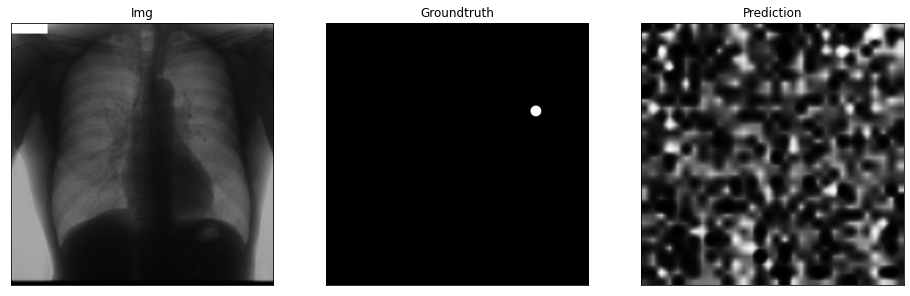


 Index:2, IoU=0.00111


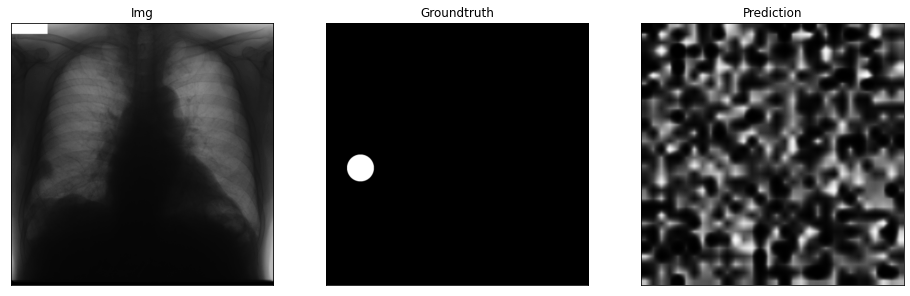


 Index:3, IoU=0.00002


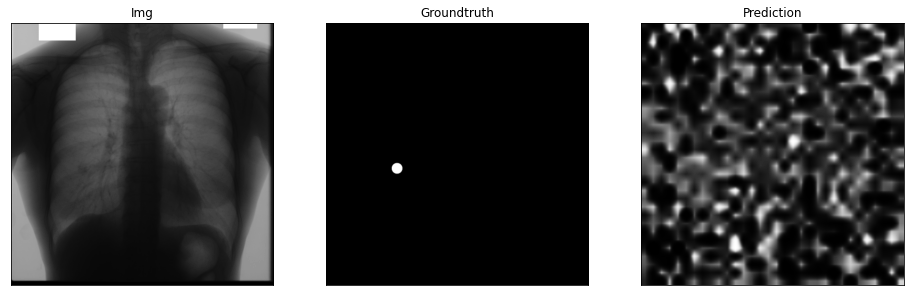


 Index:4, IoU=0.00708


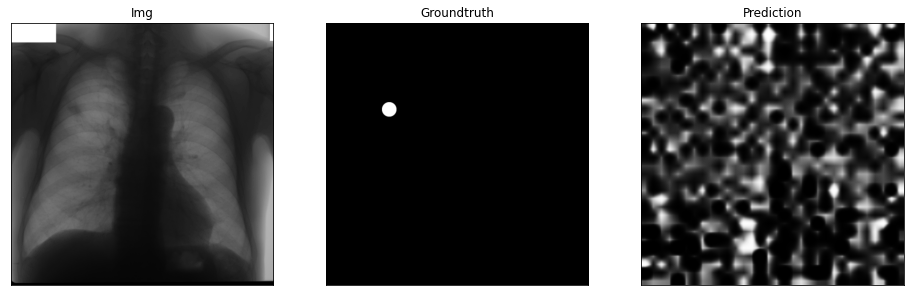


 Index:5, IoU=0.01394


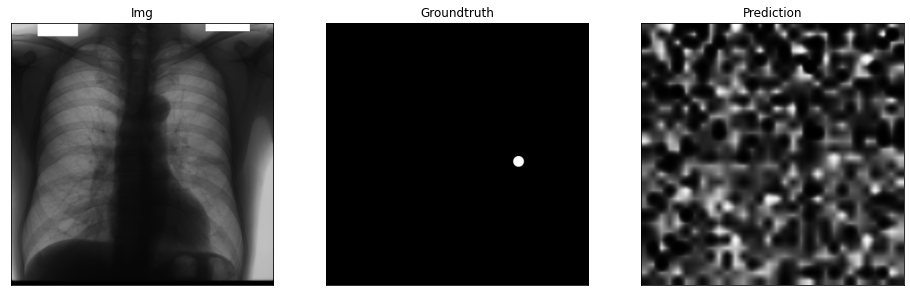


 Index:6, IoU=0.00113


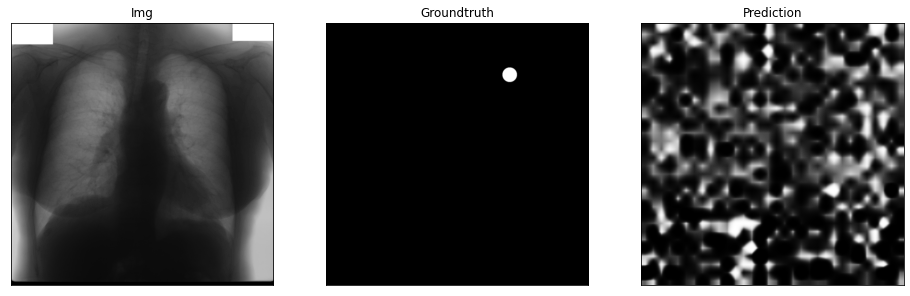


 Index:7, IoU=0.00000


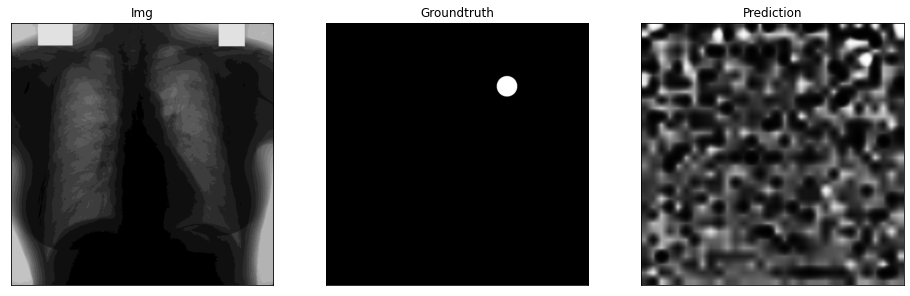


 Index:8, IoU=0.00118


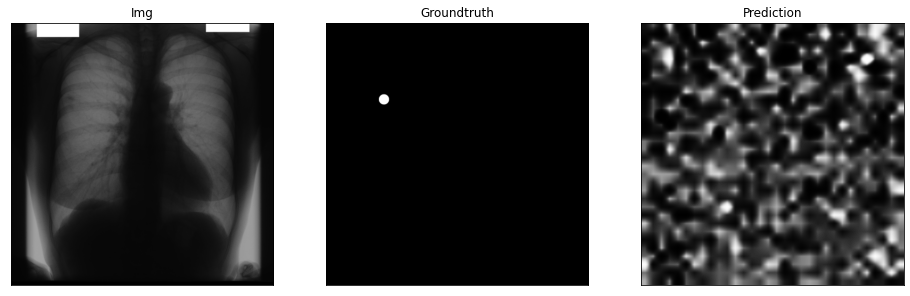


 Index:9, IoU=0.00024


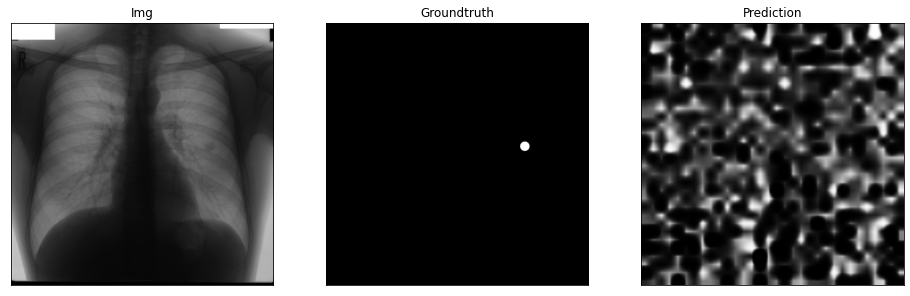


 Index:10, IoU=0.00148


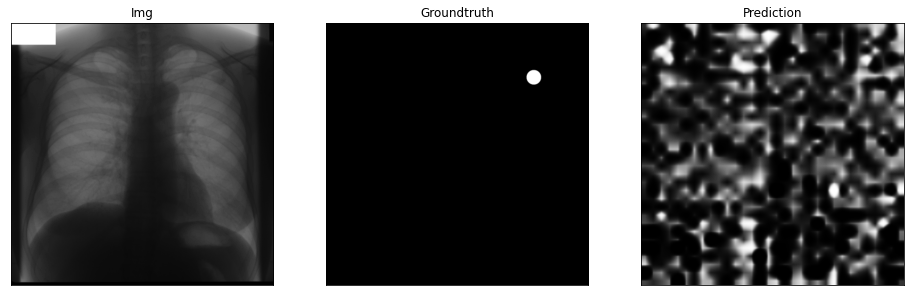


 Index:11, IoU=0.00983


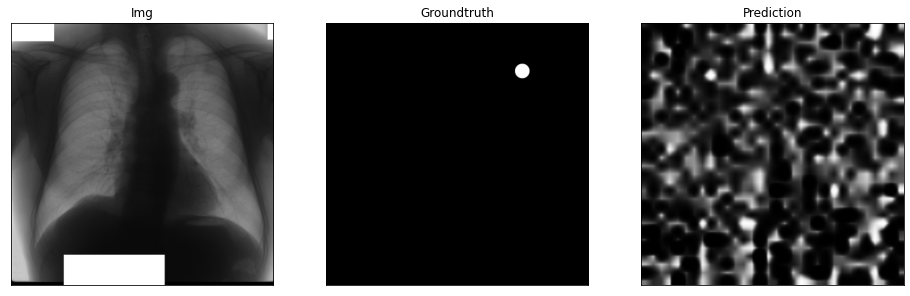


 Index:12, IoU=0.00760


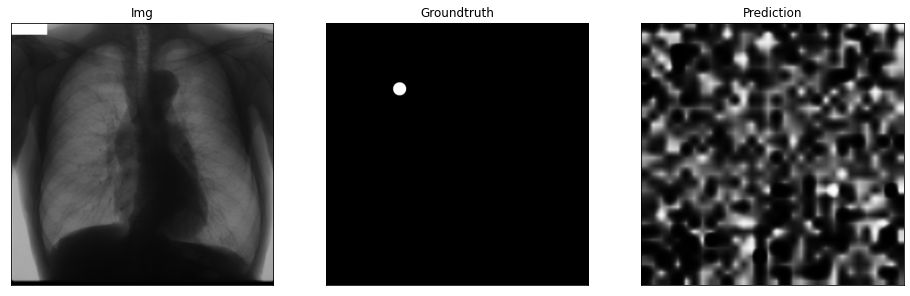


 Index:13, IoU=0.00000


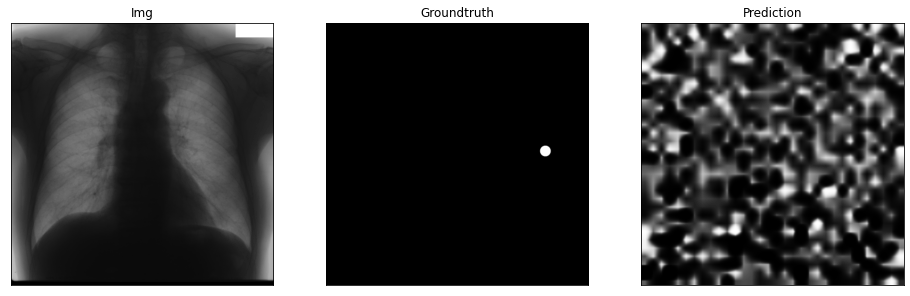


 Index:14, IoU=0.00709


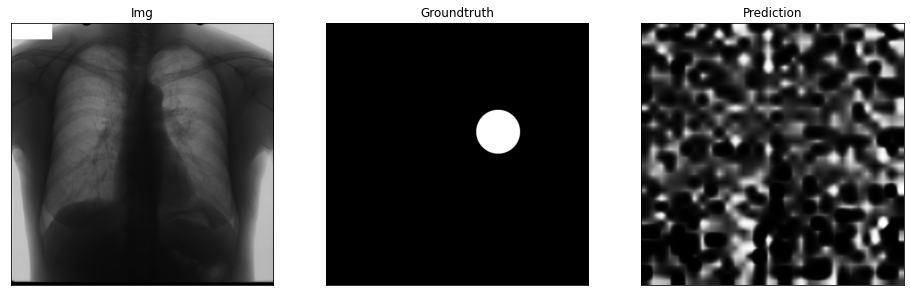


 Index:15, IoU=0.00000


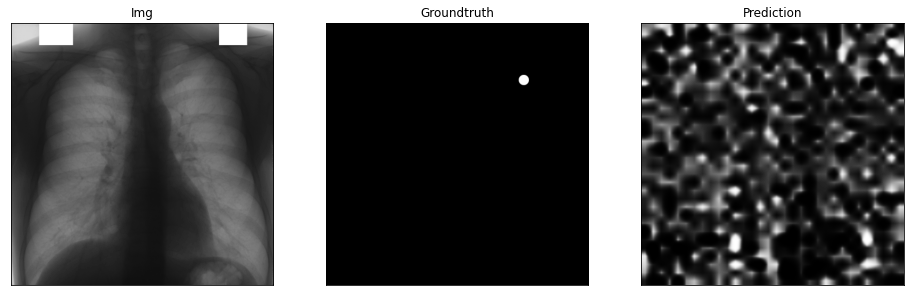


 Index:16, IoU=0.00023


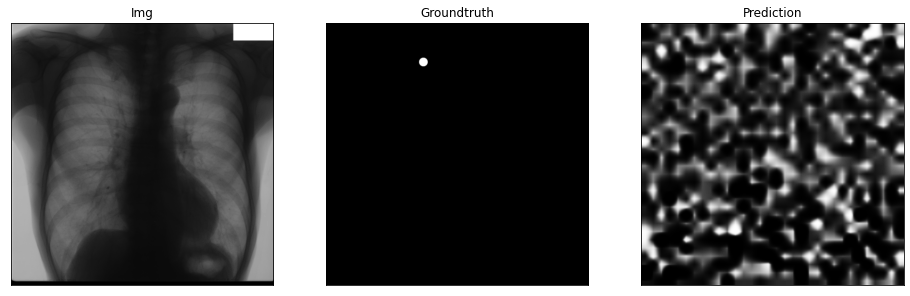


 Index:17, IoU=0.00000


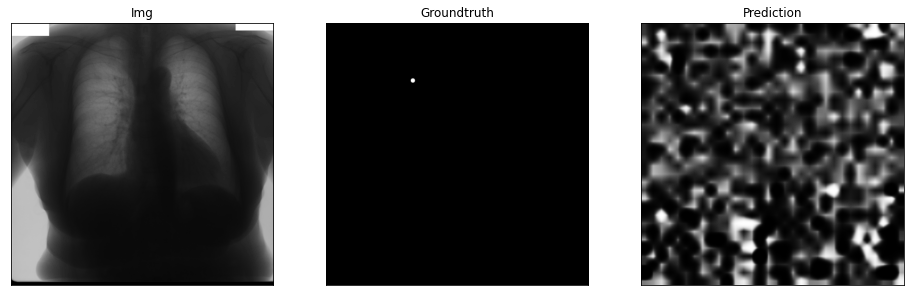


 Index:18, IoU=0.00000


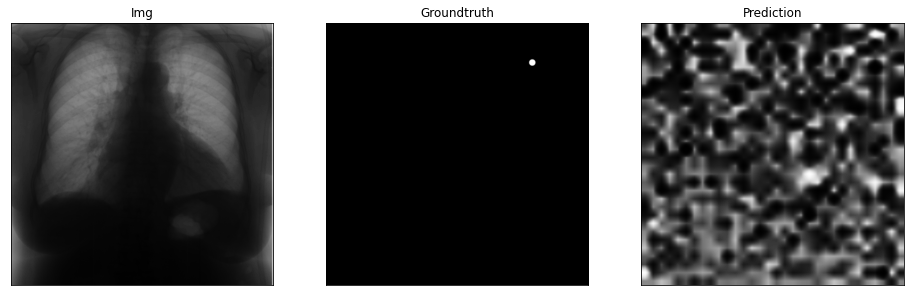


 Index:19, IoU=0.00000


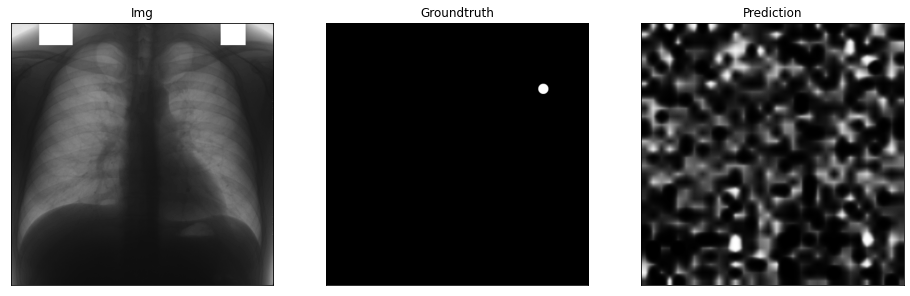


 Index:20, IoU=0.00079


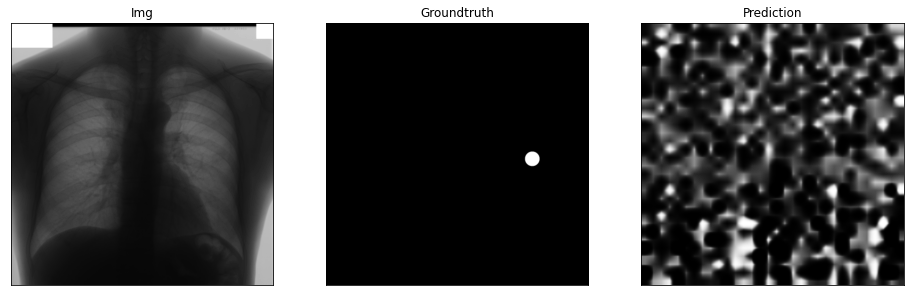


 Index:21, IoU=0.00000


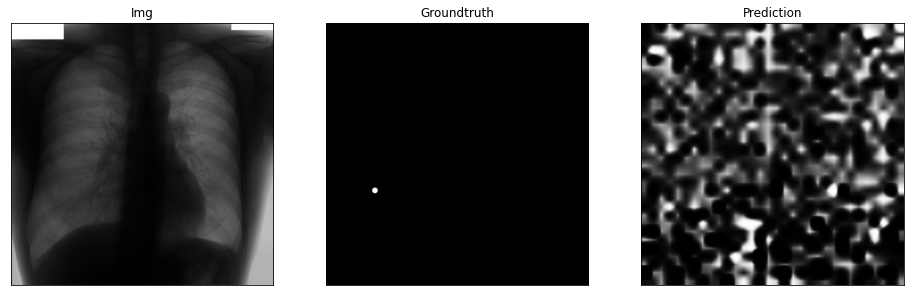


 Index:22, IoU=0.00682


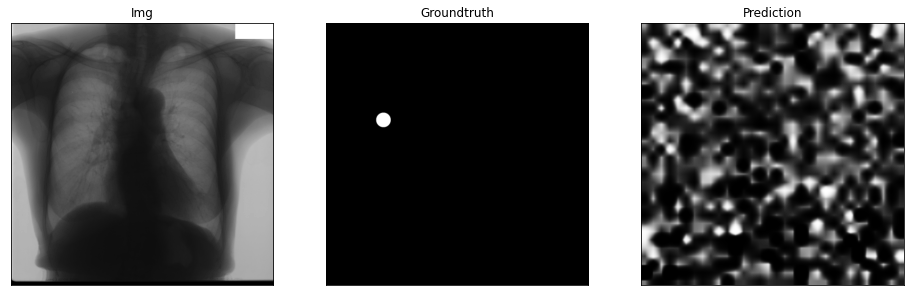


 Index:23, IoU=0.00218


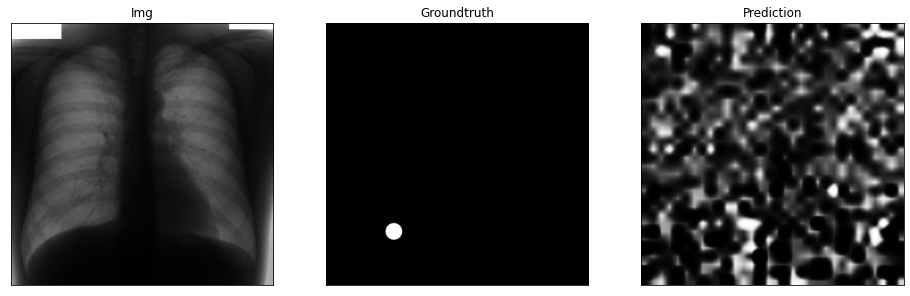


 Index:24, IoU=0.00000


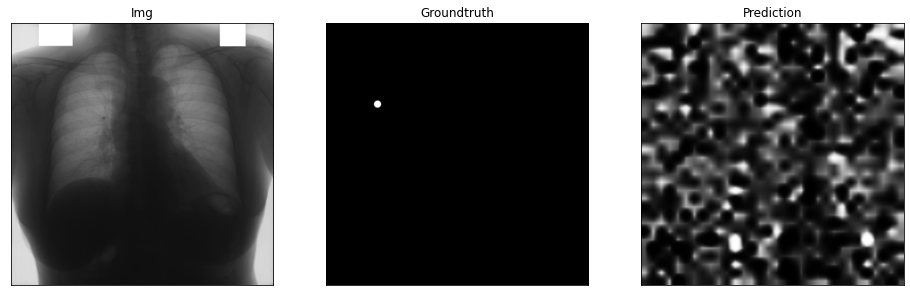


 Index:25, IoU=0.00000


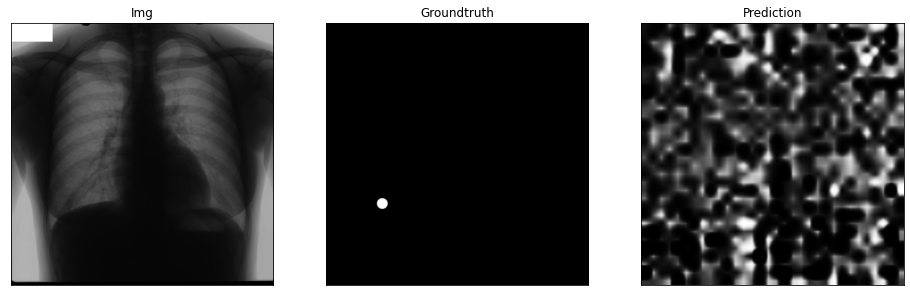


 Index:26, IoU=0.00052


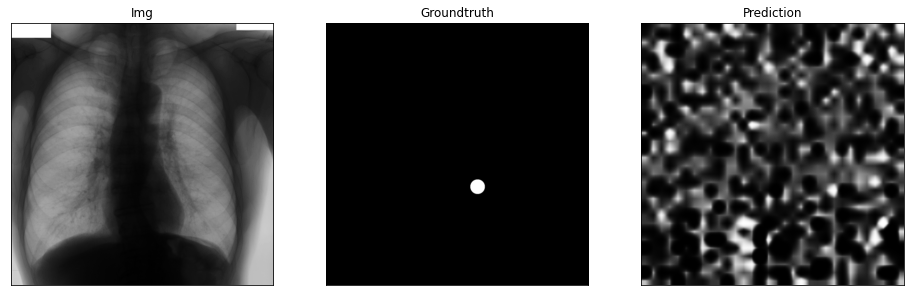


 Index:27, IoU=0.00000


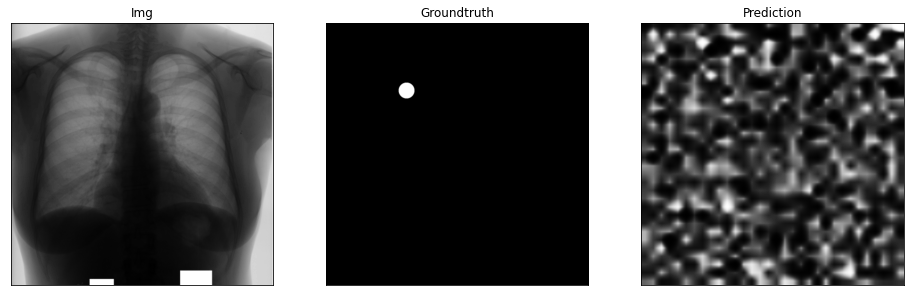


 Index:28, IoU=0.00000


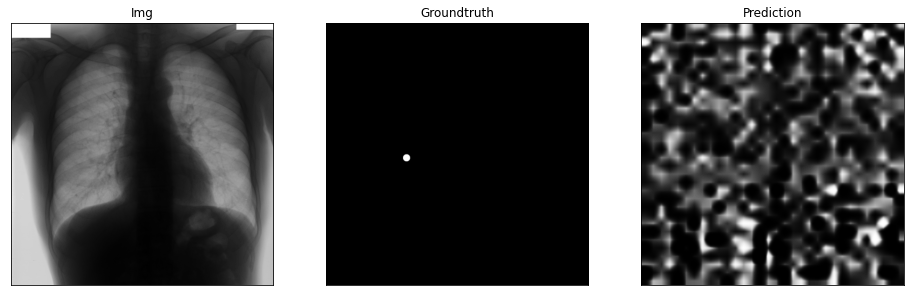


 Index:29, IoU=0.00022


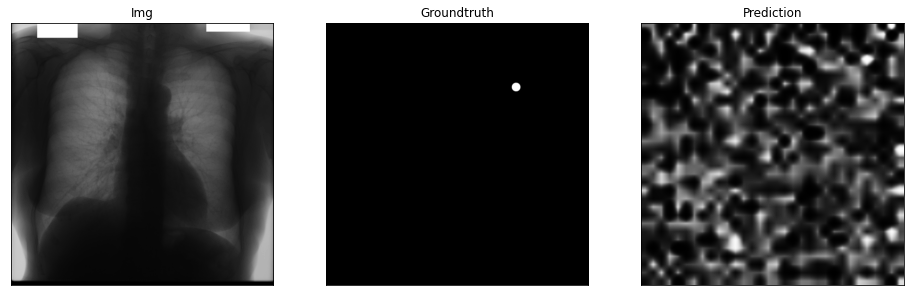


 Index:30, IoU=0.00004


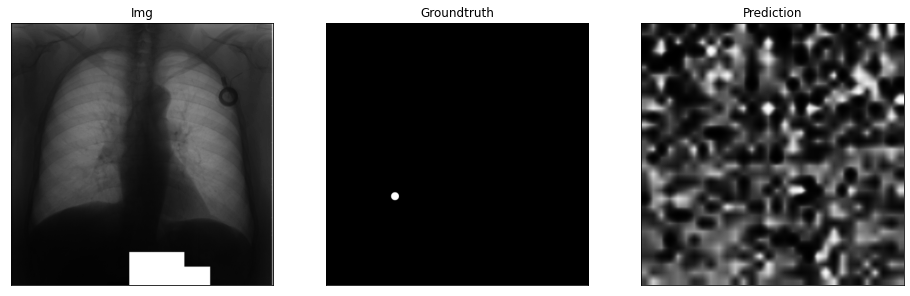


 Index:31, IoU=0.00000


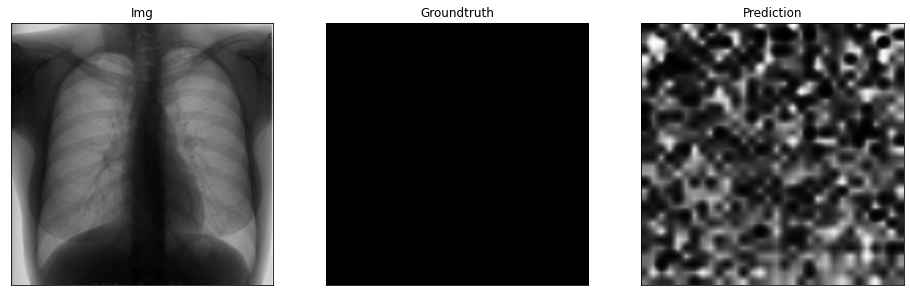


 Index:32, IoU=0.00000


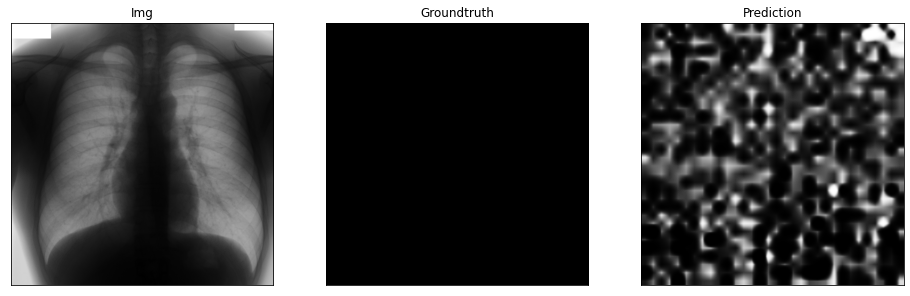


 Index:33, IoU=0.00000


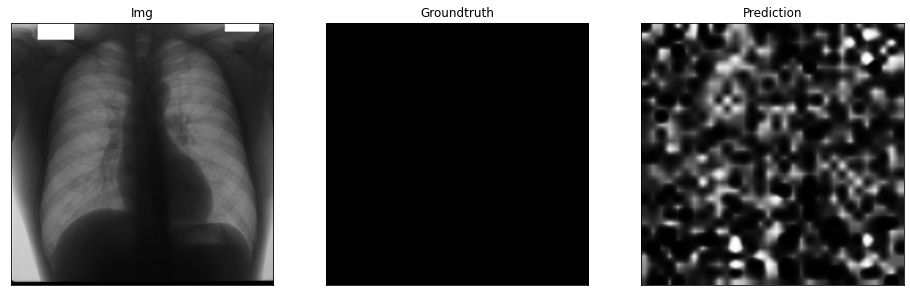


 Index:34, IoU=0.00000


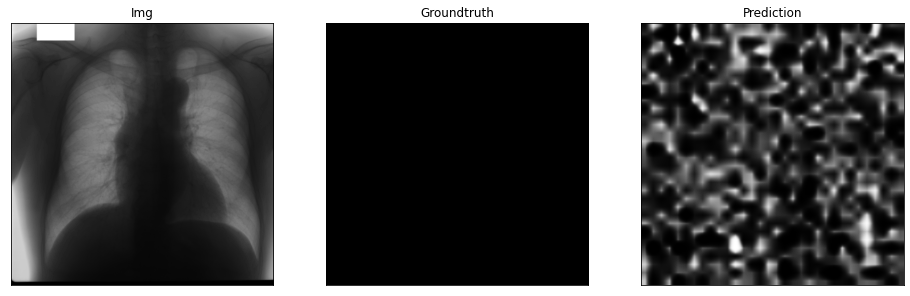


 Index:35, IoU=0.00000


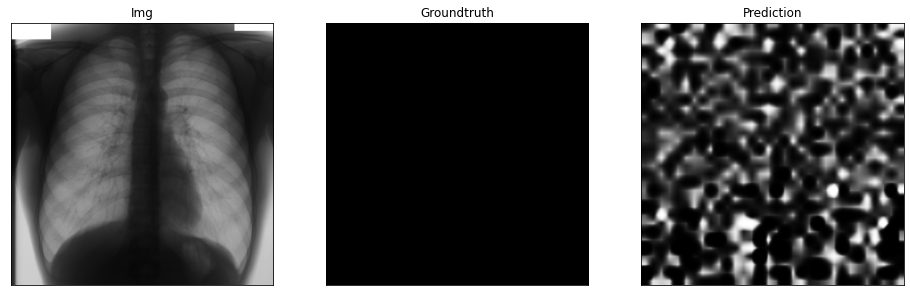


 Index:36, IoU=0.00000


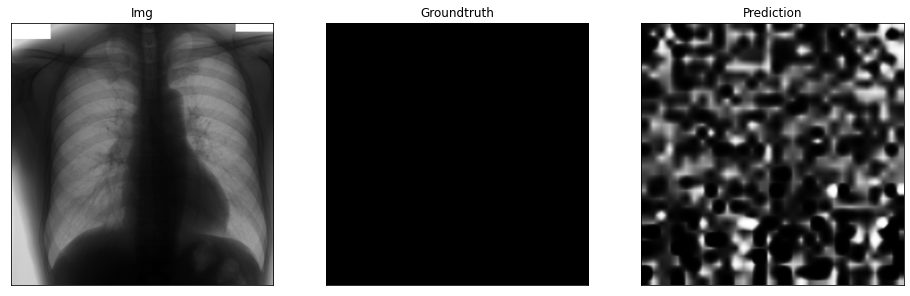


 Index:37, IoU=0.00000


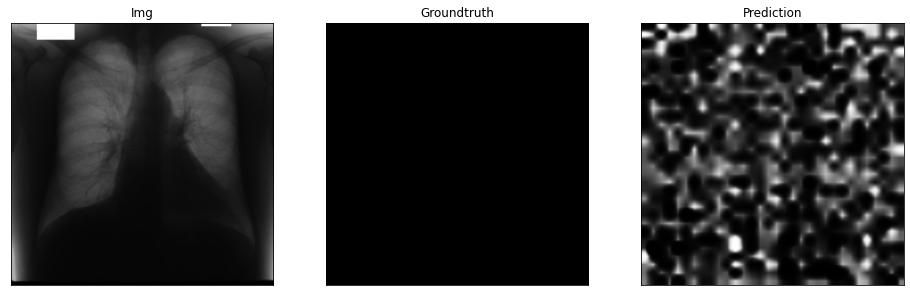


 Index:38, IoU=0.00000


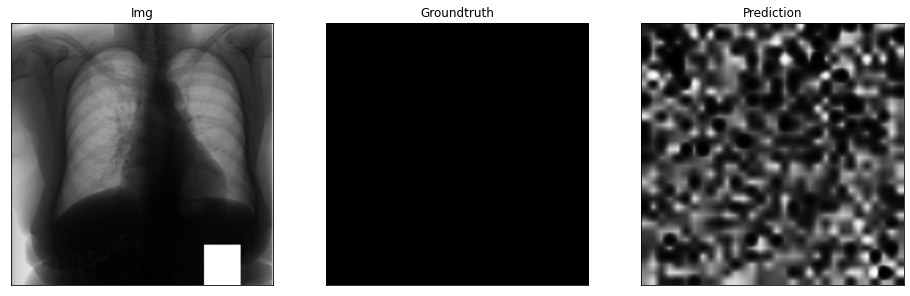


 Index:39, IoU=0.00000


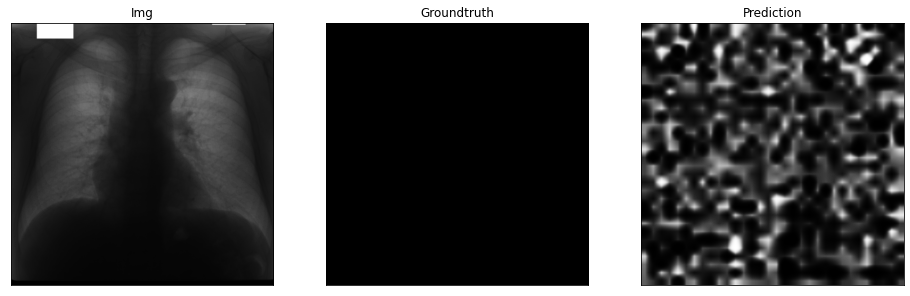


 Index:40, IoU=0.00000


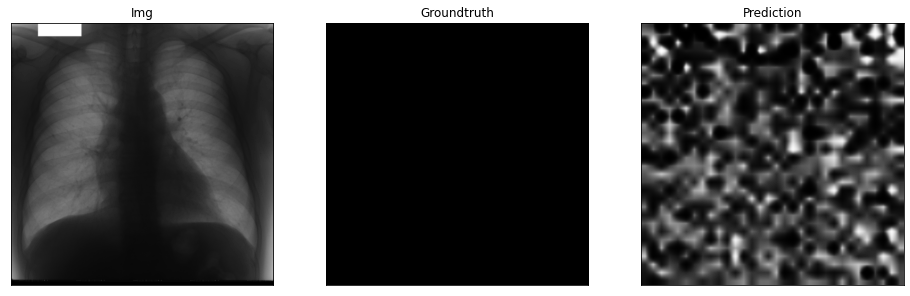


 Index:41, IoU=0.00000


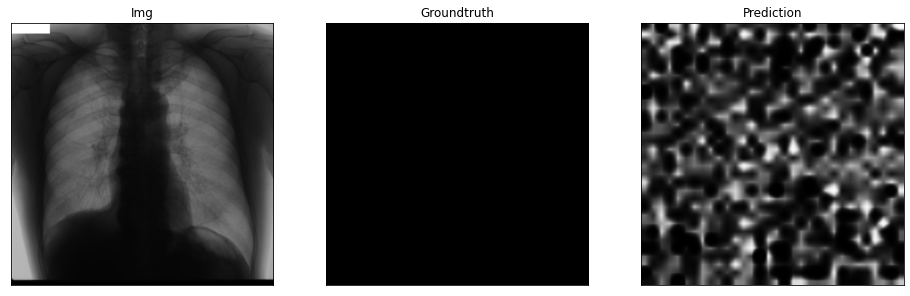


 Index:42, IoU=0.00000


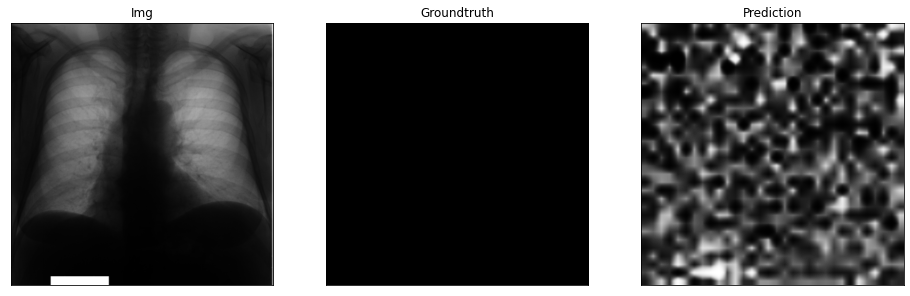


 Index:43, IoU=0.00000


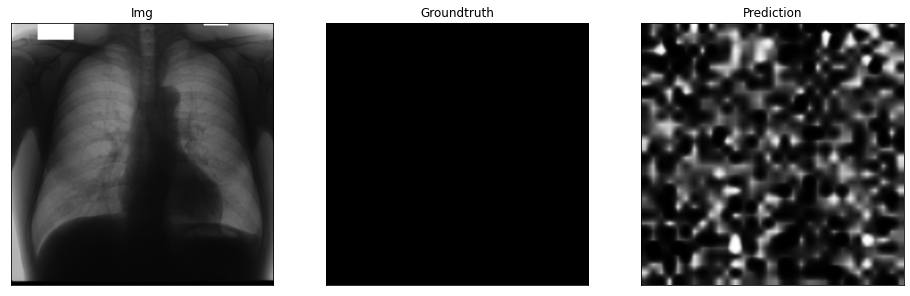


 Index:44, IoU=0.00000


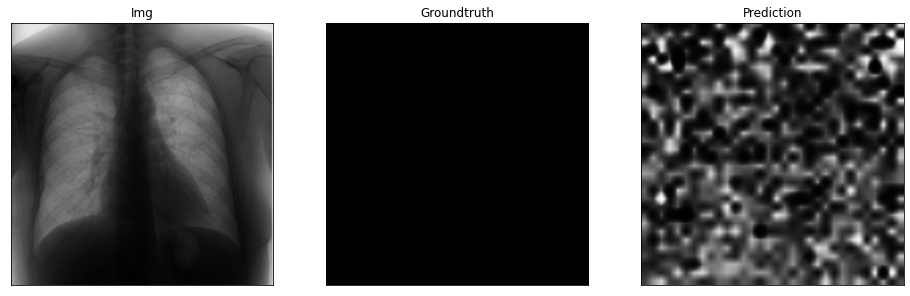


 Index:45, IoU=0.00000


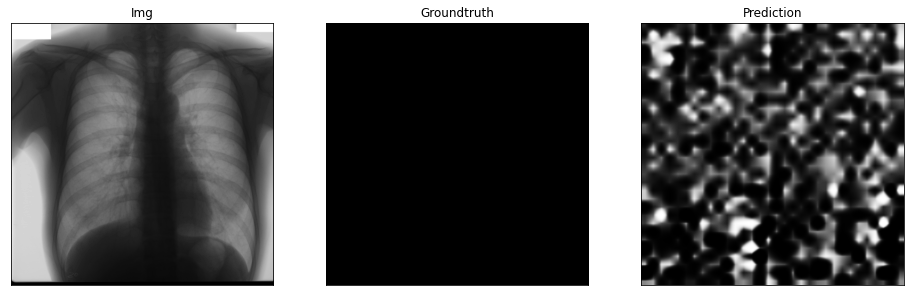


 Index:46, IoU=0.00000


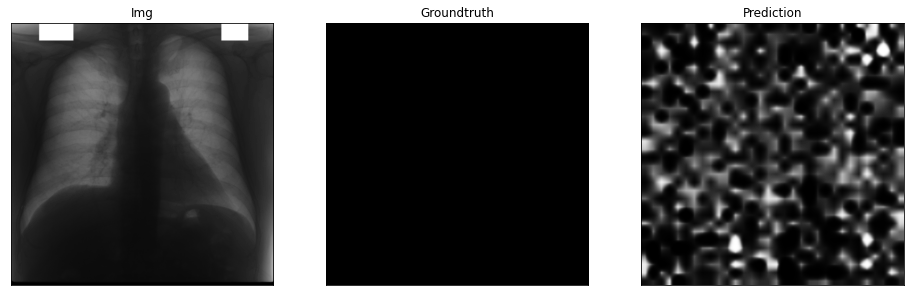


 Index:47, IoU=0.00000


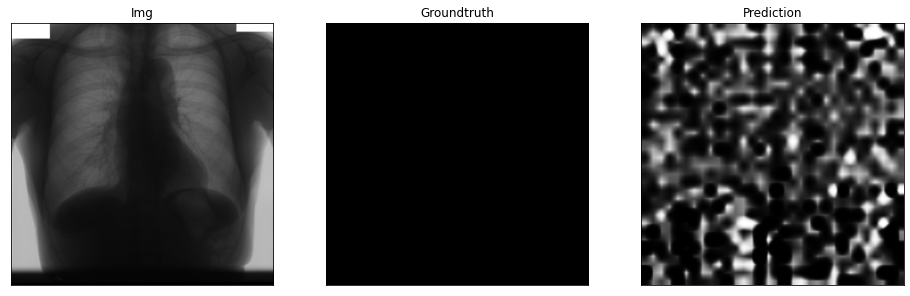


 Index:48, IoU=0.00000


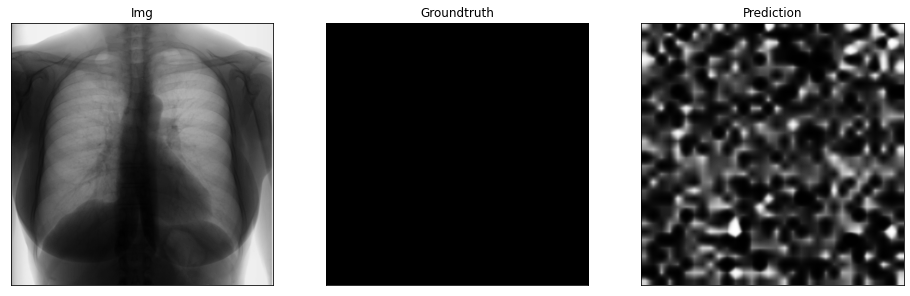


 Index:49, IoU=0.00000


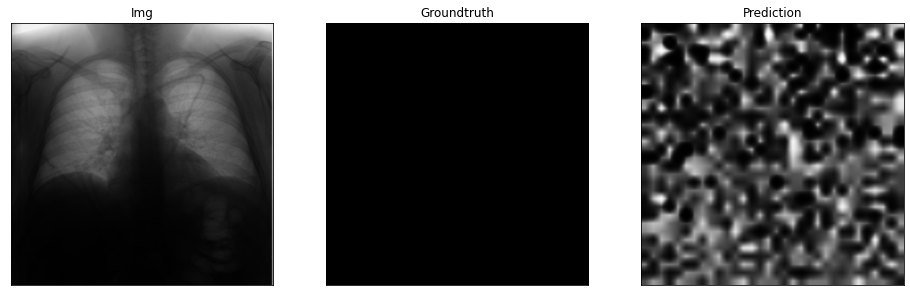

In [26]:
for index, data in enumerate(zip(imgs, predict, msks, iou_score)):
    img, pr, msk, iou = data
    print("\n Index:{}, IoU={:.5f}".format(index+1, iou))
    visualize(
        img = img,
        groundtruth = msk,
        prediction = pr
    )

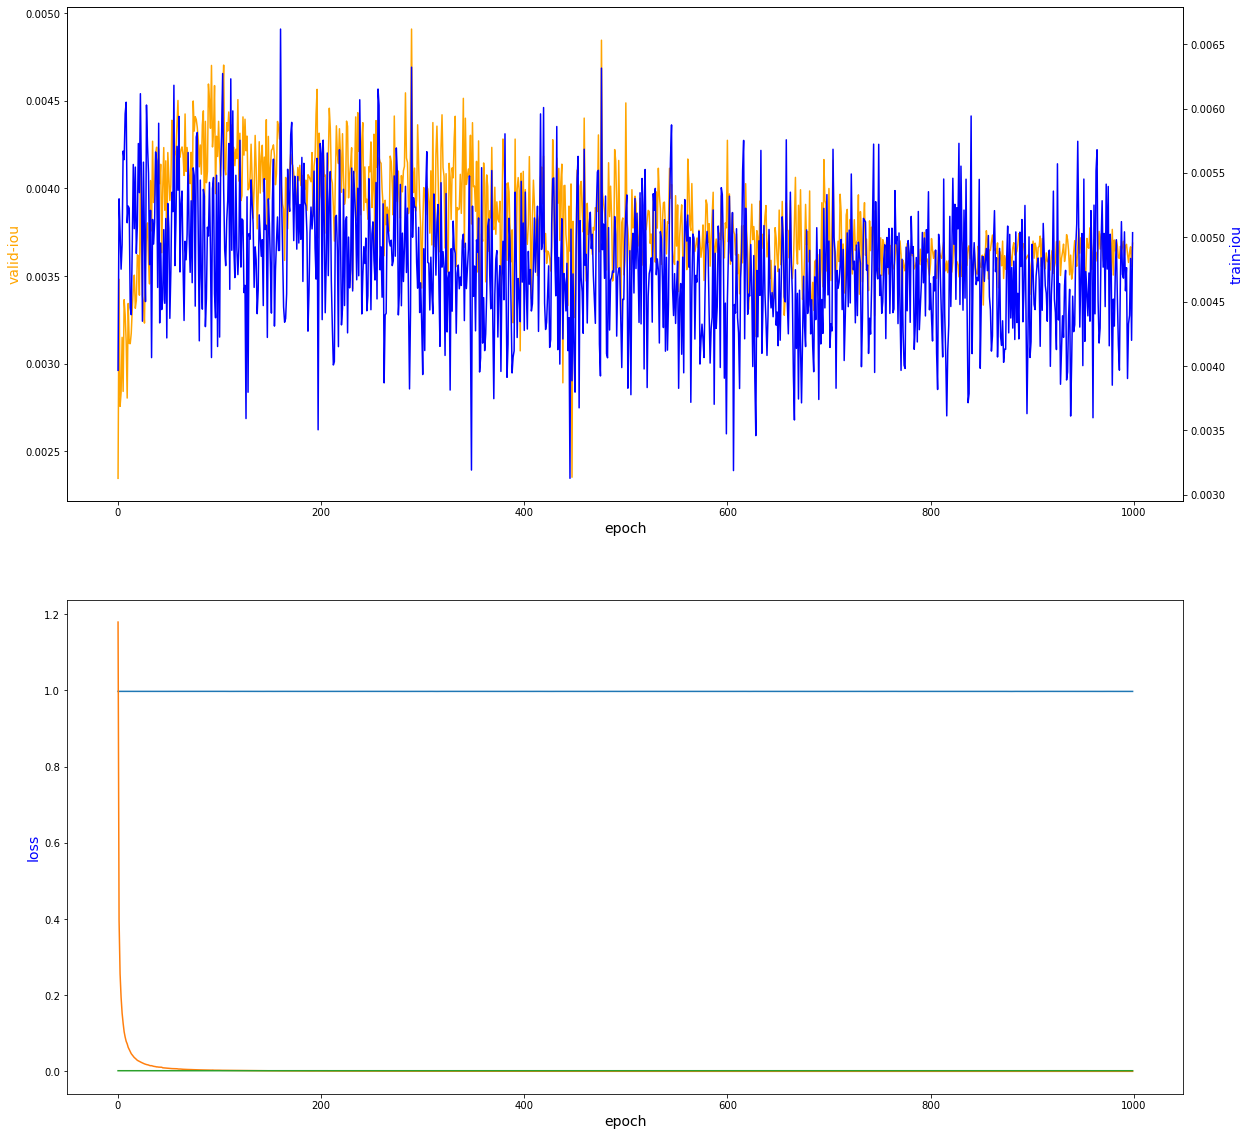

In [17]:
# create figure and axis objects with subplots()
fig, axs = plt.subplots(2, 1, figsize=(20, 20))
# make a plot
axs[0].plot(epoch_logs['iou-valid'], color="orange")
# set x-axis label
axs[0].set_xlabel("epoch",fontsize=14)
# set y-axis label
axs[0].set_ylabel("valid-iou",color="orange",fontsize=14)


# twin object for two different y-axis on the sample plot
ax2 = axs[0].twinx()
# make a plot with different y-axis using second axis object
ax2.plot(epoch_logs['iou-train'], color="blue")
ax2.set_ylabel("train-iou", color="blue", fontsize=14)



axs[1].plot(epoch_logs['diceloss'])
axs[1].plot(epoch_logs['kl divergence'])
axs[1].plot(epoch_logs['diagonal loss'])
axs[1].set_xlabel("epoch",fontsize=14)
axs[1].set_ylabel("loss", color="blue", fontsize=14)
plt.show()

fig.savefig(os.path.join(os.getcwd(),'logs.png'),
            bbox_inches='tight',
           facecolor='white')